# <center>  AE Thesis MSc. C&S - Dragonfly & Control - RWVOS
## <center> PEG1 - Ray RLlib - Version 5
### Author:  Reinier Vos, 4663160
### Date: 26/09/2024

This notebook forms the main script to run PEG1 experimental Ray RLlib setup of AE MSc. thesis research. PEG1 is the first in the series of experiments related to simulation of pursuit evasion games focused on during this thesis. Code scripts/notebooks denoted by exmperiment code 'PEG1\_'. In addition, refer to the latex report on this experiment PEG<'version'>\_RWVOS4663160_<'date'>.PDF.


#### RELATED SCRIPTS:
- PEG1_env.py; contains custom environments for experiment (setup) according to Ray RLLib functionality. This script is called as module.
- PEG1_models.py; contains custom models for experiment (setup) according to Ray RLLib & Pytorch functionality. This script is called as module.

#### RELATIONSHIP TO PREVIOUS VERSIONS:
**PEG<'versions'>**:
- **PEG1**: the first main version, with no priors. Implementation combined with learning of Ray RLlib.

**PEG1_v<'versions'>**:
- **Version 1 (& derivatives)**: considers SARL (single pursuer, dummy evader) setting using PPO & custom models. Agents operate in 2d with 1 DOF; only control rotational rate (i.e. 1DOF) based on ideal (deterministic) observation/input set. They operate under constant (relative) velocity and system is numerically integrated. Static environment with fixed relative velocity parameter & random initialization of positions and evader heading. Objective focusses on pursuer with terminal reward for interception and dense rewards related to distance (for details see scripts).
- **Version 2 (& derivatives)**: considers MARL (single pursuer & single evader) setting using PPO & custom models. Agents operate in 2d with 1 DOF; only control rotational rate (i.e. 1DOF) based on ideal (deterministic) observation/input set. They operate under constant (relative) velocity and system is numerically integrated. Static environment with fixed relative velocity parameter & random initialization of positions and evader heading. Objective focusses on pursuer and evader with terminal reward for interception/esc and dense rewards related to distance (for details see scripts).
- **Version 3 (& derivatives)**: considers MARL (single pursuer & single evader) setting using PPO & custom models. Agents operate in 2d-1/2DOF, 3d-2/3/4DOF; see files for dynamic system definition. Observation delay and non-ideal control (tf & limits) dynamics available. Numerical integration using RK45. Static environment with fixed relative velocity parameter & random initialization of positions and evader heading. Blindsighting dynamics incorporated. Custom models includes benchmarks (PN), dummy models, FNN and RNN system types. Dense reward functions based on distance, gamma and/or time as well as terminal rewards for interception and escaped (also truncation for missed). Curriculum learning, behavioural cloning, auxiliary learning and self-imitation learning available. Main difference with later versions is that inference is done in own code instead of using ray rllib native functions. 
- **Version 4 (& derivatives)**: considers MARL (single pursuer & single evader) setting using PPO & custom models. Agents operate in 2d-1/2DOF, 3d-2/3/4DOF; see files for dynamic system definition. Observation delay and non-ideal control (tf & limits) dynamics available. Numerical integration using RK45. Static environment with fixed relative velocity parameter & random initialization of positions and evader heading. Blindsighting dynamics incorporated. Custom models includes benchmarks (PN), dummy models, FNN and RNN system types. Dense reward functions based on distance, gamma and/or time as well as terminal rewards for interception and escaped (also truncation for missed). Curriculum learning, behavioural cloning, auxiliary learning and self-imitation learning available. Key point of this version is the hard push to use anything and all ray rllib native (functions/classes) compared to previous versions in order to avoid misunderstandings/improper data conversions between pipeline subsections.
- **Version 5 (& derivatives)**: considers MARL (single pursuer & single evader) setting using PPO & custom models. Agents operate in 2d-1/2DOF, 3d-2/3/4DOF; see files for dynamic system definition. Observation delay and non-ideal control (tf & limits) dynamics available. Numerical integration using RK45. Static environment with fixed relative velocity parameter & random initialization of positions and evader heading. Blindsighting dynamics incorporated. Custom models includes benchmarks (PN), dummy models, FNN and RNN system types. Dense reward functions based on distance, gamma and/or time as well as terminal rewards for interception and escaped (also truncation for missed). Curriculum learning, behavioural cloning, auxiliary learning and self-imitation learning available. TODO EXPAND DESCRIPTION f

### P0 - Initialize libraries
#### P0.1: Package imports

In [ ]:
import gymnasium as gym
import os
import importlib
import inspect
import warnings
##
import ray
from ray import air, tune
from ray.rllib.algorithms.ppo import PPOConfig
from ray.tune.registry import register_env

##
import torch

##
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime

warnings.filterwarnings("ignore", module="scipy.spatial.transform")

In [ ]:
if torch.cuda.is_available():
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

#### P0.2: Initialize ray
<br>Links:
- (RAY documentation)
      - [Solve Ray RLlib space dir error](https://discuss.ray.io/t/ray-unable-to-find-worker-py-due-to-spaces-in-filepath-windows/9591/11)

In [ ]:
ray.shutdown()
ray.init(ignore_reinit_error=True, 
         num_cpus = 5+3, 
         num_gpus = 1,##
         include_dashboard=True) #storage="C:///Users/Reinier Vos/Documents/PEG1/runs")
# https://discuss.ray.io/t/can-rllib-use-gpu-accelerator/4281

In [ ]:
ray.available_resources() #ray.cluster_resources()

### P1: Configure experiment
#### P1.1: Configure environment
<br>Links:
- f
- Some examples: [SA-Ruslan](https://ruslanmv.com/blog/How-to-create-a-custom-Reinforcement-Learning-Environment-in-Gym-and-Ray), [MA-learning ray](https://maxpumperla.com/learning_ray/ch_04_rllib/) [TrajectoryTracing](https://github.com/mg64ve/TrajectoryTracking/blob/main/rllib/TrajectoryTracking.ipynb)

Environment specifics:
- [Partial observability](https://github.com/ray-project/ray/blob/master/rllib/examples/multi_agent_different_spaces_for_agents.py): Seperate observation spaces agents, note the private arguments!
- [Indepedent learning agents](https://github.com/ray-project/ray/blob/master/rllib/examples/multi_agent_independent_learning.py): i.e. (multiple SA algos)
- Curriculum learning environment example code [LINK](https://maxpumperla.com/learning_ray/ch_04_rllib/)
    - see ideas in other section of this notebook!

In [ ]:
import PEG1_env as PEGenv
importlib.reload(PEGenv)

#### P1.2: Configure Model & Callbacks
Notes
- Custom model requires *forward* and *value function* implementation: The former function is called in forward pass and computes both *action_logits* and *value*, but shares only action logits (note Ray handles action transforming to required space). The latter function returns the cached value function. 
- (Ray warning) Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config'] i.e. in a nested dict!
- In ray native examples (e.g. [LINK](https://github.com/ray-project/ray/blob/master/rllib/examples/models/rnn_model.py)) you can see that value is only computed through value function to speed up inference after training is over!
- I checked if forward_rnn works like expected and yes it seems it caches previous observations up to seq_max_len
    - Trajectory APi blogpost [LINK](https://medium.com/distributed-computing-with-ray/attention-nets-and-more-with-rllibs-trajectory-view-api-d326339a6e65)
- **NOTE**: for in depth notes on specific models types (e.g. recurrent or simple forward) as well as comments and best practices see documentation at PEG1_models_<'version'>.py

Links:
- Register models;[LINK](https://github.com/ray-project/ray/blob/master/rllib/examples/multi_agent_cartpole.py)
- centralized & decentralized [LINK](https://github.com/ray-project/ray/blob/master/rllib/examples/centralized_critic.py)
- sharing [LINK](https://github.com/ray-project/ray/blob/master/rllib/examples/multi_agent_parameter_sharing.py), also see register model link
- General best practices, example code for models and/or multiagents & notes on scaling (e.g. at [LINK](https://bair.berkeley.edu/blog/2018/12/12/rllib/))
- RNN model example [LINK](https://github.com/ray-project/ray/blob/master/rllib/examples/models/rnn_model.py)
- Appending previous actions to input/observation set can be built in without appending to observation space explicitly in env [LINK](https://github.com/ray-project/ray/blob/master/rllib/models/torch/recurrent_net.py)

Callbacks related;
- Callbacks source code, every type [LINK](https://docs.ray.io/en/latest/_modules/ray/rllib/algorithms/callbacks.html)
- github (pole angle) example with multiple definitions [LINK](https://github.com/ray-project/ray/blob/master/rllib/examples/custom_metrics_and_callbacks.py)

TODO
- potentially ray rllibs rnn_tokenizer for attention might be the key  to ensure consistent T dimension [LINK](- https://github.com/ray-project/ray/blob/master/rllib/examples/custom_recurrent_rnn_tokenizer.)py
- is_training boolean for models is spotted for batch normalization [LINK](https://docs.ray.io/en/latest/rllib/rllib-models.html)

In [ ]:
import PEG1_models as PEGmodels
importlib.reload(PEGmodels)
#PEGmodels.CustomTorch_DummyNullModel(None, None, None, None, None)

#### P1.2.*: Hyperparameters optimization
LINKS
- Hyperopt tuner config [LINK](https://docs.ray.io/en/latest/tune/getting-started.html#evaluating-your-model-after-tuning) and [LINK](https://docs.ray.io/en/latest/tune/index.html)

#### P1.3: Configure RL algorithm

Links:
- [RAY documentation for algorithms](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#shared-critic-methods)
- Multiple trainers: [LINK](https://github.com/ray-project/ray/blob/master/rllib/examples/multi_agent_two_trainers.py)
- General best practices, example code for models and/or multiagents & notes on scaling (e.g. at [LINK](https://bair.berkeley.edu/blog/2018/12/12/rllib/)
- Alternative PPO: distributed PPO (DDPPO) and Asychronous PPO (APPO) [LINK](https://github.com/ray-project/ray/tree/master/rllib/algorithms/ppo)


PPO ALGORITHM (Angle only intercept w RL- Gaudet2019):
<br>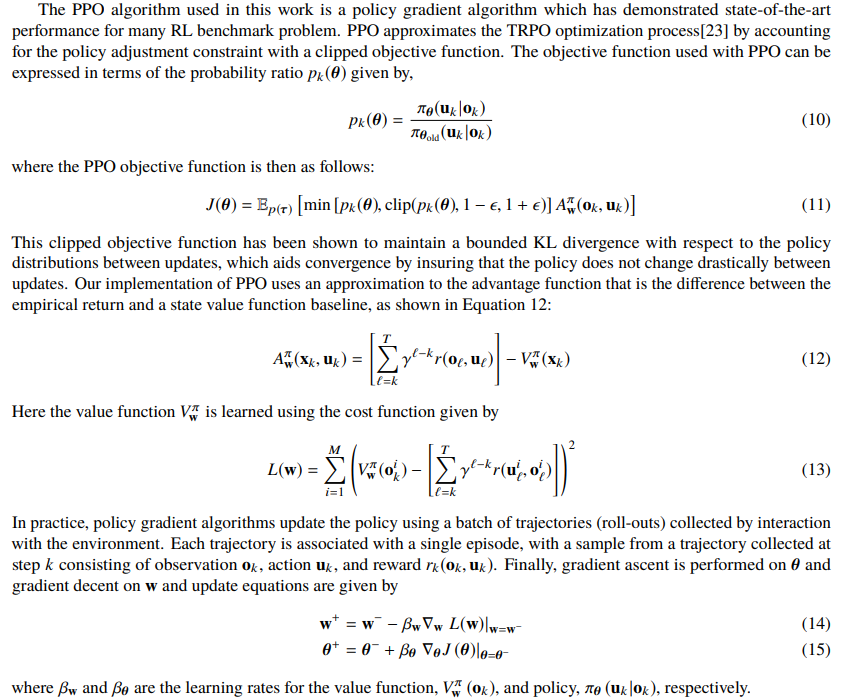

TO CONSIDE
Value functions;
- I do not know if CL with reward at different scales is good for learning the value function, to me it seems as if this would have to constantly adjust its scale while the inherent task (i.e. interception) remains constant. I think that this problem might be emphasized if the critic has no estimate of distanc  to stablize training we might therefore need to give the distance measure to the value function, but not the policy; to make sense of this differenc.
     - Generally I do NOT think this would be bad in general (giving critic more info on global state). Otherwise we have to revise the scale.
-  Consider value function scale, excitation (i.e. when do I get reward) and reward sparsity. Generally I do not think its too bad if the value functions dynamics change as we improve learning  (with e.g. CL), but it should not become troubling, such that every iteration a different scale and structure for rewards/value estimates has to be learnt!
      - So we need to make it gradual, e.g. dense rewards can dissapear between phases; but only in case they do not cause a sudden shock in estimates!

PPO and replay buffer, rewards & misc:
- PPO is on-policy and do not have replay buffer (these are logically related), therefore between training phases/iterations the enironment can change quite a bit as the data will always be sampled from zero samples in every stage. In addition, curriculum learning with different reward scales should not be a problem. This is because samples from the previous sampling stage (with a different reward scale) will not be mixed with sampling in the current stage and therefore will not be used in the PPO algorithm.
- Does PPO clip rewards above a certain scale? No it clips the new policy from deviating too much from the previous one see documenation above, there is no comment on clipping the reward here. in fact the reward is related to the advantage variable which is not clipped at all in the algorithm

    
Ray Rllib value function traces (Kl, var explained, vf_loss, entropy)
- stackoverflow comments [LINK](https://stackoverflow.com/questions/60667933/understanding-tensorboard-plots-for-ppo-in-rllib)
- Custom policy losses; [LINK](https://github.com/ray-project/ray/issues/7855) and [LINK](https://github.com/ray-project/ray/issues/8016)
- F


Custom policies:
- Old ray documentation? very complete though [LINK](https://docs.ray.io/en/latest/rllib/rllib-concepts.html)f

#### P1.4: Configure Evaluation functions
- incorporate links from code below here

In [ ]:
import PEG1_analysis as PEGanalysis

#### P1.5: Learning related

##### Reward function, task difficulty & curriculum learning and estimation stability
CONSIDERATIONS 

Reward function:
- if you only control rotation; then having to adjust your rotation to get into correct position (i.e. turning) might provide a negative reward if reward is only focused on distance
- ensure reward is always tied to action, i.e. no reward now for previous actions that brought you in a good position (so 'residualize' reward by previous state)
- too much negative reward might not be beneficial
    - this might not be completely true as PPO focuses on clipping positive rewards to force a harder push away from bad behaviour
- think of the scale of different rewards use i.e. if you want dense reward (during game) rather than sparse (game end) then this reward should not overshadow reward of quick termination; otherwise a strategy might be too almost catch but never terminate game
- Think of the reward content and format, can your agent explicitly relate the reward to its action (i.e. can it 'see it')
  - **TODO** isnt a cartesian distance reward for a rotational control task then not a weird thing? essentially your not just asking for a strategy, but for it to learn transformation of frames as well? (which might be the harder task...)
- in order to make the (number of) rewards timestep invariant it might be interesting to scale the reward by the current timestep (this idea comes from 'game of drones') 
- Reward idea is related to finite MC and reactionary reward for potential detection
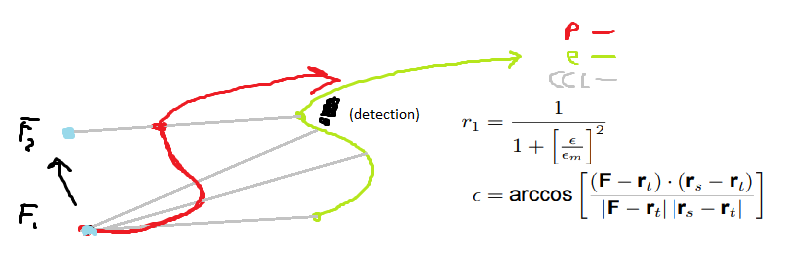

Reward function - Game theory specific notes
- **Theory**: If you want zero sum then total reward of the game at any time == 0, this can easily be checked in tensorboard.
    - Practical: this implies that agents have mirrored rewards i.e. reward & -reward
    - **General consideration**: this makes dense rewards pretty hard! if you only keep terminal rewards then mirrored ones are fine and complex behaviour can emerge, yet if you use continuous dense rewards this implies youre essentially learning to controllers to do the exact opposite
          - **IDEA** maybe discrete rewards can be dense yet not too continuous! e.g. (1) related to detection (2) update based on distance
          - f

task difficulty:
- provide enough time for interception but also not too much time
- interception should be too easy (wrt to intereception/initial distance & and evader heading)
- interception should not be too hard e.g. too far away and evader moving completely away from pursuer from the start

curriculum learning (see link at env section for custom curriculum learning)
- gradually increase e_v_rel (velocity parameter); i.e. start with stationary and gradually move quicker
- gradually change the potential initial heading angles of pursuer and/or evader; i.e. evader might have unlimited heading range (currently not the case ><) and pursuer might not be alligned with initial evader position?
- Gradually decrease capture radius 
- Gradually increase time-delay? or gain settings of the dynamic system i.e. first ideal then nonideal
- **self-play** is the ultimate form of curriculum learning, maybe we can do this for the pursuer and evader seperately first i.e. they train against themselves first;
maybe having a mirrored controller i.e. f() = act & = -act is enough to have 'evasion' version of the pursuer's model?
- **imitation learning (combo)**: "a UAV PEG based on DDPG and imitation learning - fu2022" shows DDPG with initial replay buffer stacked by PN law which improves training speed (especially in initial stage). Would be interesting to use it as well, yet PPO does not use replay buffer; you can do one of 2 things:
     - (A) skip environment sampling for first iter and initialize the memory with an expert strategy, then let PPO work like normal in subsequent iterations 
     - (B) initialize some kind of path through your NN network (maybe via residual connection OR additional term  on output) which implies PN (through direct connection between LoS rate and action). Potentially you could cutoff this connection at latter stage by manually setting coef == 0.
- Ray RLLIB curriculum learning [LINK](https://docs.ray.io/en/latest/rllib/rllib-advanced-api.html#curriculum-learning), also [LINK](https://github.com/ray-project/ray/blob/master/rllib/examples/curriculum_learning.py)
- For on-polic aglorithms such as PPO, curriculum learning with different reward scales should not be a problem. This is because samples from the previous sampling stage (with a different reward scale) will not be mixed with sampling in the current stage and therefore will not be used in the PPO algorithm.

Co-evolution: setup, stability, and other considerations
- red queen might require history of strategies
- checking what strategy is performed might be able to be tracked by designing metrics related to
    - objectives gamma (CATD) and Lambda (PP/DP)
    - distances
    - time to intercept
    - arc curvature?
- f

Auxilary tasks
- additional custom supervised loss function [LINK](https://docs.ray.io/en/latest/rllib/rllib-offline.html), see 'Supervised Losses' and 'Input API'
    - also see [LINK]()
- complete example for custom loss and metrics [LINK](https://github.com/ray-project/ray/blob/master/rllib/examples/custom_model_loss_and_metrics.py)
    - you need to add a custom_loss function to the model, see [LINK](https://github.com/ray-project/ray/blob/master/rllib/examples/models/custom_loss_model.py) TODO; determine what is contained in the loss_inputs argument of this function (we need obs and model outputs) REVISION; I dont think this is needed if we cache the correct inputs during original forward pass (see models for example)
 - Tutorial and literature sources on auxilarly task in RL in general, borealis AI [LINK](https://www.borealisai.com/research-blogs/tutorial-4-auxiliary-tasks-deep-reinforcement-learning/)

TODO
- F

#### P1.6: Imitation learning & pretrained model initialization/restoration
NOTES
- f

LINKS;
- Restoring pretrained model from checkpoint [LINK](https://discuss.ray.io/t/how-to-use-my-pretrained-model-as-policy-and-value-netwok/11040/5)
- pretraining from offline data with behaviour cloning [LINK](https://discuss.ray.io/t/how-to-use-my-pretrained-model-as-policy-and-value-netwok/11040/2) -> redirects to MAIN github example [LINK](https://github.com/ray-project/ray/blob/master/rllib/examples/learner/train_w_bc_finetune_w_ppo.py)
- Restoring specific agents example [LINK](https://github.com/ray-project/ray/blob/master/rllib/examples/restore_1_of_n_agents_from_checkpoint.py)
- Behaviour cloning superclass [LINK](https://github.com/ray-project/ray/blob/master/rllib/algorithms/bc/bc.py)
    - pretraining with BC, old forum post [LINK](https://discuss.ray.io/t/how-to-pretrain-a-model-with-behavior-cloning/278)
- Offline data training [LINK](https://docs.ray.io/en/latest/rllib/rllib-offline.html)
- f

TODO
- f

### P2: Experiment implementation
LINKS
- Multiple trainers: [LINK](https://github.com/ray-project/ray/blob/master/rllib/examples/multi_agent_two_trainers.py)
- General best practices, example code for models and/or multiagents & notes on scaling (e.g. at [LINK](https://bair.berkeley.edu/blog/2018/12/12/rllib/)) 

TODO
- F 

ALTERNAITVE OPTIONS;
- rollouts(num_envs_per_worker=2, num_rollout_workers=1)
- (below policy mapping fn) to only train: policies_to_train=["main0"],
- agent specific exploration behaviour [LINK](https://docs.ray.io/en/latest/rllib/rllib-training.html#specifying-multi-agent-options), see code snippet below
  - currently defined in policy spec exploration category see [LINK](https://docs.ray.io/en/latest/rllib/package_ref/doc/ray.rllib.algorithms.algorithm_config.AlgorithmConfig.exploration.html#ray-rllib-algorithms-algorithm-config-algorithmconfig-exploration)

In [ ]:
import PEG1_models as PEGmodels
importlib.reload(PEGmodels)

In [ ]:
import PEG1_utils as PEGutils
importlib.reload(PEGutils)

In [ ]:
select_env = "PEG1_env"

RNN_TIMESTEPS = 1#5
SELFSPIEL =  False #['p0',0.8] #'p0' # also focused on p0 policy!
HoF, HoF_TRAIN = True, False # HoF and HoF in training
USE_CRITIC = True

EVAL_EPISODES = 50
GAMMAS = {'p0':1., 
          'e0':0.99, #1.
         }
ENTROPY = {'p0':0.001, 
          'e0':0.001,
          }

CL_dict = {
    #'intercept_distance_cl':True, 
    #'CL_start_dis_reward':True,
    #'trunc_early':True,# only works if CL_start_dis_reward is on
    #'a_control_cl':True,
} 
BS_dict = {
    'do_bs':True, # KEEP ON!
    'bs_cl_active':4,#3,
    'bs_gamma_thres':0.9,
}
NOISE_dict = {'do_noise':True,
}
extra_dict = {'USE_CRITIC':USE_CRITIC,'HoF':[HoF,HoF_TRAIN],'SELFSPIEL':SELFSPIEL,
              'EVAL_EPISODES':EVAL_EPISODES, 'GAMMAS': GAMMAS,'ENTROPY':ENTROPY,
    } # note that none of these are used in env

ENV_CONFIG = {
              'p_T':RNN_TIMESTEPS,
              'e_T':1,
              #'e_n': 1, # >= 1! always, even if dummy
               'SA':{'Dimension':3, # 2d or 3d of state space
                      'DOF':4, # [1,2,4] degrees of freedom of action space
                      ## additional
                      #'A_gain':{ # if empty dict, A_gain will not be active
                      #          #'p0':[0.]*2, 
                      #          #'e0':[0.]*2,
                      #         },
                     ##
                     #'a_control_3D3DOF':True,
                     ##
                     #'dummy_evader_3D4DOF': True, # for pretraining set to false
                     #'dummy_point_3D4DOF':True,  # switches on dummy_evader_3D4DOF functionality
                      #'v_rel_control':False,
                      #'a_control_noG':True, 
                     
                      'SELFSPIEL':SELFSPIEL,
                      #'rate_limit': 8.5*np.pi,# 8.5*np.pi,  # 0.85
                      #'rate_limit': 3.,  # 0.85
                      },
              'CL':CL_dict, 'BS':BS_dict,'NOISE':NOISE_dict,'extra':extra_dict,
              #'specs':{'p0':{'Tdelay':10},'e0':{}}, # agent specifications
              'specs':{'p0':{'Tdelay':3, 'tau':0.03,'rate_limit':10.*np.pi, #8.5*np.pi,
                            },
                       'e0':{'Tdelay':0, 'tau':0.01, 'a_pos':False, 'rate_limit': 20.*np.pi,
                            }, # INSECT MODEL 
                       #'e0':{'Tdelay':0, 'tau':0.01, 'a_pos':True, 'rate_limit': 10.*np.pi,
                       #      'drag_C':[0.5]*3 + [0]*6, 'a_T_range':[0.5*9.81]*2,
                       #     }, # DRONE MODEL
                      },
              #'specs':{'p0':{},'e0':{'a_pos':False}},
              ##
              'CL_level':3, # 0 
              't_delta':0.01,##0.025,
              't_limit': 1.25, #1.1,#3.1, #0.6, # 7.5, def
              #'t_limit': 0.51,
              #'t_limit': 1.01,

              # TO RESEMBLE CL =2 with intercept_CL but at CL = 3 wrt to range & int_dis
              'intercept_distance':0.05, 
              'r0_e_range': [0.25,0.251],
    
              #'intercept_distance':0.15, 
              #'r0_e_range': [1.00,1.01],
    
              #'r0_e_range': [0.25,0.5], # [0.5,1.0] def
              #'r0_e_range': [1., 1.5], # [0.5,1.0] def
              #'r0_e_range': [3,5], # [0.5,1.0] def
              #'r0_e_range': [1.5, 2.5], # [0.5,1.0] def
              }
register_env(select_env, lambda config: PEGenv.PursuitEvasionEnv(config))
setup_env = PEGenv.PursuitEvasionEnv(ENV_CONFIG)  # env meant for setup, to infer settings from
setup_obs, setup_info = setup_env.reset()

##
from ray.rllib.models import ModelCatalog
#ModelCatalog.register_custom_action_dist("customActionDist_P", PEGmodels.TorchDiagGaussian_gain)
#ModelCatalog.register_custom_action_dist("customActionDist_E", PEGmodels.TorchDiagGaussian_gain)

##
if USE_CRITIC:
    critic_dict = dict.fromkeys(['use_critic','use_gae'], True)
else:
    critic_dict = {} #dict.fromkeys(['use_critic','use_gae'], False)
    
print(f'Critic dict:\n{critic_dict}')
##
ppo_policySpecs = {'p0':{'model':PEGmodels.CustomTorchRNNTuneModel,  #CustomTorchLTCModel, CustomTorchLSTMModel CustomTorchFNNTuneModel CustomTorchRNNTuneModel
                         'model_config':{}, # 'identifier' key to force model registration
                         #'model_action_dist':'customActionDist_P', 
                         'explore':True, # note that eval has forced exploitation (= no explore)
                         'extra':{
                             #'use_critic': False,'use_gae':False, # keep both same!
                             **critic_dict.copy(),
                             'gamma':GAMMAS['p0'], #0.99,
                             'entropy_coeff':ENTROPY['p0'],
                         }, # extra settings e.g. gamma
                         ## spaces definition: for initial setup we require spaces
                         'observation_space': setup_env.observation_space['p0'],
                         'action_space': setup_env.action_space['p0'],
                        },
                 'e0':{'model':PEGmodels.CustomTorchRNNTuneModel_EVADER,  #CustomTorchLTCModel, CustomTorchLSTMModel  CustomTorchRNNTuneModel CustomTorch_DummyNullModel
                       # CustomTorchRNNTuneModel_EVADER
                         'model_config':{}, # 'identifier' key to force model registration
                         #'model_action_dist':'customActionDist_E', 
                         'explore':True, # note that eval has forced exploitation (= no explore)
                         'extra':{
                             #'use_critic': False,'use_gae':False, # keep both same!
                             **critic_dict.copy(),
                             'gamma':GAMMAS['e0'],
                             'entropy_coeff':ENTROPY['e0'],
                         }, # extra settings e.g. gamma
                         ## spaces definition: for initial setup we require spaces
                         'observation_space': setup_env.observation_space['e0'],
                         'action_space': setup_env.action_space['e0'],
                        },
                     }

##
policies_to_train = ['p0',
                     'e0',
                    ]

PEGutils.PolicyMapper.setup_functionality(selfspiel = SELFSPIEL, HoF = HoF, HoF_TRAIN = HoF_TRAIN)
HoF_prob = 1.
if SELFSPIEL:
    if isinstance(SELFSPIEL, list):
        policies_to_train = [x for x in policies_to_train if x == SELFSPIEL[0]]
    else:
        policies_to_train.remove('e0')

for pol_id in policies_to_train:
    if ppo_policySpecs[pol_id]['model'] == PEGmodels.CustomTorch_DummyNullModel:
        policies_to_train.remove(pol_id)

if PEGutils.PolicyMapper.functionality['HoF']:
    HoF_prob = PEGutils.PolicyMapper.HoF_STATS[1]
    ppo_policySpecs = PEGutils.PolicyMapper.prepare_HoF(ppo_policySpecs, 
                                                        override_dict = {'explore':True, # True False
                                                                        },
                                                       )
    # notice that policies to train is never appended with HoF versions

##
config_resourses_rollout = {
                    ## resources
                    'num_gpus':1,
                    #'num_cpus_per_worker':1,
                    #'num_gpus_per_worker':0,
                    #
                    #'num_learner_workers':1,
                    #'num_cpus_per_learner_worker':0,
                    #'num_gpus_per_learner_worker':1, # fractional allowed?

                    #'placement_strategy':'PACK',
                    ## rollout
                    'num_rollout_workers':int(4+3*0), # num cpus, be aware that one gpu also requires one (so +1) cpu?
                    'num_envs_per_worker':int(10*1+0), # forward call of model takes (num_envs_per_worker, T,F) batches
                    #NOTES ON THIS: https://stackoverflow.com/questions/60515722/what-does-num-envs-per-worker-in-rllib-do
                    # AND https://discuss.ray.io/t/total-workers-number-of-gpus-1/9292
                    # Scaling guide; https://docs.ray.io/en/latest/rllib/rllib-training.html#rllib-scaling-guide
                    # FORUM POSTS https://discuss.ray.io/t/how-many-workers-best-way-to-determine-number-of-workers/8805
                 }
'''
RESOURCES DEFAULT SETTINGS
 'num_gpus': 1,
 'num_cpus_per_worker': 1,
 'num_gpus_per_worker': 0,
 '_fake_gpus': False,
 'num_learner_workers': 0, # <- EXPECTED
 'num_gpus_per_learner_worker': 0,
 'num_cpus_per_learner_worker': 1, # <- BUT WHAT DOES THIS MEAN THEN? I.E. WHAT IS A LEARNER
'''
EVAL_CONFIG = {# weirdly enough, none of the following work A,B,C; the policy explore setting set in .multi_agent is leading
                    #A'policies':{aid: configure_policy(aid, setup_env, explore = True) for aid in policies.keys()}, # override the policy
                    #B'explore': True, # B & C wouldnt even be agent specific
                    #C'exploration': True,
                #IMPORTANT NOTE: Policy gradient algorithms are able to find the optimal
                #policy, even if this is a stochastic one. Setting "explore=False" here
                #will result in the evaluation workers not using this optimal policy! 
                # WHY? because the optimal policy might be stochastic and not deterministic i.e. sometimes is best to do random!
                'env_config': {**(ENV_CONFIG.copy()), 
                               #'CL_level':5,
                              }, # THIS MIGHT HAVE TO OVERRIDE THE CL LEVEL; UPDATE THIS IS COMPLETELY IGNORED...
                # WE DO CL THROUGH THE CALLBACK
    
                #'policy_mapping_fn':PEGutils.PolicyMapper.policy_mapping_fn, # THIS WILL NOT WORK, ANOTHER KEYWORD IS NEEDED?
                # TO BE ABSOLUTELY CLEAR, the map as defined for the training, will also be used in evaluation 
}


ppo_config = (
        PPOConfig()
        .environment(select_env,
                    env_config= ENV_CONFIG,
                    ## set manually to enforce
                    normalize_actions = True, # default True
                    clip_actions = False, # default False
                    )
        .framework("torch")  # specify the deep learning framework
        .training(#NOTE DO NOT DEFINE POLICY SPECIFICS (e.g. explore, entropy_coef) HERE DO THAT IN POLICYSPEC (UNLESS ITS FOR BOTH)
                    ## default model; https://github.com/ray-project/ray/blob/master/rllib/algorithms/ppo/ppo.py
                    #model={'custom_model':'CustomTorchFNNModel'}, # uncomment for consistent common custom model
                    #model={"fcnet_hiddens": [4]*2} # default FNN model
                    
                    ## algorithm related (https://docs.ray.io/en/latest/_modules/ray/rllib/algorithms/ppo/ppo.html)
                    use_critic = critic_dict.get('use_critic', False), use_gae = critic_dict.get('use_gae', False), # def True (both), keep both same!
            
                    ## hyperparameters
                    lr = 0.0003, #5e-04,#5e-05 def ppo  | 2.5e-05
                    gamma = 0.995,#0.999 # 0.99 default
                    ## estimation related 
                    train_batch_size = 3750*2*4,#*8, # 4000 controls number of steps sampled per iter!
                    # following from https://docs.ray.io/en/latest/_modules/ray/rllib/algorithms/ppo/ppo.html
                    #mini_batch_size_per_learner =
                    sgd_minibatch_size = 256*4,#*8,#4096, # 512 128 default
                    num_sgd_iter = 30*1,# 30 default, but this implies train_batch_size/sgd_minibatch_size steps
                    entropy_coeff = 0.001, # 0. default (0,0.01) range
                    grad_clip = 0.5, # stable baselines def

                    ## https://discuss.ray.io/t/ppo-gives-infinity-value-for-kl-and-total-loss/3658/4
                    use_kl_loss = False,
                    #kl_coeff = 0.0,
                    #kl_target = 0.01,
        ) 
        .resources(num_gpus=config_resourses_rollout['num_gpus'], # https://docs.ray.io/en/latest/_modules/ray/rllib/algorithms/algorithm_config.html#AlgorithmConfig.resources
                   #num_cpus_per_worker=config_resourses_rollout['num_cpus_per_worker'],
                   #num_gpus_per_worker=config_resourses_rollout['num_gpus_per_worker'],

                   #num_learner_workers=config_resourses_rollout['num_learner_workers'],
                   #num_cpus_per_learner_worker=config_resourses_rollout['num_cpus_per_learner_worker'],
                   #num_gpus_per_learner_worker=config_resourses_rollout['num_gpus_per_learner_worker'],

                   #placement_strategy=config_resourses_rollout['placement_strategy'],
                  )
        .rollouts(
                  num_rollout_workers=config_resourses_rollout['num_rollout_workers'],
                  num_envs_per_worker=config_resourses_rollout['num_envs_per_worker'],
         ) 
        .evaluation(
             evaluation_duration = EVAL_EPISODES + HoF*int(EVAL_EPISODES/HoF_prob-EVAL_EPISODES),
             evaluation_duration_unit = "episodes",
            
             evaluation_num_workers = 3, # if you dont set this then (I think) the cpu & gpu of driver are used = 2 num_rollout_workers
            
             evaluation_interval =  1,#20, # every n'th iteration evaluate, uses % n
             #custom_evaluation_function=custom_eval_function,  # WORKING, with func above
             #"evaluation_parallel_to_training": True, #default: False,
             #"in_evaluation": False, #Q Not sure, set this to True?
            
             evaluation_config = EVAL_CONFIG, 
        )
        .multi_agent(
            policies=PEGutils.PolicyUtils.set_PolicySpecs(ppo_policySpecs), # this is set in the next function
            policy_mapping_fn=PEGutils.PolicyMapper.policy_mapping_fn,
            policies_to_train=policies_to_train, # e0
        )
)
#''' 
#assert not ppo_config.use_critic, 'Only use this in case use_critic & use_gae = False!'
ppo_config.rollouts(
                    batch_mode = "complete_episodes",
                   )
warnings.warn('CHANGED BATCH MODE!')
#''' 
## register models
PEGutils.PolicyUtils.register_models_from_PolicySpecs(PEGmodels, ppo_config)

'''
NOTE THAT
.multi_agent() is a method of providing Rl_module such as
    .rl_module(
        rl_module_spec=MultiAgentRLModuleSpec(
            module_specs={
                "p0": SingleAgentRLModuleSpec(),
                "e0": SingleAgentRLModuleSpec(module_class=RandomRLModule),
            }
        ),
# https://github.com/ray-project/ray/blob/master/rllib/examples/multi_agent_custom_policy.py
'''

'''
README; CONCLUSION ON EVALUATE!!!!!!!!!!!!!
EVALUATE function of an algorithm (not policy) does not seem to cache the required amount
of observations for proper inference of a RNN model.  As observed through
printing of RNN model's inputs during .evaluate() call.
'''
print('\n=== CONFIG SETTINGS ===')
print(f'policies: {list(ppo_config.policies.keys())}')
print(f'policies_to_train: {ppo_config.policies_to_train}')
print(f'Rollout/Resources settings: {config_resourses_rollout}')
print(f'Environment config (main):\n   {ENV_CONFIG}')
print(f'Environment config (eval):\n   {EVAL_CONFIG}')

In [ ]:
ppo_config.policies['p0'].config, ppo_config.policies['e0'].config

In [ ]:
setup_env.agent_specs

#### P1.LAST: Curriculum learning

In [ ]:
## setup (extra) custom metrics dict
custom_metrics_dict = {'game':{'Gamma':'Mean', 'Gamma_uV':'Mean', 
                               'dur':'Max', 
                               'dis':'Mean','disDelta':'Mean','disDeltaPos':'Mean', 'disNearMiss':'Mean', 
                               'INToutcome':'Max', 'Vratio':'Mean',
                              },
                       'agent_id':setup_env.agent_id, 
                       'agent':{'BS_bool':'Mean', 
                                 'BS_lag':'Max',
                                 'BS_active':'Mean',
                                 #'a_total':'Mean',
                                 'Gamma_pp':'Mean',
                                
                                 'thrust_pp':'Mean',
                                 'stable_Vdownward':'Mean',
                                 'stable_Zdownward':'Mean',
                                 'Vnorm':'Mean',
                                
                                 'disDelta':'Mean',
                                 'disDeltaPos':'Mean',
                                
                                 'Rtime':'Mean',
                                 'Rint':'Max',
                                 'Rdis':'Mean',
                                 'RdisT':'Mean',
                          }
                      }
## append/remove keys based on config
info_aid = setup_info[setup_env.agent_id[0]]

for k1 in ['game','agent']:
    set_add = set(info_aid[k1]) - set(custom_metrics_dict[k1])
    set_remove = set(custom_metrics_dict[k1]) - set(info_aid[k1])
    
    list(map(custom_metrics_dict[k1].pop, set_remove)) # remove all elements not required
    custom_metrics_dict[k1].update(custom_metrics_dict[k1].fromkeys(set_add, 'Mean')) # add mean stat for elements not included

print(f'(Utilized) Custom metrics dict:\n   {custom_metrics_dict}')

##
importlib.reload(PEGutils) # TODO move

PEGutils.CustomCallback.setup_metrics(custom_metrics_dict)

restore_from_bc = True # True False
if restore_from_bc:
    #checkpoint_BC = r"C:\Users\Reinier Vos\Documents\PEG1\runs3D4DOFV53nDenseR\Plstm32d6t3g2_EdummyLine_Noise\PPO_PEG1_env_3feae_00000_0_2024-07-03_18-21-06\checkpoint_000010" # pre-train - 5pi, 6delay, 0.03 tau lstm32
    #checkpoint_BC = r"C:\Users\Reinier Vos\Documents\PEG1\runs3D4DOFV53n\PPO_2024-07-03_19-28-43\PPO_PEG1_env_b216b_00000_0_2024-07-03_19-28-43\checkpoint_000005" 
    #checkpoint_BC = r"C:\Users\Reinier Vos\Documents\PEG1\runs3D4DOFV53nDenseR\PPO_2024-07-09_11-54-27\PPO_PEG1_env_3a988_00000_0_2024-07-09_11-54-27\checkpoint_000007" # pre-train - 10pi, 0delay, 0.03 tau lstm128

    #checkpoint_BC = r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\Plstm64d3t3g2_EdummyLine_Noise\PPO_PEG1_env_cbd18_00000_0_2024-07-10_12-40-16\checkpoint_000018"
    checkpoint_BC = r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\Plstm64d3t3g2r10N_EdummyLine_INT15\PPO_PEG1_env_8482c_00000_0_2024-07-10_21-56-37\checkpoint_000006"
    # both lstm128, noise - 0 delays - 10pi & 20pi rates (2g,5g)
    #'''
    #restore_aids = ['p0','e0']
    restore_aids = ['p0']
    policy_restore_dict = dict.fromkeys(restore_aids,checkpoint_BC) # same checkpoint for both agents
    '''
    policy_restore_dict = {'p0':'path1',
                           'e0':'path2',
                          }
    #'''
    PEGutils.CustomCallback.setup_restore_config(policy_restore_dict = policy_restore_dict)
    
##
curriculum = False # True False (bool) or list with [base,bias,factor]

#curriculum = [4,4,2, 5] # [base, bias, factor, patience] 
#curriculum = [3,3,1.5, 10] # [base, bias, factor, patience] 

#curriculum = [3,3,1.5, 5]
#curriculum = [1, 0, 0, 5] # [base, bias, factor, patience] 
#curriculum = [6,4,2, 10]
#curriculum = [8,4,2, 10]

#curriculum = [6.66, 1., 0.5, 5]
# TODO curriculum config

##

##
PEGutils.CustomCallback.setup_functionality(restore =  restore_from_bc,  
                                            episode =  True,
                                            curriculum = curriculum,
                                            HoF = HoF,
                                            evaluate = True, 
                                           ) # this sets CLASS functionality 
PEGutils.CustomCallback.set_CLlevel_eval(3)

ppo_config.callbacks(PEGutils.CustomCallback) 


In [ ]:
PEGutils.CustomCallback.functionality, '=', ppo_config.callbacks_class.functionality

In [ ]:
importlib.reload(PEGutils) # this seems necessary to ensure changed functionality holds up when calling ray.tune()

In [ ]:
ppo_config.callbacks_class()

### P2: Behavioural cloning


= Behavioural cloning = 
<br>The following considers cloning of exper behaviour (imitation learning)
to pre-train policies and speed up convergence. Note that since value output
is not called the branch is not trained. We leave this for normal training phase.

The following design steps have been incorporate:
1) Initialize an algorithm rather than a network to get all policies such 
    that configuration settings are inferred from environment settings (e.g. output number)
    - also, because future might require independent pre-training of specific
    policies, the use of algorithm is preferred as it initializes all policies
2) Save the algorithm & not the policy. Once again this should keep everything 
    ordered and structured
    - note that when using algo.get_policy() not a copy is returned but the actual
    model such that training it externally updates the weights held within the algo
3) When restoring policy weights it is best to load policy from checkpoint not algo
    because algo restoration takes longer and we only require the get_weights method.
    which is accessible through policy[aid].get_weights()

README wrt EXPLORATION
Generally we want to keep exploration high, while centering the policy around
the expert initially. Therefore its best 

specifics;
- weight decay reduced exploration; will push parameters to zero not used by the expert,
    which might be useful anyway
- avoid spurious regression by masking inputs?
- only learn the mean and not the std?

TODO
- RNN pretraining; it might be fine just to pretrain RNN with (N,1,F) inputs
    as we're only interesting in imitating to some extend and guidance laws are not
    recurrent generally.
    - this will require the use of .forward/.forward_rnn method & state initialization
- RAY DATASET SETUP; (use parquet or json!)
    - https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.html
- DISCOVER WHAT AFFECTS EXPLORATION AND WHAT DOESNT


#### P2.1: Setup

In [ ]:
DO_BC = False # True False
if DO_BC:
    algo_config = ppo_config.copy(copy_frozen = False) # config_ppo

    '''
    a_dim = 4
    action_space = gym.spaces.Box(low=np.array([-np.inf]*a_dim),  # reverse top
                                    high=np.array([np.inf]*a_dim), 
                                    shape=(a_dim,), 
                                    dtype=np.float64)
    #'''
    '''
    policySpec_experts = {'p0':{'model':PEGmodels.BenchmarkTorch_StaticGainPN, # BenchmarkTorch_StaticGainPN CustomTorch_DummyNullModel
                             'model_config':{'gain':3., 'SA':{'Dimension':3,'DOF':4}},  # 'identifier' key to force model registration
                             'explore':False, # note that eval has forced exploitation (= no explore)
                             'extra':{
                                 #'normalize_actions':False
                                 }, # extra settings e.g. gamma
                             #'action_space': action_space,
                            },
                          'e0':{'model':PEGmodels.CustomTorch_DummyNullModel, # BenchmarkTorch_StaticGainPN CustomTorch_DummyNullModel
                             'model_config':{}, # 'identifier' key to force model registration
                             'explore':False, # note that eval has forced exploitation (= no explore)
                             'extra':{}, # extra settings e.g. gamma
                            },
                         }
    '''
    policySpec_experts = {'p0':{'model':PEGmodels.BenchmarkTorch_StaticGainPNnError, # BenchmarkTorch_StaticGainPN CustomTorch_DummyNullModel
                             'model_config':{'gain_los':-1., 'gain_dlos':1., 'SA':{'Dimension':3,'DOF':4}},  # 'identifier' key to force model registration
                             'explore':False, # note that eval has forced exploitation (= no explore)
                             'extra':{
                                         #'normalize_actions':False
                                     }, # extra settings e.g. gamma
                             #'action_space': action_space,
                            },
                          'e0':{'model':PEGmodels.CustomTorch_DummyNullModel, # BenchmarkTorch_StaticGainPN CustomTorch_DummyNullModel
                             'model_config':{}, # 'identifier' key to force model registration
                             'explore':False, # note that eval has forced exploitation (= no explore)
                             'extra':{}, # extra settings e.g. gamma
                            },
                         }

    #'''
    
    ## == INSIDE FUNCTION ==
    
    ## copy configs
    algoConfig_experts = algo_config.copy(copy_frozen = False) # future config with expert policies
    algoConfig_BC = algo_config.copy(copy_frozen = False) # copy of intended training focus
    algoConfig_all = [algoConfig_experts, algoConfig_BC]
    ## adjust algorithm configs
    # general adjustment sstrip resources and 
    for algoConfig in algoConfig_all:
        algoConfig.rollouts(
                      num_rollout_workers=0, 
                      num_envs_per_worker=10,
                 )\
                 .evaluation(
                     evaluation_duration = 100,
                 )
    # algorithm-specific adjustments
    algoConfig_experts.resources(num_gpus = 0) # only CPUs for data sampling
    algoConfig_BC.resources(num_gpus = 1) # BC needs the GPU for training
    
    ## override expert policies
    # override with expert policies
    print('\nexperts')
    PEGutils.PolicyUtils.set_PolicySpecs(policySpec_experts, AlgoConfig = algoConfig_experts, extra_label = 'EXP')
    PEGutils.PolicyUtils.register_models_from_PolicySpecs(PEGmodels, algoConfig_experts)
    
    # NOTE overriding of BC configs should NOT be done since those are the ones in main AlgoConfig (defined above) 
DO_BC

#### P2.2: Sampling

In [ ]:
BC_SAMPLE_EXPERTS = False # True False

if BC_SAMPLE_EXPERTS:

    ## connect algo to sampling directory
    sampling_directory = r"C:\Users\Reinier Vos\Documents\PEG1\BC\data\PNnError_3D4DOFvelo"
    assert os.path.isdir(sampling_directory), 'offline directory does not exist!' # check if directory exists
    algoConfig_experts.offline_data(output = sampling_directory)

    
    ## setup evaluation 
    CL_LEVEL = 3 # we keep to zero as we only want BC for initial training 
    algo_experts = algoConfig_experts.build()
    algo_experts.callbacks.set_setting_eval(True) # switches on eval setting in callback to store all results
    algo_experts.callbacks.set_explore_eval(False) # sets exploration setting for all policies
    algo_experts.callbacks.set_CLlevel_eval(CL_LEVEL)

BC_SAMPLE_EXPERTS

In [ ]:
## sampling
if BC_SAMPLE_EXPERTS:
    print(f'Eval run for N_envs/envs_parallel = {algo_experts.config["evaluation_duration"]}/{algo_experts.config["num_envs_per_worker"]}')
    eval_out_EXP = algo_experts.evaluate()   

    ## unpack
    eval_metrics = eval_out_EXP['evaluation']
    eval_histories = eval_out_EXP['env_histories']
    
    ##
    seeds = []
    for his in eval_histories:
        seed = his[5]['env']['seed_unique']
        seeds.append(seed)
    seeds = np.array(seeds)
    if len(seeds) != len(set(seeds)): warnings.warn('Duplicate seeds encountered')  
BC_SAMPLE_EXPERTS

In [ ]:
## visualize & analyze
if BC_SAMPLE_EXPERTS:
    #selected_histories = eval_histories
    selected_histories = PEGanalysis.Analysis.filter_histories(eval_histories, condition = 'all')
    #filtered_histories = PEGanalysis.Analysis.filter_histories(selected_histories, condition = 'all')
    
    fig_TRAJ, runs_outcome_TRAJ = PEGanalysis.Analysis.visualize_trajectories_runs(selected_histories, condition = 'all',
                                                                          show_los = 0,
                                                                          #title = ,
                                                                          # runNames = ,
                                                                          )
    fig_TRAJ.show(renderer = 'browser')
BC_SAMPLE_EXPERTS

In [ ]:
if BC_SAMPLE_EXPERTS:
    algo_experts.stop()
BC_SAMPLE_EXPERTS

#### P2.3A: BC custom implementation

##### read/gather data

In [ ]:
TRAIN_BC = False # True False
if TRAIN_BC:
    import PEG1_utils as PEGutils
    importlib.reload(PEGutils)
    
    fileDir = r"C:\Users\Reinier Vos\Documents\PEG1\BC\data\PNnError_3D4DOFvelo" # PNnError_3D4DOFvelo
    
    sb, sb_utils = PEGutils.SampleBatchUtils.SB_readNformat_json_files(fileDir)
    samplebatch_lst, samplebatch_all, samplebatch_p0term, samplebatch_e0term = sb # seperate SB per env objects
TRAIN_BC

##### run BC setup

In [ ]:
##### 
'''
STEPS;
- define BC agents & BC config (only simul training or single training is possible not parallel; then you just need to run more often)
- setup optimziers, policy_space_transform_funcs, prep models (see below e.g. train)
- train: for e in epoch: for i in iter: for aid in agents: 

- plot results (dynamic subplot)
- eval reward and rerunable cell if not content (i.e. continued training)

- save only the BC agents! i think algo.save has an kwarg for this

TODO
- define dataloader, which takes in initializer also the aids and when next() returns dict with {aid:(x,w,y)}
    - give option to sample on value (not reward) more often i.e. the weight? TODO
    - takes in env histories; with conditioner string and can setup datasets for all agents based on this e.g. for p0 only outcome I and for e0 ALL  
        - nice because we dont need to condition before! it does so internally
    - take in histories or load histories from file
    
'''
#BC_agents = dict.fromkeys(['p0','e0'],None) # dict with aid: datasave path or None, then will try to use providing data

if TRAIN_BC:
    BC_config = {'batch_size':4096,
                 'learning_rate': 0.01,
                 'weight_decay':0., # keep at 0, this might screw up exploration if you reduce all other info to zero
                 'num_epochs': 100, # NOT TOO MUCH OTHERWISE IT WONT EXPLORE ANYMORE, 
                 # TODO WOULD BE NICE IF WE CAN ONLY OPTIMIZE THE MEAN! NOT THE VARIANCE
                 'checkpoint_dir':'TESTTEST', # 3D3DOF_PPideal_FNN44_3AL_MuStd 3D2DOF_PPideal_FNNrun_AL2 3D2DOF_PPideal_RNNrun 3D2DOF_gainLSTMal0v9bs4_run2
                 'agents':['p0',
                          # 'e0',
                          ], #BC_agents
                 #'dataload_path':'3D2DOF_pPN3eDummy_al2v9bs4', # 3D2DOF_PPideal 3D2DOF_PPideal_AL2 3D3DOF_PPideal_AL3
                }

TRAIN_BC

In [ ]:
if TRAIN_BC:
    # build this algo with the adjusted PPO (not BC/MARWIL) DICT!
    CL_LEVEL = 0 # we keep to zero as we only want BC for initial training 
    algo_BC = algoConfig_BC.build()
    algo_BC.callbacks.set_setting_eval(True) # switches on eval setting in callback to store all results
    algo_BC.callbacks.set_explore_eval(False) # sets exploration setting for all policies
    algo_BC.callbacks.set_CLlevel_eval(CL_LEVEL)
TRAIN_BC

In [ ]:
if TRAIN_BC:
    ## prep training
    BC_utils = {}
    # select data;
    samplebatch_selected = samplebatch_all # samplebatch_all, samplebatch_p0term, samplebatch_e0term
    
    ##
    for aid in BC_config['agents']:
        # note that algo_BC.get_policy(aid) returns the actual policy (& model) instance not a copy
        algo_BC.get_policy(aid).model.train() # switch to training mode
        algo_BC.get_policy(aid).model.cuda() # setup to cuda
        BC_utils[aid] = {'optimizer':torch.optim.Adam(algo_BC.get_policy(aid).model.parameters(), 
                             lr=BC_config['learning_rate'], weight_decay = BC_config['weight_decay']),
                     'dataloader':PEGmodels.BCdataset(samplebatch_selected[aid].get('obs'), # x
                              samplebatch_selected[aid].get('actions'), # y
                              tensors = False).setup_dataloader(batch_size = BC_config['batch_size'], shuffle = True),
                     'losses':[],
                     ## data normalizer for moving into clipped/transformed action subspace upon which the model operates
                     #'data_normalizer': lambda x: torch.as_tensor(space_utils.normalize_action(x.numpy(), 
                     #            algo_BC.get_policy(aid).action_space_struct), dtype = torch.float64).cuda()':
                    }
    
TRAIN_BC

In [ ]:
if TRAIN_BC:
    for aid in BC_config['agents']:
        for epoch in tqdm(range(BC_config['num_epochs'])):
            loss_running = 0.
            for i, batch in enumerate(BC_utils[aid]['dataloader']): 
                x,y = batch
                inputs = {'obs':x.cuda().float()}
                expert_action = y.cuda()
                #expert_action = data_normalizer(y)  # RAY rlib already has normalized saved data
                actions, state = algo_BC.get_policy(aid).model.forward(inputs,[],[],
                                      add_time_dim = True #algo_BC.get_policy(aid).model.RNN_type, # TODO avoid another policy call
                                      ) 
                action_mu, action_logstd = torch.chunk(actions, chunks = 2, dim = 1) 
                '''
                action_dist = torch.distributions.normal.Normal(action_mu, torch.exp(action_logstd))
                loss = -torch.mean(action_dist.log_prob(expert_action)) # no *rewards here as we want to clone 1to1 i guess?
                '''
                loss = (expert_action-action_mu).pow(2.).mean(dim = 0).sum() # MSE for mean only
                #'''
                ##
                BC_utils[aid]['optimizer'].zero_grad()
                loss.backward() 
                BC_utils[aid]['optimizer'].step()
                loss_running += loss.detach().item()
                
            BC_utils[aid]['losses'].append(loss_running/(i+1))
    
    import matplotlib.pyplot as plt
    warnings.warn('NOTE THAT PREVIOUS CALL ARE APPENDED TO PLOT')
    fig, axes = plt.subplots(1,len(BC_config['agents']), figsize = (16,8))
    axes = [axes] if len(BC_config['agents']) == 1 else axes 
    for i, aid in  enumerate(BC_config['agents']):
        axes[i].plot(BC_utils[aid]['losses'])
        axes[i].grid(True)
        axes[i].set_title(f'loss {aid}')
TRAIN_BC

In [ ]:
EVAL_BC = False # False True
if TRAIN_BC:
    ## EVALUATE
    if EVAL_BC:
        print(f'Eval run for N_envs/envs_parallel = {algo_BC.config["evaluation_duration"]}/{algo_BC.config["num_envs_per_worker"]}')
        eval_out_BC = algo_BC.evaluate()   
        
        ## unpack
        eval_metrics = eval_out_BC['evaluation']
        eval_histories = eval_out_BC['env_histories']
        
        ##
        seeds = []
        for his in eval_histories:
            seed = his[5]['env']['seed_unique']
            seeds.append(seed)
        seeds = np.array(seeds)
        if len(seeds) != len(set(seeds)): warnings.warn('Duplicate seeds encountered')  
        #eval_out_BC['evaluation']
TRAIN_BC, EVAL_BC

In [ ]:
if TRAIN_BC:
    ## visualize & analyze
    if EVAL_BC:
        #selected_histories = eval_histories
        selected_histories = PEGanalysis.Analysis.filter_histories(eval_histories, condition = 'all')
        #filtered_histories = PEGanalysis.Analysis.filter_histories(selected_histories, condition = 'all')
        
        fig_TRAJ, runs_outcome_TRAJ = PEGanalysis.Analysis.visualize_trajectories_runs(selected_histories, condition = 'all',
                                                                              show_los = 0,
                                                                              #title = ,
                                                                              # runNames = ,
                                                                              THIN = 5,
                                                                              )
        fig_TRAJ.show(renderer = 'browser')
TRAIN_BC, EVAL_BC

In [ ]:
if TRAIN_BC:
    ## save checkpoint
    # IF YOU WANT TO CHANGE THE CHECKPOINT NAME, RERUN SOME CELLS BACK!
    
    ##
    algo_BC.BC_CONFIG = BC_config # I DONT THINK THIS ATTIRBUTE WILL BE SAVED! (algo(config) is not pickled)
    checkpoint_dir = BC_config['checkpoint_dir']
    #ppo.get_weights() # weights have been updated, you can check
    save_result = algo_BC.save('BC/runs/'+checkpoint_dir) # cwd+checkpoint_dir 
    save_checkpoint = save_result.checkpoint.path
    save_checkpoint = os.path.join(os.getcwd(),save_checkpoint).replace('/','\\')
    print(f"Checkpoint has been created at: {save_checkpoint}")
    
    warnings.warn(f'BE AWARE THAT THE SAVED BC ALGO IS OF PPO TYPE: {isinstance(algoConfig_BC, PPOConfig)}')
TRAIN_BC

#### P2.3B: BC ray native implementation

## ==== Experiment output ====

In [ ]:
raise

In [ ]:
if setup_env.SELFSPIEL:
    print(setup_env.SELFSPIEL)
    warnings.warn('NOTE THAT SELF SPIEL IS TRUE!')

In [ ]:
if not USE_CRITIC:
    warnings.warn('Critics are off')

In [ ]:
if HoF:
    warnings.warn('Hall of Fame is on!')

In [ ]:
print('\n=== CONFIG SETTINGS ===')

print(f'PPO settings: lr = {ppo_config.lr} | num_sgd_iter = {ppo_config.num_sgd_iter} | gamma = {ppo_config.gamma} | entropy_coeff = {ppo_config.entropy_coeff} | grad_clip = {ppo_config.grad_clip}')
print(f'PPO model-related: use_critic = {ppo_config.use_critic} |')
print(f'\n===')
print(f'policies: {list(ppo_config.policies.keys())}')
print(f'policies_to_train: {ppo_config.policies_to_train}')
print(f'Rollout/Resources settings: {config_resourses_rollout}')
print(f'Environment config (main):\n   {ENV_CONFIG}')
print(f'Environment config (eval):\n   {EVAL_CONFIG}')
print(f'Critic dict: {USE_CRITIC}\n   {critic_dict}')

In [ ]:
#PEGutils.PolicyMapper.functionality
HoF, ppo_config.callbacks_class.HoF_STATS, PEGutils.PolicyMapper.functionality, PEGutils.PolicyMapper.HoF_STATS

In [ ]:
ppo_config.callbacks_class.functionality, ppo_config.callbacks_class.HoF_STATS, ppo_config.callbacks_class.CURRICULUM_STATS, ppo_config.callbacks_class.CLlevel_eval

In [ ]:
setup_env.info_statics

In [ ]:
setup_env.agent_specs

In [ ]:
msg = "check new config settings: (1) gamma=1 (2) envs_per_worker (3) CHECK number of learner workers"
#raise Exception(msg)
warnings.warn(msg)


In [ ]:
ppo_config_dict = {**ppo_config.to_dict(),
              #'create_env_on_driver': True, # def False; if True, evaluation_interval can be left off KEEP FALSE BUGGY
              #"disable_env_checking": True,   
} # ONLY NOW IS THE CONFIG CHANGED TO A DICT, NOT EARLIER!


'''
TUNER 
LINK: https://docs.ray.io/en/latest/tune/api/doc/ray.tune.Tuner.html

note on passing config vs (built) algo instance:
if algorithm has build/initialized already, then we cannot use the 
tuning because it is meant for 'tuning' specific hyperparameters and
therefore has to be provided with a algo_config such that in can build
an algo for every hyperparamter run.
'''
stop = {
        #"episode_reward_mean": ,
        #"timesteps_total": ,
        "training_iteration":10000, # 20 is 15 min

        #'checkpoint_freq':1,  # every n'th iteration is saved
        #'checkpoint_at_end':True, 
}

runFolderName = 'runsREPORTn1'

results = tune.Tuner(
        "PPO",
        #tune_config = tune.TuneConfig(reuse_actors = True), 
        run_config=air.RunConfig(
            stop=stop,
            local_dir = r'C:/Users/Reinier Vos/Documents/PEG1/' + runFolderName,
            #name="TEST1ppo",
            checkpoint_config=air.CheckpointConfig(
                checkpoint_frequency=1,  # every n'th iteration is saved
                checkpoint_at_end=True,
            ),
            verbose=1,
        ),
        param_space=ppo_config,
).fit()


In [ ]:
ray.shutdown()
raise

## ================================================================

### P3: Algorithm restoration
<br>Links:
- Tensorboard access: tensorboard --logdir C:/Users/Reinier Vos/Documents/PEG1/runs
- Policy/agent extraction examples: ([MA-learning ray](https://maxpumperla.com/learning_ray/ch_04_rllib/))
- rendering of env [Ray course](https://www.google.com/search?q=display+gym+environment&oq=display+gym+environment&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIGCAEQRRhA0gEIMjg4M2owajGoAgCwAgA&sourceid=chrome&ie=UTF-8#fpstate=ive&vld=cid:80161f47,vid:XFqGBnXzAoE,st:0)

**README:** note that models and environments have to be registered (under sme name) before restoration and that any updates made between saving and restoration will be implemented. Hence, if big changes are made wrt to e.g. dimensions restoration may fail!

BE AWARE: be aware that reloading model script means restoring model might be difficult in case intermediary changes have occured. Currently its unclear if ray produces an error on failed restoration or if it just leaves you with a randomly initialized model.

TODO
- f

#### P3.1: Algorithm state retrieval from checkpoint

In [ ]:
#checkpoint_folder = r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\PPO_2024-08-05_12-03-51\PPO_PEG1_env_03f06_00000_0_2024-08-05_12-03-51"
checkpoint_folder = r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_Plstm64d3t3g2r10N_Elstm64d0t1g1r10N_DRONES\PPO_PEG1_env_5d2e7_00000_0_2024-07-21_20-45-13"

cols = [#'custom_metrics/CL_level',
        #'policy_reward_mean/p0',
        'evaluation/custom_metrics/p0Ve0_game_INToutcomeMax_mean',
       ]
CL_ch = pd.read_csv(checkpoint_folder + '\progress.csv', usecols=cols)
CL_ch = CL_ch.loc[:,cols]
#%%
y = CL_ch.to_numpy()#[9::10,:]
#CL_y, P0rew_y, INT_y = y[:,0], y[:,1], y[:,2]
INT_y = y[:,0]
x = np.arange(len(INT_y))

fig, axes = plt.subplots(1,2, figsize = (16,8))
'''
axes[0].scatter(x, CL_y, label = 'CL', 
           #linestyle = '--', 
           marker = 'o',
          )
'''
'''
ax.scatter(x, P0rew_y, label = 'P0rew', 
           #linestyle = '--', 
           marker = 'o',
          )
'''
axes[1].scatter(x, INT_y, label = 'P0rew', 
           #linestyle = '--', 
           marker = 'o',
          )
#'''
for i, txt in enumerate(x):
    #axes[0].annotate(txt, (x[i], CL_y[i]))
    axes[1].annotate(txt, (x[i], INT_y[i]))

for ax in axes:
    ax.legend()
    ax.grid(True)

'''
axes[1].set_xlim([380,430])
axes[1].set_ylim([0.8,1])
#'''

In [ ]:
ch_num = 275
checkpoint_number_name = '0'*(6-len(str(ch_num))) + str(ch_num)
checkpoint_path = checkpoint_folder + f'\checkpoint_{checkpoint_number_name}'
checkpoint_path

In [ ]:
INT_y[ch_num]

In [ ]:
SETUP_RES_FOLDER = True
if SETUP_RES_FOLDER:
    save_path = checkpoint_path + '\\results'
    os.mkdir(save_path)
    save_path = f'{save_path}\\'
    
    #save_label = 'Plstm32d6t3g2_Elstm32d3t1g1_NoiseBs95Hof5'
    save_label = 'CL3_noExplore'
    print(save_path, save_label)

In [ ]:
'''
ALTERNATIVE WAY (HACK) TO SETUP ALGO (instead of algo.from_checkpoint(...), WHILE ADJUSTING CONFIG
 LOAD IN STATE DICT, ADJUST AND THEN SETUP ALGORITHM
- https://github.com/ray-project/ray/issues/36761
'''
importlib.reload(PEGmodels)

#checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\BC\runs\TESTv41"
#checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\runs\3D2DOF_LTC32_BS_rTimeOnlyTriangle_P2\PPO_PEG1_env_v4_c0b08_00000_0_2024-04-09_09-57-03\checkpoint_000000"
#checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\runs\3D2DOF_LTC32_BS_rTimeOnlyTriangle_P2_NEWv42"
#checkpoint_path = r"C:/Users/Reinier Vos/Documents/PEG1/runs/PPO_2024-04-19_13-48-34/PPO_PEG1_env_c08b5_00000_0_2024-04-19_13-48-34/checkpoint_000000"
#checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\runs\PPO_2024-04-24_14-33-35\PPO_PEG1_env_dea54_00000_0_2024-04-24_14-33-35\checkpoint_000002"
#checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\runs\PPO_2024-04-25_12-52-54\PPO_PEG1_env_f83fc_00000_0_2024-04-25_12-52-54\checkpoint_000004"

#checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\runs\PPO_2024-05-27_11-04-17\PPO_PEG1_env_18dc5_00000_0_2024-05-27_11-04-17\checkpoint_000000" # example of drones falling
#checkpoint_path= r"C:\Users\Reinier Vos\Documents\PEG1\runsTUNE\PPO_2024-05-30_20-17-04\PPO_PEG1_env_d13bc_00000_0_2024-05-30_20-17-04\checkpoint_000001"

#checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\runs3D4DOFV53\PPO_2024-06-24_22-33-41\PPO_PEG1_env_0bb2d_00000_0_2024-06-24_22-33-42\checkpoint_000055"
#checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\runs3D4DOFV53\PPO_2024-06-22_08-27-48\PPO_PEG1_env_8bb9b_00000_0_2024-06-22_08-27-49\checkpoint_000018"
#checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\runs3D4DOFV53n\PPO_2024-07-05_12-56-38\PPO_PEG1_env_41589_00000_0_2024-07-05_12-56-39\checkpoint_000014"


#checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\Plstm64d3t3g2r10N_EdummyLine_INT5\PPO_PEG1_env_cbd18_00000_0_2024-07-10_12-40-16\checkpoint_000018"


from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.utils.checkpoints import get_checkpoint_info
checkpoint_info = get_checkpoint_info(checkpoint_path)
checkpoint_info

In [ ]:
## override policy mapping func in case of self-spiel
POLICYMAP_OVERRIDE = True # True False
policy_mapping_fn_override = None
if POLICYMAP_OVERRIDE:
    #importlib.reload(PEGutils)
    '''
    PEGutils.PolicyMapper.setup_functionality(selfspiel = False, HoF = False, HoF)
    
    policy_mapping_fn_override =  PEGutils.PolicyMapper.policy_mapping_fn
    ''' 
    def PolMap(aid, *args, **kwargs):
        return aid
    policy_mapping_fn_override = PolMap
    #''' 
    
POLICYMAP_OVERRIDE

In [ ]:
algo_state = Algorithm._checkpoint_info_to_algorithm_state(
    checkpoint_info=checkpoint_info,
    policy_ids=None, #['p0','e0'],
    policy_mapping_fn=policy_mapping_fn_override, # overrides worker, but not eval policy_map
    policies_to_train=None, #['p0','e0'],
) # these none's are fine, ray rllib infers them from elsewhere
if POLICYMAP_OVERRIDE:
    algo_state['eval_policy_mapping_fn'] = policy_mapping_fn_override # override eval config as well!
    #algo_state['eval_policy_mapping_fn']('test')
POLICYMAP_OVERRIDE

In [ ]:
algo_state['config'].evaluation_duration

#### P3.2: Algorithm state adjustment 
stripping of resources, adjusting eval setting etc

In [ ]:
'''
TODO MAKE THIS A FUNCTION, WITH A CONFIG WHICH IS PASSED; 
STEPS
- get checkpoint info and print
- adjust the state based on specifics and required adjustments
    - reduce resources to local only
    - remove callback funcs on_algo_init
    -
    -
    -
- REPLACE A POLICY
- register models and env
- create the algo
- call the callback specific functions we already made? maybe these are no longer needed? 
    - in worst case it ensures e.g. non-exploration behaviour & nicely instructs env on saving results

TODO;
- ensure continued training is no longer possible
- TODO maybe the best is to do the following;
    - config= state['config'].to_dict()
    - algoConfig.from_dict(config)
    - then override like e.g. algoConfig.resources()

CONFIG ATTRIBUTES AT:
https://docs.ray.io/en/latest/_modules/ray/rllib/algorithms/algorithm_config.html#AlgorithmConfig.resources
'''
## non-inference related (required do not change
#'''
importlib.reload(PEGutils)
algo_state['config'].callbacks_class = PEGutils.CustomCallback # for old versions we might have to override the callback class type
PEGutils.CustomCallback.setup_metrics(custom_metrics_dict) # add metrics list
#'''
algo_state['config'].callbacks_class.setup_functionality(restore = False, HoF = False, curriculum= False,
                                                         episode = True, evaluate = True) # switch off policy/model restoration callback
# note that algo_state does not contain a callback instance, only the class object
# the algo (not algo_state) will contain the callback under algo.callbacks

# inference setup
#algo_state['config'].in_evaluation = True # does not work, also I dont know what it does
algo_state['config'].explore = False

# resources
''' 
!!!!!!!!      !!!!!!!!     !!!!!!!!
TODO SINCE ITS AN ALGO, WHY DONT WE USE THE SPECIFIC FUNCTIONALITY E.G. algo_state['config'].resources()
- it would be nice since we would know for sure that we have right attribute syntax/spelling

-> it might override all settings though and we only want to adjust specifics e.g. gpu (CHECK THIS)
- it would be extremely nice through for e.g.  stripping of resources as we can just call the function with some dict 
    i.e. algo_state['config'].resources(**strip_resoures_dict) where strip_resoures_dict = {num_gpus: 0,...}
'''  
algo_state['config'].num_gpus = 1 # to speed up inference use a gpu
algo_state['config'].num_rollout_workers = 0 # for training, so keep to zero
algo_state['config'].num_envs_per_worker = 10 # 10 speedup inference by (num_envs_per_worker,T,F) batches


## customizeable

## reward related
if algo_state["config"].gamma!=1: warnings.warn(f'Gamma != 1 encountered (={algo_state["config"].gamma}), replacing') 

warnings.warn('\n\n ATTENTION WE APPARENTLY CANNOT OVERRIDE GAMMA! \
maybe this is because we have to use .training() and cannot directly \
state but resetting is completely ignored\n\n')

algo_state['config'].gamma = 1.

## eval
algo_state['config'].evaluation_duration = 100
#algo_state['config'].evaluation_config = {}  # dont adjust if not needed
algo_state['config'].evaluation_num_workers  = 0 # def 0

##
#output_dir = r"C:\Users\Reinier Vos\Documents\PEG1\data\env_sampling"
#checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\results\phase324_30042024\p0convVSe0conv"
output_dir = checkpoint_path + '\eval_SBsample'
'''
algo_state['config'].offline_data(output = output_dir)
#'''

#'''
# override policy map
#PEGutils.PolicyMapper.setup_functionality(selfspiel = False)
#algo_state['config'].evaluation_config['eval_policy_mapping_fn'] = PEGutils.PolicyMapper.policy_mapping_fn
#algo_state['config'].evaluation_config['policy_mapping_fn'] = PEGutils.PolicyMapper.policy_mapping_fn
# NEITHER OF THESE WORK
#'''

'''
time_limit = 10.1
algo_state['config'].evaluation_config['env_config']['t_limit'] = time_limit
algo_state['config'].env_config['t_limit'] = time_limit
#''' 
##
ENV_CONFIG = algo_state['config'].env_config
ENV_EVAL_CONFIG = algo_state['config'].evaluation_config['env_config']
output_dir, ENV_CONFIG, ENV_EVAL_CONFIG

In [ ]:
algo_state['config'].evaluation_config

#### P3.3: Algorithm's policy overriding/replacement (if desired)

In [ ]:
DO_REPLACE = False
if DO_REPLACE:
    warnings.warn('REPLACING/OVERRIDING OLD POLICIES')

    APPENDIX = {'BenchmarkTorch_StaticGainPN_p0':{'model':PEGmodels.BenchmarkTorch_StaticGainPN,
                             'model_config':{'gain':3., 'SA':{'Dimension':3,'DOF':2}},  # 'identifier' key to force model registration
                             'explore':False, # note that eval has forced exploitation (= no explore)
                             'extra':{}, # extra settings e.g. gamma
                            },
                'BenchmarkTorch_StaticGainPN_e0':{'model':PEGmodels.BenchmarkTorch_StaticGainPN,
                             'model_config':{'gain':-3., 'SA':{'Dimension':3,'DOF':2}},  # 'identifier' key to force model registration
                             'explore':False, # note that eval has forced exploitation (= no explore)
                             'extra': {},#{'gamma':1}, # extra settings e.g. gamma
                            },
                 'CustomTorch_DummyNullModel':{'model':PEGmodels.CustomTorch_DummyNullModel,
                     'model_config':{}, # 'identifier' key to force model registration
                     'explore':False, # note that eval has forced exploitation (= no explore)
                     'extra':{}, # extra settings e.g. gamma
                    },
                 'CustomTorchFNNTuneModel':{'model':PEGmodels.CustomTorchFNNTuneModel,
                     'model_config':{}, # 'identifier' key to force model registration
                     'explore':True, # note that eval has forced exploitation (= no explore)
                     'extra':{}, # extra settings e.g. gamma
                    },
                 }

    policySpec_replace = {# switch off agents in case you do not want to replace them
                      #'p0':APPENDIX['BenchmarkTorch_StaticGainPN_p0'],
                      'e0':APPENDIX['CustomTorch_DummyNullModel'],
                      #'e0':APPENDIX['CustomTorchFNNTuneModel'],
                     }
    
    policySpecs_tbcleared = PEGutils.PolicyUtils.set_PolicySpecs(policySpec_replace, AlgoConfig = algo_state['config'])
    #PEGutils.PolicyUtils.register_models_from_PolicySpecs(PEGmodels, algo_state['config']) # register models # registration done next cell
    PEGutils.PolicyUtils.clear_policy_states(PEGmodels, algo_state['worker']['policy_states'], policySpecs_tbcleared)
DO_REPLACE

#### P3.4: Algorithm restoration (building/initialization)

Note on using (A)'Algorithm.from_state' vs (B) 'Algorithm.from_checkpoint'. Option A has the ability to adjust the config before algo initialization, such that we can e.g. strip resources we do not require. Option B restores the algorithm in exactly the manner in which is was saved, which means training could immediately continue. However, this also means a lot of resources/workers are initialized which might not be used in this section of the notebook.

In [ ]:
print('\n=== CONFIG SETTINGS ===')

ppo_config = algo_state['config']
print(f'PPO settings: lr = {ppo_config.lr} | gamma = {ppo_config.gamma}')
print(f'\n===')
print(f'policies: {list(ppo_config.policies.keys())}')
print(f'policies_to_train: {ppo_config.policies_to_train}')
#print(f'Rollout/Resources settings: {config_resourses_rollout}')
print(f'Environment config (main):\n   {ppo_config.env_config}')
print(f'Environment config (eval):\n   {ppo_config.evaluation_config}')

In [ ]:
select_env = "PEG1_env" # adjust env registered name in checkpoint through; algo_state['config']['env'] = 'PEG1_env'
importlib.reload(PEGenv)
register_env(select_env, lambda config: PEGenv.PursuitEvasionEnv(config)) # apparently registering env is required for ray to load in policy

## REGISTER MODELS
PEGutils.PolicyUtils.register_models_from_PolicySpecs(PEGmodels, algo_state['config']) # register models

algo = Algorithm.from_state(algo_state) # This `algo` has been stripped of resources
# Algorithm.from_checkpoint(checkpoint_path) # not used, see note at start of notebook section

type(algo.get_policy('p0').model), type(algo.get_policy('e0').model)

In [ ]:
algo.get_policy('p0').model.view_requirements

In [ ]:
algo.config.policy_mapping_fn('test')

In [ ]:
pol_lst = []
for n in range(50):
    pol_lst.append(algo.config.policy_mapping_fn('e0'))
uniques = np.unique(pol_lst)
assert len(uniques) == 1, 'Other policy ids encountered encountered:\n{uniques}'

In [ ]:
pol = algo.get_policy('e0')
pol.dist_class

In [ ]:
pol.model

##### OVERRIDE POLICIES WITH EXTRA ACTION OUT FUNCTION

In [ ]:
EXTRA_ACT = False
if EXTRA_ACT:
    importlib.reload(PEGutils)
    agent_ids = ['p0',
                'e0',
                ]
    PEGutils.PolicyUtils.override_policies_extra_action_out(algo, agent_ids = agent_ids)
    
    pol = algo.get_policy('p0')
    #pol, type(pol), pol.extra_action_out(1,1,1,1)
EXTRA_ACT

### P4: Algorithm evaluation and analysis

F
FF

#### P4.1: Evaluation Preparation

NOTE on adjusting the callback; access the callback CLASS through 'algo.config[callbacks]' and access the callback INSTANCE through 'algo.callbacks'. It is important to recognize that with regard to callbacks I do NOT believe the config is used anymore, so any changes should be made to the instance!

In [ ]:
import PEG1_analysis as PEGanalysis

In [ ]:
setup_env = PEGenv.PursuitEvasionEnv(ENV_CONFIG)
_, setup_info = setup_env.reset(setting_eval = True)

In [ ]:
setup_env.agent_specs

In [ ]:
algo.config.env_config, algo.callbacks.custom_metrics_dict, algo.callbacks.setting_eval

In [ ]:
#algo.config.env_config.update({'setting_eval':True})  # I dont think this will matter
CL_LEVEL = 3
#explore_eval_setting = dict.fromkeys(setup_env.agent_id, False) # True False
explore_eval_setting = {'p0':False,'e0':False} # 
explore_eval_setting = {**explore_eval_setting, **dict.fromkeys([f'e0HoF{x}' for x in range(5)], False)}
#explore_eval_setting = {'p0':False, 'e0': False}

if any(list(explore_eval_setting.values())):
    warnings.warn('ATTENTION: At least one agent has explore = True during eval!')

algo.callbacks.set_setting_eval(True) # switches on eval setting in callback to store all results
algo.callbacks.set_explore_eval(explore_eval_setting) # sets exploration setting for all policies (bool) or agent specific (DICT)
algo.callbacks.set_CLlevel_eval(CL_LEVEL) # sets CL level during evaluation setting for all policies
CL_LEVEL, explore_eval_setting

In [ ]:
algo.callbacks.functionality

#### P4.2: Evaluation (online)

In [ ]:
algo.config.evaluation_duration, algo.config.evaluation_duration_unit, algo.config.num_envs_per_worker

##### P4.2A: Single eval call

In [ ]:
# NOTE THAT ALGO CONTINUES WITH SEED FROM PREVIOUS CALL, ITS NOT RESET!
print(f'Eval run for N_envs/envs_parallel = {algo.config["evaluation_duration"]}/{algo.config["num_envs_per_worker"]}')
eval_out = algo.evaluate() # note that duration functions provided is completely ignored if you only have local workers!

# TODO ADD POLICY (i.e. modeltype?) INFORMATION TO ENV?
# TODO INCREASE EVAL WORKERS IN CONFIG INITIAL (BUT KNOW THAT I DONT KNOW WHAT CHANGES IN THOSE CASES)
'''
IF YOU WANT MORE EVAL EPISODES, THEN JUST CALL THIS EPISODE MULTIPLE TIMES

NOTE WRT TO seed; the seed identifier is not reset between calls, because
    
    e.g. first call seeds [0,1,2], then second call seeds has [3,4,5] 

TODO; reseeding/resetting of seed can be done through on_episode_created callback and an env function
'''
## unpack
eval_metrics = eval_out['evaluation']
eval_histories = eval_out['env_histories']

##
seeds = []
for his in eval_histories:
    seed = his[5]['env']['seed_unique']
    seeds.append(seed)
seeds = np.array(seeds)
if len(seeds) != len(set(seeds)): warnings.warn('Duplicate seeds encountered')  
##
CL_LEVEL, len(eval_histories), algo.callbacks.setting_eval, seeds

In [ ]:
if setup_env.SELFSPIEL:
    warnings.warn('selfspiel still active')

In [ ]:
eval_metrics

##### P4.2B: Multiple eval calls

##### P4.2C: Quick analysis

In [ ]:
miscs = {}
for run, his in enumerate(eval_histories):
    #miscs[f'R{run}'] = his[5]['env']
    miscs[f'R{run}'] = his[5]['agent']['e0'] # dont give final level here i.e. ensure dict is passed

miscs_df = pd.DataFrame(miscs).T
#miscs_df.sort_values('v_rel', inplace = True, ascending = True)
miscs_df

#### P4.3: Storing results
##### P4.3A: Save & load histories

In [ ]:
checkpoint_path

In [ ]:
eval_out

In [ ]:
## save entire eval out object
import pickle
SAVE_EVAL_OUT = True # True False
if SAVE_EVAL_OUT:
    #fileName = "phase321_08042024/3D4DOF_tables_LTC32_BS_rTimeOnlyTriangle"
    #fileNameOut = f'results/{fileName}_eval_out.dat'
    #fileNameOut =  r"C:\Users\Reinier Vos\Documents\PEG1\runs\PPO_LTC9in_p0gaine0conv_BSlag_240i\PPO_PEG1_env_f83fc_00000_0_2024-04-25_12-52-54\checkpoint_000004\results"\
    #eval_out = offline_out
    
    #fileNameOut = checkpoint_path + ''
    #fileNameOut += '\\results'
    #fileNameOut += '\eval_out_PIKdata.dat'
    #print(fileNameOut)
    
    saveName = save_path + save_label
    fileNameOut = f'{saveName}_online_out_PIK.dat'
    with open(fileNameOut, "wb") as f:
        pickle.dump(eval_out, f)
SAVE_EVAL_OUT

##### P4.3B: Merge evaluation results with samplebatches

In [ ]:
MERGE_SB = False # True False
if MERGE_SB:
    importlib.reload(PEGutils)

    ## LOADING OF SAMPLE BATCH DATA
    #fileDir = r"C:\Users\Reinier Vos\Documents\PEG1\data\env_sampling"
    #fileDir = r"C:\Users\Reinier Vos\Documents\PEG1\runs\PPO_Acfc16Vlstm16_in9_p0gaine0conv_BSlag_240i\PPO_PEG1_env_f83fc_00000_0_2024-04-25_12-52-54\checkpoint_000011\eval_SBsample"
    fileDir = checkpoint_path + '\eval_SBsample'
    
    sb, sb_utils = PEGutils.SampleBatchUtils.SB_readNformat_json_files(fileDir)
    sb_lst = sb[0] # seperate SB per env objects

    ## MERGING OF SAMPLE BATCH WITH HISTORIES
    '''
    sb_seeds = PEGutils.SampleBatchUtils.SB_extract_seeds_SampleBatches(sb_lst)
    his_seeds = PEGutils.SampleBatchUtils.SB_extract_seeds_histories(eval_histories)
    h2sb_idx_mapping = PEGutils.SampleBatchUtils.SB_setup_his2sb_idx_mapping(sb_seeds = sb_seeds, his_seeds = his_seeds)
    
    len(sb_seeds), len(his_seeds), np.array(set(sb_seeds)), np.array(set(his_seeds)), h2sb_idx_mapping
    #''' 
    eval_histories_appended = PEGutils.SampleBatchUtils.SB_append_sb2hisTuples(histories = eval_histories, sb_lst = sb_lst)
    selected_histories = eval_histories_appended
MERGE_SB

#### P4.4: Visualize histories
##### P4.4A: Filter histories

In [ ]:
importlib.reload(PEGanalysis)

In [ ]:
#selected_histories = eval_histories
selected_histories = PEGanalysis.Analysis.filter_histories(eval_histories, condition = 'all')
#filtered_histories = PEGanalysis.Analysis.filter_histories(selected_histories, condition = 'all')

MARKER = '_ONLINE'

##### P4.4B: Visualize histories' trajectories

In [ ]:
selected_histories = offline_out['env_histories']

In [ ]:
importlib.reload(PEGanalysis)
THIN = 5
CONDITION = 'all'
fig_TRAJ, runs_outcome_TRAJ = PEGanalysis.Analysis.visualize_trajectories_runs(selected_histories, condition = CONDITION,
                                                                      show_los = 10,
                                                                      #title = ,
                                                                      # runNames = ,
                                                                      velocity_cones = True, # True False
                                                                      #attitude_cones = True, # True False
                                                                      #acceleration_cones = True, # True False
                                                                      thin = THIN,
                                                                      )
fig_TRAJ.show(renderer = 'browser')

In [ ]:
import plotly
# TODO CREATE FOLDER AND SAME ALL THESE RESULT FILES IN THIS FOLDER, PLUS THE MODEL NAME, MAYBE SAVE IT IN THE CHECKPOINT DIR!
SAVE_RESULTS = True # True False
if SAVE_RESULTS:
    #fileName = 'phase321_08042024/3D2DOF_OpogoniaN83_LTC32_BS_rTimeOnlyTriangle'
    #plotly.offline.plot(fig_TRAJ, filename=f'results/{fileName}_TRAJ.html')
    #checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\results\phase328_03062024"
    
    #fileName = checkpoint_path + ''
    #fileNameOut += '\\results'
    #fileName += '\d0622t0827ch18_LSTM32vsDummy_offline'
    #print(fileName)
    
    saveName = save_path + save_label  
    #saveName += 'NOISE'
    saveName += MARKER
    plotly.offline.plot(fig_TRAJ, filename=f'{saveName}_{CONDITION}_TRAJ.html')
SAVE_RESULTS

In [ ]:
MARKER = '_OFFLINE'

In [ ]:
raise

##### REMOVE - EXTRA DEBUG CODE

In [ ]:
idx = 0
aid = 'e0'
aidx = 0 if aid == 'p0' else 1

r_sum = []
for his in selected_histories:
    s,o,r,a,i, statics = his
    r_sum_i = np.sum(r['p0'][:,3]) 
    r_sum.append(r_sum_i)



r_df = pd.DataFrame(r_sum, columns = ['R']).describe()
r_df

In [ ]:
idx = 0
aid = 'p0'
aidx = 0 if aid == 'p0' else 1
s,o,r,a,i, statics = selected_histories[idx]


r_plot = r[aid][:,3]
print(np.sum(r_plot))
plt.plot(r_plot)

In [ ]:
idx = 0
aid = 'p0'
aidx = 0 if aid == 'p0' else 1
s,o,r,a,i, statics = selected_histories[idx]

i[aid][:10,:]

In [ ]:
#r_total = 5*r[aid][:,1]+ 10*r[aid][:,2] + 10*r[aid][:,3]
r_total = 5*i[aid][:,-5]+ 10*i[aid][:,-4] + 10*i[aid][:,-3]
r_total_true = r[aid][:,0]

plt.plot(r_total)
plt.plot(r_total_true)
plt.legend(['p','t'])

In [ ]:
idx = 0
aid = 'e0'
aidx = 0 if aid == 'p0' else 1
s,o,r,a,i, statics = selected_histories[idx]

'''
fig, axes = plt.subplots(4,1, figsize = (24,8))
for i in range(3):
    axes[i].plot(a[aid][:,i], linestyle = 'dashed', color = 'red')
    axes[i].plot(s[:,aidx,2,i], color = 'red')
    
a_norm = np.linalg.norm(s[:,aidx,2,:], axis = -1)
axes[-1].plot(a_norm, color = 'blue')
'''

In [ ]:
i['p0'][:3,:]

In [ ]:
len(r['p0'])

In [ ]:
rew = r['p0'][1:-1] + 10/453

rew = (rew*453/5)

plt.figure()
plt.plot(rew)
#plt.ylim([-1,1])

plt.figure()
plt.plot(rew, marker = 'o')

np.sum(rew)

In [ ]:
dis_t = np.linalg.norm(s[1:,1,0,:3]-s[1:,0,0,:3], axis = -1)
dis_tprevP = np.linalg.norm(s[1:,1,0,:3]-s[:-1,0,0,:3], axis = -1)
dis_tprevE = np.linalg.norm(s[:-1,1,0,:3]-s[1:,0,0,:3], axis = -1)

def func1(d):
    d_clip = np.maximum(d-0.07,0.)

    disT_Flogd, disT_Fd = 2., 2.
    d = np.log((d_clip**disT_Flogd+1e-4)) + d_clip**disT_Fd
    return d 

r_t = func1(dis_t)
r_tprevP = func1(dis_tprevP)
r_tprevE = func1(dis_tprevE)

r_diffP = -1*(r_t-r_tprevP)
r_diffE = (r_t-r_tprevE)

plt.figure()
plt.plot(dis_t, marker = 'o')
plt.ylim([0., 0.1])

plt.figure()
plt.plot(r_t)
plt.plot(r_tprevP)
plt.plot(r_tprevE)

plt.figure()
plt.plot(r_diffP)
plt.plot(r_diffE)

np.sum(r_diffP), np.sum(r_diffE)

In [ ]:
dis = pd.DataFrame(np.linalg.norm(s[:,1,0,:3]-s[:,0,0,:3], axis = -1), columns = ['d'])
dis_np = dis.to_numpy()
dis_int = 0.07
dis_level = dis_int*3

dis_demeaned = np.maximum(dis_np-dis_int,0.)

factor = 2
r = np.log((np.maximum(dis_demeaned,0.)+1e-4))
r_new = np.log((dis_demeaned**factor+1e-4)) 
r_new2 = np.log((dis_demeaned**factor+1e-4)) + dis_demeaned
r_new3 = [np.nan]# -1/((dis_demeaned**factor+1e-4)) + dis_demeaned
#r2 = np.log10((dis_np-dis_int+1e-4))

r_argmin = np.argmin(dis_np)

r_new2_diff = np.diff(r_new2, axis = 0)
r_new3_diff = np.diff(r_new3, axis = 0)
print(np.sum(r_new2_diff))
print(np.sum(r_new3_diff))

#r = np.log((1+dis_np-dis_level))
r_cs = np.cumsum(r)/np.arange(1,1+len(r))#np.cumprod(((dis_np)))
r_new_cs = np.cumsum(r_new)/np.arange(1,1+len(r_new))
r_new2_cs = np.cumsum(r_new2)/np.arange(1,1+len(r_new2))
r_new3_cs = np.cumsum(r_new3)/np.arange(1,1+len(r_new3))

r2_cs = np.cumsum(r)/len(r)
print(r_cs[-1], r2_cs[-1], r_new_cs[-1], r_new2_cs[-1])
##
''' 
plt.plot(dis)
plt.axhline(dis_level, color = 'red', linestyle = 'dashed')
plt.plot(r, color = 'red')
plt.plot(r2, color = 'green')
#plt.ylim([0,10])

plt.grid(True)
'''
assert np.sum(np.isnan(r)) == 0
##
figsize = (12,6)
plt.figure(figsize = figsize)
plt.plot(dis)
plt.plot(r, color = 'red')
plt.plot(r_cs, color = 'green')
plt.plot(r2_cs, color = 'purple')

plt.plot(r_new, color = 'orange', linestyle = 'dashed')
plt.plot(r_new_cs, color = 'orange', linestyle = 'dashed')

plt.plot(r_new2, color = 'pink', linestyle = 'dashed')
plt.plot(r_new2_cs, color = 'pink', linestyle = 'dashed')

plt.plot(r_new3, color = 'green', linestyle = 'dashed')
plt.plot(r_new3_cs, color = 'green', linestyle = 'dashed')

plt.axvline(r_argmin, color = 'red', linestyle = 'dashed')

plt.grid(True)

plt.figure(figsize = figsize)
plt.plot(dis_demeaned)
plt.ylim(0.,0.15)
plt.grid(True)

plt.figure(figsize = figsize)
plt.plot(r_new2_diff, marker = 'o')
plt.plot(r_new3_diff, marker = 'o', color = 'green')
#plt.ylim(0.,0.15)
plt.grid(True)
plt.axvline(r_argmin, color = 'red', linestyle = 'dashed')


dis.describe()

In [ ]:
np.log(0)

In [ ]:
fig, axes = plt.subplots(4,1, figsize = (24,8))
for sss in range(3):
    axes[sss].plot(s[:, aidx, 1,sss])
    axes[sss].grid(True)
    axes[sss].set_ylim([-1,1])

    axes[3].plot(s[:, aidx, 1,sss]*(-1 if sss != 0 else 1.))
    axes[3].grid(True)
    axes[3].set_ylim([-1,1])

corrcoef = np.corrcoef(s[:, aidx, 1,:3].T)
corrcoef 

In [ ]:
v_norm = pd.DataFrame(np.linalg.norm(s[:,aidx,1,:3], axis = -1), columns = ['v'])
plt.plot(v_norm)
v_norm.describe()

In [ ]:
dis = pd.DataFrame(np.linalg.norm(s[1:,aidx,0,:3]-s[:-1,aidx,0,:3], axis = -1), columns = ['d'])
plt.plot(dis)
dis.describe()

In [ ]:
setup_env.DUMMY_EVADER_3D4DOF

In [ ]:
## REMOVE EVENTUALLY
idx = 2
aid = 'p0'
aidx = 0 if aid == 'p0' else 1
s,o,r,a,i, statics = selected_histories[idx]
v_norm = np.linalg.norm(s[:,aidx,1,:3], axis = -1)
v_Downward = i[aid][:,1]

plt.figure()
plt.plot(a[aid][:,:])
plt.legend(['a','phi','theta','psi'])

plt.figure()
plt.plot(s[:,aidx,0,3:])
plt.legend(['phi','theta','psi'])

plt.figure()
plt.plot(o[aid][:,[0,2,4]])
plt.legend(['phi','theta','psi'])

plt.figure()
plt.plot(o[aid][:,[1,3,5,7]])
plt.legend(['dphi','dtheta','dpsi'])

#'''
plt.figure()
plt.plot(v_norm)

plt.figure()
plt.plot(v_Downward)
#'''


In [ ]:
idx = 2
aid = 'p0'
aidx = 0 if aid == 'p0' else 1
s,o,r,a,i, statics = selected_histories[idx]
v_norm = np.linalg.norm(s[:,aidx,1,:3], axis = -1)
v_Downward = i[aid][:,1]

plt.figure()
plt.plot(a[aid][:,:])
plt.legend(['a','p','q','r'])
'''
plt.figure()
plt.plot(s[:,aidx,0,3:])
plt.legend(['phi','theta','psi'])
'''
II = 9
plt.figure()
plt.plot(o[aid][:,list(range(II,II+3))])
plt.legend(['a','b','c'])

In [ ]:
i

In [ ]:
a = np.linalg.norm(s[-1,1,0,:3] - s[-1,0,0,:3])
a

In [ ]:
## plot 
for his in selected_histories:
    s = his[0]
    angles = pd.DataFrame(np.diff(s[:,0,0,3:], axis = 0), columns = ['phi','theta','psi'])
    angles_describ = angles.describe()
    #print(angles_describ.loc['max',:].T)

    plt.figure()
    plt.plot(angles.to_numpy())
    plt.plot(s[:,0,0,3:], 
             linestyle = 'dashed',
            )
    plt.legend(['dphi','dtheta','dpsi',
               'phi','theta','psi',
               ])
#angles

In [ ]:
checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\results\phase3DUN_24062024"

In [ ]:
s[:10,1,0,3:]

##### REMOVE - EXTRA DEBUG CODE - REFERENCE FRAMES

In [ ]:
s,o,r,a,i,statics = eval_histories[0]
d_vec = s[:,1,0,:3]-s[:,0,0,:3]
d = np.linalg.norm(d_vec, axis = 1)
plt.plot(d)

In [ ]:
plt.plot(s[:,0,0,[0]], s[:,0,0,[2]])
plt.plot(s[:,1,0,[0]], s[:,1,0,[2]])

In [ ]:
from scipy.spatial.transform import Rotation as R

angles = s[:,0,0,3:].copy()

RotMat_IB = R.from_euler('xyz', 
              angles[:,:],
              degrees = False)
thrust_orientation = [0.,0.,1.]
#cones = RotMat_BI.apply(np.repeat([thrust_orientation],len(angles), axis = 0))
cones = RotMat_IB.apply(d_vec)

plt.figure()
plt.plot(cones)
plt.legend(['x','y','z'])
plt.plot(d, color = 'red', linestyle = 'dashed')

plt.grid()

In [ ]:
a_vec = RotMat_IB.apply(s[:,0,2,:3])
#'''
T_vec = np.zeros((len(s),3)) 
T_vec[:,-1] = s[:,0,2,3]/(2*9.81)
a_vec1 = RotMat_IB.inv().apply(T_vec)
#'''
plt.plot(a_vec1)
plt.plot(d, color = 'red', linestyle = 'dashed')
plt.plot(d_vec, color = 'black', linestyle = 'dashed')
plt.grid()

s[0,0,2,3], s[0,1,0,:3]

In [ ]:
obs = o['p0'].copy()
plt.figure()
plt.plot(obs[:,[0,2,4]])
plt.plot(d, color = 'red', linestyle = 'dashed')

plt.grid()


In [ ]:
s[0,1,0,:3]

In [ ]:
plt.plot(s[:,0,1,:3]/np.linalg.norm(s[:,0,1,:3], axis = 1, keepdims = True))
plt.plot(d_vec/np.linalg.norm(d_vec, axis = 1, keepdims = True), linestyle = 'dashed')

##### P4.4C: Animate history trajectory (single)

In [ ]:
#title = 'OpogoniaN83 non-reac (e) vs LTC32-drone (p)'
run_idx = 11
runName_slider = f'R{run_idx}'
history_slider = selected_histories[run_idx]

importlib.reload(PEGanalysis)
fig_SLIDER = PEGanalysis.Analysis.visualize_trajectoryWslider_single_run(history_slider,
                                                              #show_los = 0, # not supported!
                                                              #title = ,
                                                              runName = runName_slider,
                                                              thin = THIN,
                                                              #thin = 0,
                                                              )
fig_SLIDER.show(renderer = 'browser')


In [ ]:
import plotly
# TODO CREATE FOLDER AND SAME ALL THESE RESULT FILES IN THIS FOLDER, PLUS THE MODEL NAME, MAYBE SAVE IT IN THE CHECKPOINT DIR!
SAVE_RESULTS = False # True False
if SAVE_RESULTS: # inferred
    #fileName = 'phase321_08042024/3D2DOF_LTC32_BS_rTimeOnlyTriangle'
    #plotly.offline.plot(fig_SLIDER, filename=f'results/{fileName}_TRAJslider.html')

    #fileName = checkpoint_path + '\\results\PPO_LTC9in_p0gaine0conv_BSlag_240i_Ch11'
    saveName = save_path + save_label + runName_slider
    plotly.offline.plot(fig_SLIDER, filename=f'{saveName}_TRAJslider.html')
SAVE_RESULTS

##### P4.4D: Visualize histories progression (scores e.g. gamma & reward)
TODO
- traces for e.g. gamma over time with mean gamma trace (like mischiati) same for gamma_pp
- traces for reward
- traces for actions
- scatterplots/distribution plots of statistics?
- combine history results and the eval metrics into nice table with automated caption?
- in eval results also save the task level, initialization settings to get ranges of that, also e.g. noise


In [ ]:
importlib.reload(PEGanalysis)
CONDITION = 'I'
#CONDITION = 'all'
fig_PROG, runs_outcome = PEGanalysis.Analysis.visualize_progression_runs(selected_histories, condition = CONDITION,#'I',
                                                                      #show_los = 0,
                                                                      #title = , selected_histories
                                                                      # runNames = ,
                                                                     agg = True,
                                                                     thin = THIN,
                                                                      )
fig_PROG.show(renderer = 'browser')



In [ ]:
import plotly

# TODO CREATE FOLDER AND SAME ALL THESE RESULT FILES IN THIS FOLDER, PLUS THE MODEL NAME, MAYBE SAVE IT IN THE CHECKPOINT DIR!
SAVE_RESULTS = True # True False
if SAVE_RESULTS:
    #fileName = 'phase321_08042024/3D2DOF_LTC32_BS_rTimeOnlyTriangle'
    #plotly.offline.plot(fig_PROG, filename=f'results/{fileName}_PROG.html')
    
    #fileName = checkpoint_path + ''
    #fileNameOut += '\\results'
    #fileName += '\d0622t0827ch18_LSTM32vsDummy_offline_INT'
    saveName = save_path + save_label  
    #saveName += 'NOISE'
    saveName += MARKER
    print(saveName)
    
    plotly.offline.plot(fig_PROG, filename=f'{saveName}_{CONDITION}_PROG.html')
SAVE_RESULTS

##### P4.4E: Visualize Control effort

In [ ]:
importlib.reload(PEGanalysis)
CONDITION = 'all'
fig_CONTROL, runs_outcome = PEGanalysis.Analysis.visualize_controls_runs(selected_histories, condition = CONDITION,
                                                                      #show_los = 0,
                                                                      #title = ,
                                                                      # runNames = ,
                                                                      agg = True,
                                                                      thin = THIN,
                                                                      )
fig_CONTROL.show(renderer = 'browser')

In [ ]:
import plotly
# TODO CREATE FOLDER AND SAME ALL THESE RESULT FILES IN THIS FOLDER, PLUS THE MODEL NAME, MAYBE SAVE IT IN THE CHECKPOINT DIR!
SAVE_RESULTS = False # True False
if SAVE_RESULTS: # inferred
    #fileName = 'phase321_08042024/3D2DOF_LTC32_BS_rTimeOnlyTriangle'
    #plotly.offline.plot(fig_SLIDER, filename=f'results/{fileName}_TRAJslider.html')

    #fileName = checkpoint_path + '\\results\PPO_LTC9in_p0gaine0conv_BSlag_240i_Ch11'

    saveName = save_path + save_label
    plotly.offline.plot(fig_CONTROL, filename=f'{saveName}_{CONDITION}_CONTROL.html')
SAVE_RESULTS

#### P4.5: Condense histories (tables)
##### P4.5A: Setup tables

TODO
- f
- f

In [ ]:
statics['start']

In [ ]:
importlib.reload(PEGanalysis)

quantiles = np.array([0., 0.5, 1.])


#dict((d1[k], v) for (k, v) in d.items()) # code to replace d.keys with a dictionary mapping named d1 

sorai_names = {#'s':S_NAMES, # no required
               #'o':[], # TODO infer
               #'r':[], # TODO
               #'a':[], # inferred
               'i':setup_info['p0'], # provide an example dict
               } # ensure that keys with agents also reflect so with  with 
    


tables_FULL, runs_outcome = PEGanalysis.Analysis.tables_extract_runs(selected_histories, condition = 'all',
                                                                    quantiles = quantiles,
                                                                    sorai_names = sorai_names,
                                                                    # runNames = ,
                                                                      )

In [ ]:
## get specific table
name = 'agent'  # ['start','end','agent', 's','o','r','a','i']
aid =  'p0' # [p0,e0,game]

table_show = PEGanalysis.Analysis.tables_get_table(tables_FULL, name, aid)
table_show

In [ ]:
import pickle
SAVE_RESULTS = False # True False
if SAVE_RESULTS:
    #fileName = "phase321_08042024/3D2DOF_tables_LTC32_BS_rTimeOnlyTriangle"
    fileNameOut = f'results/{fileName}_PIKdata.dat'
    with open(fileNameOut, "wb") as f:
        pickle.dump(tables_FULL, f)
    '''
    with open(fileNameOut, "rb") as f:
        df_all = pickle.load(f)
    '''
SAVE_RESULTS

##### P4.5B: Summarizing tables

In [ ]:
tables_DESCRIBE = PEGanalysis.Analysis.tables_describe_across_runs(tables_FULL)

In [ ]:
## get specific table
name = 'agent'  # ['start','end','agent', 's','o','r','a','i']
aid =  'p0' # [p0,e0,game]

table_show = PEGanalysis.Analysis.tables_get_table(tables_DESCRIBE, name, aid)
table_show

In [ ]:
a = table_show.to_latex()
a

In [ ]:
start_df

In [ ]:
df_all_summary[2]

In [ ]:
r_df['e0']

#### P4.6: Evaluation (offline)

In [ ]:
## get filtered paths
fileName_csv = 'OpogoniaSelected_n750_09042024'
csv_paths_selected_df = pd.read_csv(f'data/{fileName_csv}.csv')
csv_paths_selected = csv_paths_selected_df['path'].to_numpy()

## select
'''
csv_paths_selection = [83]
csv_paths_selected = csv_paths_selected[csv_paths_selection]
csv_paths_selected_df = csv_paths_selected_df.iloc[csv_paths_selection,:] 
#'''

#'''
N_select = 100
csv_paths_selection = csv_paths_selected_df['N'].nlargest(N_select).index.tolist()
csv_paths_selected = csv_paths_selected[csv_paths_selection]
csv_paths_selected_df = csv_paths_selected_df.iloc[csv_paths_selection,:] 
#'''
print(f'{len(csv_paths_selected)}\n')
csv_paths_selected_df

In [ ]:
plt.plot(np.arange(len(csv_paths_selected)), csv_paths_selected_df['N'].to_numpy())

In [ ]:
csv_paths_selected

In [ ]:
import PEG1_env as PEGenv
importlib.reload(PEGenv)
import copy
'''
env_offline_config = {
            'SA':{'Dimension':3, # 2d or 3d of state space
                  'DOF':3, # [1,2,4] degrees of freedom of action space
                  ## additional
                  'a_control_3D3DOF':True,
                  },
            'BS': {'do_bs':True, # KEEP ON!
                    'bs_cl_active':4,#3,
                    'bs_gamma_thres':0.9},
            'NOISE': {'do_noise':True},
            'specs':{'p0':{'Tdelay':3, 'tau':0.03,'rate_limit':10.*np.pi, #8.5*np.pi,
                            },
                    }
             }
'''
env_offline_config = copy.deepcopy(ENV_CONFIG)
#''' 
#env_offline_config['specs'].update({'p0':{'v_rel_max':1.}})

env = PEGenv.PursuitEvasionEnv(env_offline_config)

env.set_task(0) # time limit is defined by offline data
env.DO_NOISE = True
env.intercept_distance = 0.05
RAISE_Z_COORDINATE = True
SET_R0_DISTANCE = 1. 

''' 
env.agent_specs['p0']['a_g'] = 0.
#'''
EXPLORE_SETTING = False
if EXPLORE_SETTING:
    warnings.warn('ATTENTION: explore = True during eval!')
if env.DO_NOISE:
    warnings.warn('ATTENTION: noise = True during eval!')
'''
# for opogonia N83 we have:
env.agent_specs['p0']['v_rel'] = 0.3 #0.3 
env.ADD_NOISE = False
env.intercept_distance = 0.08
#'''
'''
# FOR PATS CLEANED DATA; 
env.agent_specs['p0']['v_rel'] = 0.085
env.ADD_NOISE = False
env.intercept_distance = 0.05
#''' 

'''
# NOTE ALSO RELATED TO PATS CLEANED DATA
# file; pats311-20231208_200550-log_flight1_CLEANED 
# LTC32 with 3D2DOF, filename; 3D2DOF_LTC32_BS_rTimeOnlyTriangle_P2_NEWv42  
MC finite intercept; v= 0.08 | int = 0.05 | timestep = nan -> action /= 11  (first_valid_idx =0) | no noise
intercept (first_valid_idx =61); v= 0.085 | int = 0.05 | timestep = nan -> action /= 8 | no noise
-> increase height of z-coordinate with +0.02 for better plot
# ALSO UNCOMMENTS TODO-STAR LINES & HAVE NO FREQUENCY
'''
FIRST = True
env.intercept_distance

In [ ]:
BENCHMARK = False # True False
if BENCHMARK:
    import PEG1_benchmarks as PEGbench
    importlib.reload(PEGbench)

    #save_path = r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_BENCHMARK_PID"
    #save_label = '\\CL3_noExplore_pqrP5I01D1_Th1_gmax1'
BENCHMARK

In [ ]:
from tqdm import tqdm
from ray.rllib.evaluation.episode_v2 import EpisodeV2
if not FIRST:
    raise Exception('Call previous cell first')
FIRST = False

TIMESTEP = 1#3#9 # FOR ~0.1 timestep instead of 0.01
SEED_OFFLINE = 8147

colnames_extract = ['elapsed',
                    'sposX_insect', 'sposY_insect', 'sposZ_insect', 
                    'svelX_insect', 'svelY_insect', 'svelZ_insect', 
                    'saccX_insect', 'saccY_insect', 'saccZ_insect']

timesteps_rnn = None
try: 
    timesteps_rnn = algo.get_policy('p0').model.lstm_timesteps
except:
    pass

PolMap = lambda aid, eps, worker: aid
callback = algo.config.callbacks_class()

for idx, path in enumerate(tqdm(csv_paths_selected)):
    # use range for TQDM rather than enumerate

    
    data_idx = pd.read_csv(path, 
                     usecols = colnames_extract, 
                     delimiter = ';',
                     ).to_numpy()
    #'''
    ## AJDUTING FREQUENCY # TODO-STAR
    #NOTICE THE TIMESTEP!! ::TIMESTEP = change of frequency
    data_idx = data_idx[::TIMESTEP,:]
    
    #''' 
    #data_idx = data_idx[61:,:] # TODO-STAR
    
    ## unpack data
    data_T = data_idx[:,[0]] # elapsed time 
    #print(f'max: {np.max(data_T)} min:{np.min(data_T)} avg_delta: {(np.max(data_T)-np.min(data_T))/len(data_T)}')
    data_e0 = data_idx[:,1:].reshape((-1,3,3))

    assert np.sum(np.isnan(data_e0)) == 0 
    ## provide offline data
    env.override_agentE_state('e0',data_e0, raise_z_coordinate = RAISE_Z_COORDINATE, set_r0 = SET_R0_DISTANCE)

    if BENCHMARK:
        target_state = env.state_space_offline[:,:,:3].copy() # (T,3,3)
        #''' 
        state_space_both = PEGbench.simulate_PIDquaterror_benchmark_NEW(target_state, 
                                                           seed = SEED_OFFLINE + idx, 
                                                           noise = env.DO_NOISE,
                                                           INT_DISTANCE = env.intercept_distance,
                                                           DO_RESET = True,
                                                          )
        ''' 
        state_space_both = PEGbench.simulate_PIDaccerror_benchmark(target_state, 
                                                           seed = SEED_OFFLINE + idx, 
                                                           noise = env.DO_NOISE,
                                                           INT_DISTANCE = env.intercept_distance,
                                                          )
        #'''
        env.override_agentBOTH_state(state_space_both, force = True)
        
    ## simulate trajectories
    done = False
    obs, info = env.reset(setting_eval = True, seed = SEED_OFFLINE + idx)
    episode = EpisodeV2(0,env.agent_id.copy(),PolMap) # note that this polmap is just a dummy feedthrough
    callback.on_episode_start(episode = episode, worker = None, base_env = None,policies = None,env_index = None)
    t = 0
    while not done:
        t += 1
        '''
        TODO call all callback functions (also before & after episode) 
        and replicate algo.train/.evaluate behaviour wrt to sampled metrics
        '''
        input_dict = env.get_next_input(torch_out = True, timesteps_rnn = timesteps_rnn) # dict with (T,F), even if not RNN models
        
        action_dict = {} # wipe every iter to ensure no past actions used
        action_dict['p0'] = np.zeros(env.action_space['p0'].shape) # ignored if offline data is provided, but has to be provided
        action_dict['e0'] = np.zeros(env.action_space['e0'].shape) # ignored due to offline data, but has to be provided
        for aid in env.agent_id_stepped:
            assert aid != 'e0', ''
            ## compute actions 
            #input_dict = {'obs':inputs[aid][-1,:],'prev_n_obs':inputs[aid]}
            #''' 
            action_dict[aid] = algo.compute_single_action(input_dict = input_dict[aid], policy_id = aid, 
                                                          explore = EXPLORE_SETTING, #full_fetch = True, # full fetch for value function as well!
                                                         )
            '''
            action_dict[aid] = benchmark_interceptor(env.t_idx, env.state_space)
            
            #''' 
            #action_dict['p0'] /= 8 # TODO-STAR
            #action_dict['p0'] = np.zeros(env.action_space['p0'].shape)
        obs, rws, terms, truncs, infos  = env.step(action_dict)
        #'''
        for aid in env.agent_id:
            episode.set_last_info(aid, infos[aid])
        callback.on_episode_step(episode = episode,worker = None, base_env = None,policies = None,env_index = None)
        #'''
        done = (terms['__all__'] or truncs['__all__'])

    ##
    callback.on_episode_end(episode = episode, worker = None, base_env = None,policies = None,env_index = None) # episode now contains aggregate statistics in the custom_metrics attribute
    episode.custom_metrics['episode_idx'] = idx  
    episode.custom_metrics['episode_path'] = path  
    episode_df_i = pd.DataFrame.from_dict(episode.custom_metrics, orient = 'index').T
    if idx != 0:
        episode_df = pd.concat((episode_df, episode_df_i), axis = 0)
    else:
        episode_df = episode_df_i.copy()
## finalization
episode_df.columns = [f'evaluation/custom_metrics/{x}_mean' for x in list(episode_df.columns)]

In [ ]:
episode_df.describe()

In [ ]:
selected_histories = env.getNwipe_histories_all()
MARKER = '_OFFLINE'
offline_out = {'evaluation':{}, 'env_histories':selected_histories} # (eval_metrics, selected_histories)
#print(f'N ={len(selected_histories)}')

## quick outcome summary
outcomes = pd.DataFrame({f'R{idx}': his[-1]['end'] for idx, his in enumerate(selected_histories)}).T
outcomes_sum = outcomes.replace({False: 0., True: 1.}, inplace=False).describe().iloc[:2,:].round(2) # summary of outcomes
print(outcomes.replace({False: '-'}, inplace=False).T) # quick overview of run specific outcome

outcomes_sum

In [ ]:
## save entire eval out object
import pickle
SAVE_EVAL_OUT = True # True False
if SAVE_EVAL_OUT:
    #fileName = "phase321_08042024/3D2DOF_tables_LTC32_BS_rTimeOnlyTriangle"
    #fileNameOut = f'results/{fileName}_eval_out.dat'
    #fileNameOut =  r"C:\Users\Reinier Vos\Documents\PEG1\runs\PPO_LTC9in_p0gaine0conv_BSlag_240i\PPO_PEG1_env_f83fc_00000_0_2024-04-25_12-52-54\checkpoint_000004\results"\
    #fileNameOut = checkpoint_path + '\\results' + '\offline_out_PIKdata.dat'
 
    #save_path = r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_Plstm64d3t3g2r10N_Elstm64d0t1g5r20N\PPO_PEG1_env_3d207_00000_0_2024-07-20_11-41-28\checkpoint_000171\results"
    #save_label = '\\CL3_noExplore'

    saveName = save_path + save_label  
    #saveName += 'NOISE'
    saveName += MARKER
    fileNameOut = f'{saveName}_out_PIK.dat'
    with open(fileNameOut, "wb") as f:
        pickle.dump(offline_out, f)

    ##
    episode_df.to_csv(f'{saveName}_progress.csv', index = False)

SAVE_EVAL_OUT

In [ ]:
raise

In [ ]:
### QUICK PLOT
PLOT_IDX = 0 
s, o, r, a , i , statics = selected_histories[PLOT_IDX]

#s = s[:50,:,:,:]
SHOW_DRONE = False 
GO = False

import PEG1_analysis as PEGanalysis
importlib.reload(PEGanalysis)
import plotly.graph_objects as pgo
NB_SETTINGS ={
    'color':{'p0':'blue',
             'p0BS':'green',
             'e0':'red',
             'e0BS':'orange',
            }}

outcome_label = [k for k, v in statics['end'].items() if v][0] 
runName_Fig = f'R{PLOT_IDX}' + '-' + outcome_label

SHOW_LOS = 10

fig = pgo.Figure()
BROWSERFIG = False
SHOW_DRONE = False 
for aid_idx, aid in enumerate(['p0','e0']):
    ## time trace
    fig = PEGanalysis.Visualization.setup_3dplotly(fig, s[:,aid_idx,0,:3], aid,NB_SETTINGS['color'][aid], 'Trajectories', 
                                              legendgroup = runName_Fig, BrowserFig = BROWSERFIG)
    ## initial position
    fig = PEGanalysis.Visualization.setup_3dplotly(fig, s[[0],aid_idx,0,:3], aid+'ini',NB_SETTINGS['color'][aid], 'Trajectories', 
                                              marker_size = 5, showlegend = False,mode = 'markers', legendgroup = runName_Fig, BrowserFig = BROWSERFIG)
    if setup_env.DO_BS and GO:
        # ADD BLINDSIGHTING LABELS
        i_bs_aid = i[aid][:,[-(2+4+1)]]
        i_bs_aid[i_bs_aid == 0] = np.nan
        s_bs_aid = s[:,aid_idx,0,:3]*i_bs_aid
        fig = PEGanalysis.Visualization.setup_3dplotly(fig, s_bs_aid, aid+'BS',NB_SETTINGS['color'][aid+'BS'], 'Trajectories', marker_size = 5, 
                                                  showlegend = False,mode = 'markers', legendgroup = runName_Fig, BrowserFig = BROWSERFIG)

if bool(SHOW_LOS):# and GO:
    # ADD LINES OF SIGHT
    for idx in range(0,len(s), SHOW_LOS):

        LOS = s[idx,:,0,:3]
        fig = PEGanalysis.Visualization.setup_3dplotly(fig, LOS, 'LOS','black', 'Trajectories', #marker_size = 5, 
                                                  showlegend = False,mode = 'lines', legendgroup = runName_Fig, BrowserFig = BROWSERFIG, width = 0.5)

if SHOW_DRONE:
    ## FIRST RUN PATS DRONE DATA CELLS BELOW!
    assert len(s_drone.shape) == 2
    ## add drone trace
    fig = PEGanalysis.Visualization.setup_3dplotly(fig, s_drone, 'PATS-drone','green', 'Trajectories', #marker_size = 5, 
                                                  showlegend = True,mode = 'lines', legendgroup = runName_Fig, BrowserFig = BROWSERFIG)
    ## add drone initial position
    fig = PEGanalysis.Visualization.setup_3dplotly(fig, s_drone[[0],:], 'PATS-drone_ini','green', 'Trajectories', marker_size = 5, 
                                                  showlegend = False,mode = 'markers', legendgroup = runName_Fig, BrowserFig = BROWSERFIG)

if not BROWSERFIG:
    fig.show() # for broswerfig you should switch this off and run next cell

In [ ]:
plt.figure()
plt.plot(i['p0'][:,4])

plt.figure()
plt.plot(i['game'][:,3])

In [ ]:
s[:10,0,0,:3]

In [ ]:
env.agent_specs['p0']

In [ ]:
## browserfig; switch on boolean in previous cell
if BROWSERFIG:
    #title = 'Trajectory for LTC32 drone and PATS drone vs Opogonia'
    title = 'Trajectory for PATS drone vs Opogonia'
    fig.update_layout(legend = dict(yanchor="top", y=0.95, xanchor="left", x=0.05),
                                  showlegend = True, title = dict(text=title, y = 0.9, x = 0.5))
    
    fig.show(renderer = 'browser')


In [ ]:
import plotly
# TODO CREATE FOLDER AND SAME ALL THESE RESULT FILES IN THIS FOLDER, PLUS THE MODEL NAME, MAYBE SAVE IT IN THE CHECKPOINT DIR!
SAVE_RESULTS = False # True False
fileName = r"C:\Users\Reinier Vos\Documents\PEG1\data\PATS\pats_drone_hunts_cleaned\pats311-20231208_200550-log_flight1\PATSdroneONLY_opogonia_pats311flight1"
if SAVE_RESULTS: # inferred
    #fileName = 'phase321_08042024/3D2DOF_LTC32_BS_rTimeOnlyTriangle'
    plotly.offline.plot(fig, filename=f'{fileName}_TRAJ.html')



##### Velocity distribution plots


In [ ]:
## Velocity distribution plot
import plotly.figure_factory as ff

s[:,0,1,:3]
s_p_Vnorm = np.linalg.norm(s[:,0,1,:3], axis = 1)  # pursuer

v_norm = np.linalg.norm(s[:,1,1,:3], axis = -1) # evader
v_norm_stats = [np.median(v_norm), np.mean(v_norm)]

#v_norm_PATS = np.linalg.norm(s_drone[:,:], axis = -1)[1:]
dist_data = [v_norm, 
             #s_p_Vnorm,
             #v_norm_PATS, # PATS
            ]
dist_names = ['|v|_e',
             # '|v|_p',
              #'|v|_PATS',  # PATS
             ]
colors = ['red',
          #'blue'
          #'green', # PATS
         ]

bin_size = .05
fig1 = ff.create_distplot(dist_data, dist_names, 
                          bin_size=bin_size,
                          #show_hist=False,
                          colors = colors,
                          histnorm= 'probability', # frequency (default?, counts), probability (forced [0,1]) & probability density (kernel, no bounds)
                          )
fig1.add_vline(x=env.agent_specs['p0']['v_rel'], line_color = 'blue', name = '|v|_p', showlegend = True)
fig1.update_layout(title = dict(text = f'Empirical kernel for |v| & binsize = {bin_size}'), xaxis = dict(title = '|v| [m/s]'), yaxis = dict(title = 'PDF-hat [p]'))
fig1.show()

print(v_norm_stats)

#### (EXTRA) PATS DRONE DATA addition
first load the following cells, then reload the quickplot

In [ ]:
## PATS drone data
path = r"C:\Users\Reinier Vos\Documents\PEG1\data\PATS\pats_drone_hunts_cleaned\pats311-20231208_200550-log_flight1\pats311-20231208_200550-log_flight1_CLEANED.csv"

cols_drone = ['sposX_drone','sposY_drone','sposZ_drone']
#cols_drone = ['svelX_drone','svelY_drone','svelZ_drone']
s_drone = pd.read_csv(path, 
                 usecols = cols_drone, 
                 delimiter = ';',
                 ).to_numpy() # (T,3) only xyz
## adjust frequency
#s_drone = s_drone[::TIMESTEP,:] # TODO-STAR
s_drone = s_drone[61:,:] # TODO-STAR

In [ ]:
## PAD other data to same length as PATS drone data
# unpack to adjust
s, o, r, a , i , statics = selected_histories[0] # unpack to adjust

### ADJUST-START
t_limit_diff = len(data_e0) - len(s)
#self.state_space = np.pad(self.state_space, [(0,t_limit_diff),*((0,0),)*3] )
s = np.pad(s, [(0,t_limit_diff),*((0,0),)*3] , 'constant', constant_values=np.nan)
for aid in ['p0', 'e0']:
    i[aid] = np.pad(i[aid], [(0,t_limit_diff),(0,0)] , 'constant', constant_values=np.nan)

# give all data
s[:,1,:,:3] = data_e0 # override with complete evader data, not cutoff after interception
## adjust height of eavder (z-coordinate) for better interception
s[:,1] += 0.02 # = CHEATING

### ADJUST-END

selected_histories = [(s,o,r,a,i, statics)] # repack for compatibility with above cells


#####  SETUP HISTORY FOR PATS DRONE

In [ ]:
## PART A; GET & PREPARE DATA
cols = np.array(['elapsed', 'sposX_drone', 'sposY_drone', 'sposZ_drone',
       'svelX_drone', 'svelY_drone', 'svelZ_drone', 'saccX_drone',
       'saccY_drone', 'saccZ_drone', 'sposX_insect', 'sposY_insect',
       'sposZ_insect', 'svelX_insect', 'svelY_insect', 'svelZ_insect',
       'saccX_insect', 'saccY_insect', 'saccZ_insect'], dtype='<U12')
data_pats = pd.read_csv(path, 
                 usecols = cols, 
                 delimiter = ';',
                 #skiprows = list(range(1,62)), # NOTICE SKIPROWS!!!!!!
                 )
#first_valid_index = data_pats.first_valid_index()
#data_pats = data_pats.iloc[first_valid_index:, :] # might not work
data_pats.dropna(inplace = True) # use this if first_valid_index does not work...

np.unique(np.diff(data_pats.index)) # check for timestep

data_pats_np = data_pats.to_numpy()[:,1:].reshape((-1,2,3,3))


In [ ]:
## PART B; push through environment and get history_container
import PEG1_env as PEGenv
importlib.reload(PEGenv)
'''
env_config = {
            'SA':{'Dimension':3, # 2d or 3d of state space
                          'DOF':2, # [1,2,4] degrees of freedom of action space
                          ## additional
                          },
            'specs':{},
             }
'''
env = PEGenv.PursuitEvasionEnv(ENV_CONFIG)

env.set_task(0) # time limit is defined by offline data
env.ADD_NOISE = False 
env.intercept_distance = 0.05 # ONLY OUTCOME RELATED VARIABLES ARE IMPORTANT

## override with offline data
env.override_agentBOTH_state(data_pats_np)

## simulate trajectories
done = False
obs, info = env.reset(setting_eval = True)
while not done:

    action_dict = {} # wipe every iter to ensure no past actions used
    action_dict['e0'] = np.zeros(env.action_space['e0'].shape) # ignored due to offline data, but has to be provided
    action_dict['p0'] = np.zeros(env.action_space['p0'].shape) # ignored due to offline data, but has to be provided
    
    obs, rws, terms, truncs, infos  = env.step(action_dict)
    done = (terms['__all__'] or truncs['__all__'])

##
selected_histories = env.getNwipe_histories_all()
selected_histories_PATS = selected_histories.copy() # SAVE A COPY
assert len(selected_histories[0][4]['p0']) == len(selected_histories[0][0]), 'TRACE THIS ERROR AND RESOLVE'
#print(f'N ={len(selected_histories)}')

## quick outcome summary
outcomes = pd.DataFrame({f'R{idx}': his[-1]['end'] for idx, his in enumerate(selected_histories)}).T
outcomes_sum = outcomes.replace({False: 0., True: 1.}, inplace=False).describe().iloc[:2,:].round(2) # summary of outcomes
print(outcomes.replace({False: '-'}, inplace=False).T) # quick overview of run specific outcome

outcomes_sum

##### SLIDER WITH 3 DATA TRACES (= PURSUER, EVADER & PATS)

be sure to run the original figure with visible = False & no LOS shown!

In [ ]:
TITLE = 'Opogonia (~reactionary) (e) vs LTC32-drone (p) and PATS-drone (PATS)'

fig = pgo.Figure()
for t in range(1,len(s)):
    for aid_idx, aid in enumerate(setup_env.agent_id):
        fig = PEGanalysis.Visualization.setup_3dplotly(fig, s[:t,aid_idx, 0,:3], aid,NB_SETTINGS['color'][aid], 
                                                  TITLE, legendgroup = aid, BrowserFig = True, visible = False)
        if setup_env.DO_BS:
            i_bs_aid = i[aid][:t,[2]]
            i_bs_aid[i_bs_aid == 0] = np.nan
            s_bs_aid = s[:t,aid_idx, 0,:3]*i_bs_aid
            name = aid+'BS'
            fig = PEGanalysis.Visualization.setup_3dplotly(fig, s_bs_aid, name,NB_SETTINGS['color'][name], TITLE, marker_size = 5, showlegend = True,
                                                      mode = 'markers', legendgroup = aid, BrowserFig = True, visible = False)

    ## DRONE RELATED
    fig = PEGanalysis.Visualization.setup_3dplotly(fig, s_drone[:t,:], 'PATS','green',
                                               TITLE, legendgroup = 'PATS', BrowserFig = True, visible = False)
    

# Make the first traces visible
for idx in ([0,1] + [2,3]*setup_env.DO_BS + [2+2*setup_env.DO_BS]): # trajectory traces aids*2, BC*2, drone trace*1
    fig.data[idx].visible = True


steps = []
for idx in range(0, len(fig.data), 2+1 + 2*env.DO_BS): # stepsize is number of traces per timestep
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],
        label=str(round((idx // (2 +1 + 2*env.DO_BS))/(len(fig.data)/(2+1 + 2*env.DO_BS)),2)) # % of run
        #label = str(idx // (2 + 2*env.DO_BS)) # step idx, not timestep!
    )
    for idx_x in ([0,1] + [2,3]*setup_env.DO_BS + [2+2*setup_env.DO_BS]):
        step["args"][0]["visible"][idx+idx_x] = True  # Toggle idx'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Time: "},
    pad={"t": 50},
    steps=steps
)]

''' 
# add initial positions
for aid_idx, aid in enumerate(setup_env.agent_id):
    fig = PEGanalysis.Visualization.setup_3dplotly(fig, s[[0],aid_idx, 0,:3], aid+'ini',NB_SETTINGS['color'][aid], 'Trajectories',
                                              marker_size = 5, showlegend = False,mode = 'markers',
                                              legendgroup = aid, BrowserFig = True, visible = True)
''' 

fig.update_layout(sliders=sliders, title = f'{TITLE} - {datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}')

'''
fig.update_scenes(xaxis=dict(range=[-2, 1.5]),  # replace xmin and xmax with your values
                  yaxis=dict(range=[-2, 0]),  # replace ymin and ymax with your values
                  zaxis=dict(range=[-3.5, 0.5]))  # replace zmin and zmax with your values
#'''
fig.show(renderer = 'browser')

In [ ]:
import plotly
# TODO CREATE FOLDER AND SAME ALL THESE RESULT FILES IN THIS FOLDER, PLUS THE MODEL NAME, MAYBE SAVE IT IN THE CHECKPOINT DIR!
SAVE_RESULTS = False # True False
fileName = r"C:\Users\Reinier Vos\Documents\PEG1\data\PATS\pats_drone_hunts_cleaned\LTC32p2_PATSdrone_opogonia_pats311flight1"
if SAVE_RESULTS: # inferred
    #fileName = 'phase321_08042024/3D2DOF_LTC32_BS_rTimeOnlyTriangle'
    plotly.offline.plot(fig, filename=f'{fileName}_TRAJslider.html')


#### P4.7: Evaluation (offline) - CONFRONTATIONS

In [ ]:
## get predefined paths
PREDEFINE_EVADER = False # True False

checkpoint_dict = {
                'p0':checkpoint_path,
                'e0':checkpoint_path,
              }

if PREDEFINE_EVADER:
    MODES = ['LINEAR','CIRCULAR']
    MODE = MODES[0]


    MODE_LOAD_PATH = f"EVADER_{MODE}_v1"
    MODE_LOAD_DIR = r"C:\Users\Reinier Vos\Documents\PEG1\data\predefined_evader"
    MODE_load_path = f'{MODE_LOAD_DIR}\{MODE_LOAD_PATH}.npz'

    checkpoint_dict['e0'] = MODE_load_path
    
    data_MODE = np.load(MODE_load_path)[MODE] # (N,T,n_aids,3,6)
    print(MODE_load_path)
else:
    MODE = False

    runs_map = {'BASE': r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_Plstm64d3t3g2r10N_Elstm64d0t1g5r20N\PPO_PEG1_env_3d207_00000_0_2024-07-20_11-41-28\checkpoint_000171",
                'MC':r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_Plstm64d3t3g2r10N_Elstm64d0t1g5r20N_BS\PPO_PEG1_env_313ec_00000_0_2024-07-20_23-36-58\checkpoint_000287",
                'HoF':r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_Plstm64d3t3g2r10N_Elstm64d0t1g5r20N_HoF\PPO_PEG1_env_ee990_00000_0_2024-07-19_23-29-08\checkpoint_000282",
                
                #'PID':r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_BENCHMARK_PID\CL3_NOISE_noExplore_P06D3_T1aMimic_RESET_offline_progress.csv",

                #'BC':r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\Plstm64d3t3g2r10N_EdummyLine_INT5\PPO_PEG1_env_cbd18_00000_0_2024-07-10_12-40-16\checkpoint_000018",
                'BC':r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_Plstm64d3t3g2r10N_Elstm64d0t1g1r10N_BC\PPO_PEG1_env_03f06_00000_0_2024-08-05_12-03-51\checkpoint_000039", # NEW - 30%
                #'BC':r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_Plstm64d3t3g2r10N_Elstm64d0t1g1r10N_BC\PPO_PEG1_env_03f06_00000_0_2024-08-05_12-03-51\checkpoint_000426", # NEW - LAST
                
                'DRONES':r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_Plstm64d3t3g2r10N_Elstm64d0t1g1r10N_DRONES\PPO_PEG1_env_5d2e7_00000_0_2024-07-21_20-45-13\checkpoint_000275",
        
                'ZEROSUM':r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_Plstm64d3t3g2r10N_Elstm64d0t1g5r20N_ZEROSUM\PPO_PEG1_env_9c04e_00000_0_2024-07-24_19-17-31\checkpoint_000278",

                'GAMMA1':r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_Plstm64d3t3g2r10N_Elstm64d0t1g5r20N_Gamma1\PPO_PEG1_env_0ddfd_00000_0_2024-07-25_17-10-40\checkpoint_000400",   # CL3_noExploreNOISE_offline_progress     
    }
    runs_keys = list(runs_map.keys())
    # CONFRONT-AAAAAAAA
    p0_idx = 0
    p0_id = runs_keys[p0_idx]
    e0_idx = 4
    e0_id = runs_keys[e0_idx]

    save_path = r"C:\Users\Reinier Vos\Documents\PEG1\confrontREPORTn1"
    confront_label = f'p{p0_id}_e{e0_id}'
    save_label = '\\CL3_noExploreNoise_' + confront_label

    checkpoint_dict = {'p0':runs_map[p0_id],
                       'e0':runs_map[e0_id],
    }
    
    SETUP_CONFRONT_FOLDER = True
    if SETUP_CONFRONT_FOLDER:
        print('setup folder')
        save_path = save_path + f'\\{confront_label}'
        #save_path += '_NEWch39'
        os.mkdir(save_path)
        save_path = f'{save_path}\\'
    
    print(save_label)

PREDEFINE_EVADER, MODE

In [ ]:
## LOAD IN ALGO CHECKPOINTS, strip resources, setup algo instances
importlib.reload(PEGutils)

 
algo_dict = {aid: {'path':checkpoint_dict[aid] if not (MODE and aid =='e0') else MODE_load_path,
                   'algo':PEGutils.PolicyUtils.setup_with_strippedresources(checkpoint_dict[aid]) if not (MODE and aid =='e0') else MODE,
                  } for aid in checkpoint_dict}

In [ ]:
algo_dict

In [ ]:
import PEG1_env as PEGenv
importlib.reload(PEGenv)
import copy
'''
env_offline_config = {
            'SA':{'Dimension':3, # 2d or 3d of state space
                  'DOF':3, # [1,2,4] degrees of freedom of action space
                  ## additional
                  'a_control_3D3DOF':True,
                  },
            'BS': {'do_bs':True, # KEEP ON!
                    'bs_cl_active':4,#3,
                    'bs_gamma_thres':0.9},
            'NOISE': {'do_noise':True},
            'specs':{'p0':{'Tdelay':3, 'tau':0.03,'rate_limit':10.*np.pi, #8.5*np.pi,
                            },
                    }
             }
'''
env_offline_config = copy.deepcopy(ENV_CONFIG)
#''' 
#env_offline_config['specs'].update({'p0':{'v_rel_max':1.}})

env = PEGenv.PursuitEvasionEnv(env_offline_config)

env.set_task(3) # time limit is defined by offline data
env.DO_NOISE = True
env.intercept_distance = 0.05
RAISE_Z_COORDINATE = True
SET_R0_DISTANCE = 1.#1. 

''' 
env.agent_specs['p0']['a_g'] = 0.
#'''
EXPLORE_SETTING = False
if EXPLORE_SETTING:
    warnings.warn('ATTENTION: explore = True during eval!')
if env.DO_NOISE:
    warnings.warn('ATTENTION: noise = True during eval!')
'''
# for opogonia N83 we have:
env.agent_specs['p0']['v_rel'] = 0.3 #0.3 
env.ADD_NOISE = False
env.intercept_distance = 0.08
#'''
'''
# FOR PATS CLEANED DATA; 
env.agent_specs['p0']['v_rel'] = 0.085
env.ADD_NOISE = False
env.intercept_distance = 0.05
#''' 

'''
# NOTE ALSO RELATED TO PATS CLEANED DATA
# file; pats311-20231208_200550-log_flight1_CLEANED 
# LTC32 with 3D2DOF, filename; 3D2DOF_LTC32_BS_rTimeOnlyTriangle_P2_NEWv42  
MC finite intercept; v= 0.08 | int = 0.05 | timestep = nan -> action /= 11  (first_valid_idx =0) | no noise
intercept (first_valid_idx =61); v= 0.085 | int = 0.05 | timestep = nan -> action /= 8 | no noise
-> increase height of z-coordinate with +0.02 for better plot
# ALSO UNCOMMENTS TODO-STAR LINES & HAVE NO FREQUENCY
'''
FIRST = True
env.intercept_distance, env.t_limit

In [ ]:
BENCHMARK = False
if BENCHMARK:
    import PEG1_benchmarks as PEGbench
    importlib.reload(PEGbench)

    #save_path = r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_BENCHMARK_PID"
    #save_label = '\\CL3_noExplore_pqrP5I01D1_Th1_gmax1'
BENCHMARK

In [ ]:
from tqdm import tqdm
from ray.rllib.evaluation.episode_v2 import EpisodeV2
if not FIRST:
    raise Exception('Call previous cell first')
FIRST = False


SEED_OFFLINE = 8147

timesteps_rnn = None
try: 
    timesteps_rnn = algo.get_policy('p0').model.lstm_timesteps
except:
    pass

PolMap = lambda aid, eps, worker: aid
callback = algo.config.callbacks_class()

N_runs = 100
runNames = [None]*N_runs
for idx, path in enumerate(tqdm(runNames)):
    # use range for TQDM rather than enumerate

    if PREDEFINE_EVADER:
        data_idx = data_MODE[idx,:,1,:,:3] # (T,2,3)
        data_e0 = data_idx.copy()
        assert np.sum(np.isnan(data_e0)) == 0 
        ## provide offline data
        env.override_agentE_state('e0',data_e0, raise_z_coordinate = RAISE_Z_COORDINATE, set_r0 = SET_R0_DISTANCE)

    if BENCHMARK:
        target_state = env.state_space_offline[:,:,:3].copy() # (T,3,3)
        #''' 
        state_space_both = PEGbench.simulate_PIDquaterror_benchmark_NEW(target_state, 
                                                           seed = SEED_OFFLINE + idx, 
                                                           noise = env.DO_NOISE,
                                                           INT_DISTANCE = env.intercept_distance,
                                                           DO_RESET = True
                                                          )
        ''' 
        state_space_both = PEGbench.simulate_PIDaccerror_benchmark(target_state, 
                                                           seed = SEED_OFFLINE + idx, 
                                                           noise = env.DO_NOISE,
                                                           INT_DISTANCE = env.intercept_distance,
                                                          )
        #''' 
        env.override_agentBOTH_state(state_space_both, force = True)
        
    ## simulate trajectories
    done = False
    obs, info = env.reset(setting_eval = True, seed = SEED_OFFLINE + idx)
    episode = EpisodeV2(0,env.agent_id.copy(),PolMap) # note that this polmap is just a dummy feedthrough
    callback.on_episode_start(episode = episode, worker = None, base_env = None,policies = None,env_index = None)
    t = 0
    while not done:
        t += 1
        '''
        TODO call all callback functions (also before & after episode) 
        and replicate algo.train/.evaluate behaviour wrt to sampled metrics
        '''
        input_dict = env.get_next_input(torch_out = True, timesteps_rnn = timesteps_rnn) # dict with (T,F), even if not RNN models
        
        action_dict = {} # wipe every iter to ensure no past actions used
        action_dict['p0'] = np.zeros(env.action_space['p0'].shape) # ignored if offline data is provided, but has to be provided
        action_dict['e0'] = np.zeros(env.action_space['e0'].shape) # ignored due to offline data, but has to be provided
        for aid in env.agent_id_stepped:
            ## compute actions 
            #input_dict = {'obs':inputs[aid][-1,:],'prev_n_obs':inputs[aid]}
            #''' 
            action_dict[aid] = algo_dict[aid]['algo'].compute_single_action(input_dict = input_dict[aid], policy_id = aid, 
                                                          explore = EXPLORE_SETTING, #full_fetch = True, # full fetch for value function as well!
                                                         )
            '''
            action_dict[aid] = benchmark_interceptor(env.t_idx, env.state_space)
            
            #''' 
            #action_dict['p0'] /= 8 # TODO-STAR
            #action_dict['p0'] = np.zeros(env.action_space['p0'].shape)
        obs, rws, terms, truncs, infos  = env.step(action_dict)
        #'''
        for aid in env.agent_id:
            episode.set_last_info(aid, infos[aid])
        callback.on_episode_step(episode = episode,worker = None, base_env = None,policies = None,env_index = None)
        #'''
        done = (terms['__all__'] or truncs['__all__'])

    ##
    callback.on_episode_end(episode = episode, worker = None, base_env = None,policies = None,env_index = None) # episode now contains aggregate statistics in the custom_metrics attribute
    episode.custom_metrics['episode_idx'] = idx  
    episode.custom_metrics['episode_path'] = path  
    episode_df_i = pd.DataFrame.from_dict(episode.custom_metrics, orient = 'index').T
    if idx != 0:
        episode_df = pd.concat((episode_df, episode_df_i), axis = 0)
    else:
        episode_df = episode_df_i.copy()
    #raise
## finalization
episode_df.columns = [f'evaluation/custom_metrics/{x}_mean' for x in list(episode_df.columns)]

In [ ]:
selected_histories = env.getNwipe_histories_all()
MARKER = '_CONFRONT'
confront_out = {'evaluation':{}, 'env_histories':selected_histories, 'checkpoint_dict':checkpoint_dict} # (eval_metrics, selected_histories)
#print(f'N ={len(selected_histories)}')

## quick outcome summary
outcomes = pd.DataFrame({f'R{idx}': his[-1]['end'] for idx, his in enumerate(selected_histories)}).T
outcomes_sum = outcomes.replace({False: 0., True: 1.}, inplace=False).describe().iloc[:2,:].round(2) # summary of outcomes
print(outcomes.replace({False: '-'}, inplace=False).T) # quick overview of run specific outcome

outcomes_sum

In [ ]:
## PLOTTING OF DISTANCES
PLOT_DIS = False
if PLOT_DIS:
    fig, axes = plt.subplots(1,2, figsize = (16,8))
    for run, his in enumerate(selected_histories):
        s,o,r,a,i,statics = his
        dis = np.linalg.norm(s[:,1,0,:3]-s[:,0,0,:3], axis = -1)
        axes[0].plot(dis, label = f'R{run}')
        axes[1].plot(dis, label = f'R{run}')
    #axes[0].legend()
    axes[0].set_ylim([0,5])
    axes[0].grid(True)
    #axes[1].legend()
    axes[1].set_ylim([0,0.5])
    axes[1].grid(True)

In [ ]:
## save entire eval out object
import pickle
SAVE_EVAL_OUT = True # True False
if SAVE_EVAL_OUT:
    #fileName = "phase321_08042024/3D2DOF_tables_LTC32_BS_rTimeOnlyTriangle"
    #fileNameOut = f'results/{fileName}_eval_out.dat'
    #fileNameOut =  r"C:\Users\Reinier Vos\Documents\PEG1\runs\PPO_LTC9in_p0gaine0conv_BSlag_240i\PPO_PEG1_env_f83fc_00000_0_2024-04-25_12-52-54\checkpoint_000004\results"\
    #fileNameOut = checkpoint_path + '\\results' + '\offline_out_PIKdata.dat'
 
    #save_path = r"C:\Users\Reinier Vos\Documents\PEG1\runsREPORTn1\hof_Plstm64d3t3g2r10N_Elstm64d0t1g5r20N\PPO_PEG1_env_3d207_00000_0_2024-07-20_11-41-28\checkpoint_000171\results"
    #save_label = '\\CL3_noExplore'

    saveName = save_path + save_label  
    #saveName += 'NOISE'
    saveName += MARKER
    fileNameOut = f'{saveName}_out_PIK.dat'
    with open(fileNameOut, "wb") as f:
        pickle.dump(confront_out, f)

    ##
    episode_df.to_csv(f'{saveName}_progress.csv', index = False)

SAVE_EVAL_OUT

In [ ]:
importlib.reload(PEGanalysis)
THIN = 5
CONDITION = 'all'
fig_TRAJ, runs_outcome_TRAJ = PEGanalysis.Analysis.visualize_trajectories_runs(selected_histories, condition = CONDITION,
                                                                      show_los = 10,
                                                                      #title = ,
                                                                      # runNames = ,
                                                                      velocity_cones = True, # True False
                                                                      #attitude_cones = True, # True False
                                                                      #acceleration_cones = True, # True False
                                                                      thin = THIN,
                                                                      )
fig_TRAJ.show(renderer = 'browser')

In [ ]:
import plotly
# TODO CREATE FOLDER AND SAME ALL THESE RESULT FILES IN THIS FOLDER, PLUS THE MODEL NAME, MAYBE SAVE IT IN THE CHECKPOINT DIR!
SAVE_RESULTS = True # True False
if SAVE_RESULTS:
    #fileName = 'phase321_08042024/3D2DOF_OpogoniaN83_LTC32_BS_rTimeOnlyTriangle'
    #plotly.offline.plot(fig_TRAJ, filename=f'results/{fileName}_TRAJ.html')
    #checkpoint_path = r"C:\Users\Reinier Vos\Documents\PEG1\results\phase328_03062024"
    
    #fileName = checkpoint_path + ''
    #fileNameOut += '\\results'
    #fileName += '\d0622t0827ch18_LSTM32vsDummy_offline'
    #print(fileName)
    
    saveName = save_path + save_label  
    #saveName += 'NOISE'
    saveName += MARKER
    plotly.offline.plot(fig_TRAJ, filename=f'{saveName}_{CONDITION}_TRAJ.html')
SAVE_RESULTS

In [ ]:
raise

In [ ]:
### QUICK PLOT
PLOT_IDX = 1
s, o, r, a , i , statics = selected_histories[PLOT_IDX]

#s = s[:50,:,:,:]
SHOW_DRONE = False 
GO = False

import PEG1_analysis as PEGanalysis
importlib.reload(PEGanalysis)
import plotly.graph_objects as pgo
NB_SETTINGS ={
    'color':{'p0':'blue',
             'p0BS':'green',
             'e0':'red',
             'e0BS':'orange',
            }}

outcome_label = [k for k, v in statics['end'].items() if v][0] 
runName_Fig = f'R{PLOT_IDX}' + '-' + outcome_label

SHOW_LOS = 10

fig = pgo.Figure()
BROWSERFIG = False
SHOW_DRONE = False 
for aid_idx, aid in enumerate(['p0','e0']):
    ## time trace
    fig = PEGanalysis.Visualization.setup_3dplotly(fig, s[:,aid_idx,0,:3], aid,NB_SETTINGS['color'][aid], 'Trajectories', 
                                              legendgroup = runName_Fig, BrowserFig = BROWSERFIG)
    ## initial position
    fig = PEGanalysis.Visualization.setup_3dplotly(fig, s[[0],aid_idx,0,:3], aid+'ini',NB_SETTINGS['color'][aid], 'Trajectories', 
                                              marker_size = 5, showlegend = False,mode = 'markers', legendgroup = runName_Fig, BrowserFig = BROWSERFIG)
    if setup_env.DO_BS and GO:
        # ADD BLINDSIGHTING LABELS
        i_bs_aid = i[aid][:,[-(2+4+1)]]
        i_bs_aid[i_bs_aid == 0] = np.nan
        s_bs_aid = s[:,aid_idx,0,:3]*i_bs_aid
        fig = PEGanalysis.Visualization.setup_3dplotly(fig, s_bs_aid, aid+'BS',NB_SETTINGS['color'][aid+'BS'], 'Trajectories', marker_size = 5, 
                                                  showlegend = False,mode = 'markers', legendgroup = runName_Fig, BrowserFig = BROWSERFIG)

if bool(SHOW_LOS):# and GO:
    # ADD LINES OF SIGHT
    for idx in range(0,len(s), SHOW_LOS):

        LOS = s[idx,:,0,:3]
        fig = PEGanalysis.Visualization.setup_3dplotly(fig, LOS, 'LOS','black', 'Trajectories', #marker_size = 5, 
                                                  showlegend = False,mode = 'lines', legendgroup = runName_Fig, BrowserFig = BROWSERFIG, width = 0.5)

if SHOW_DRONE:
    ## FIRST RUN PATS DRONE DATA CELLS BELOW!
    assert len(s_drone.shape) == 2
    ## add drone trace
    fig = PEGanalysis.Visualization.setup_3dplotly(fig, s_drone, 'PATS-drone','green', 'Trajectories', #marker_size = 5, 
                                                  showlegend = True,mode = 'lines', legendgroup = runName_Fig, BrowserFig = BROWSERFIG)
    ## add drone initial position
    fig = PEGanalysis.Visualization.setup_3dplotly(fig, s_drone[[0],:], 'PATS-drone_ini','green', 'Trajectories', marker_size = 5, 
                                                  showlegend = False,mode = 'markers', legendgroup = runName_Fig, BrowserFig = BROWSERFIG)

if not BROWSERFIG:
    fig.show() # for broswerfig you should switch this off and run next cell

# ======== REMOVE BELOW? ===============

In [ ]:
raise

In [ ]:
import pandas as pd

class ResultsFormatter:

    def __init__(self runs_histories: list, runs_metrics: dict):
        # RANDOM SETTING E.G. RANGES/LIMITS?

        self.runs_histories = runs_histories
        self.runs_metrics = runs_metrics
        
        self.runs_N = len(self.runs_histories)
        return

    def summarize_outcomes(self):

        return
    
    def summarize_game(self, ):

        return
        
    def summarize_agent(self,):

        return 
        
    def run_summary(self, runs_histories: List, runs_metrics: Dict):
        '''
        runs_histories: list of histories from runs
        runs_metrics: dict of metrics as computed by ray rllib 
        '''
        outcome_df = {} # outcomes
        ray_stats_df = {} # ray internal stats
        reward_df = {}
        
        summary_dct = {}
        summary_cols = ['INT','ESC','MISS','TRUN','DUR|int',
                        'D_min/D0|esc','R_preT',
                        #'a_total'
                       #'Gamma_mean',
                       ]
        for run, history in enumerate(runs_histories):
            runName = f'R{run}'
            s, o, r, a , i , statics = history

            ##
            outcome_df[runName] = statics['end'].copy()
            reward_df[runName] = TODO
            
            ##
            '''
            INCLUSION IDEA - state/env
            - timesteps 'blighsighted' i.e. howmany timesteps where you masked
                due to gamma condition
            
            INCLUSION IDEA - Action
            - action integral sum(abs(a)) a measure of control effort
            - action variance as measure of control stability
            - action amount in limits (counter?)
    
            INCLUSION IDEA - reward
            - split reward up in components (easy is r[-1] & r[:-1] terminal and before)
            - gamma progression, amount of timesteps blindsighted other
            - TODO when env.setting_eval save reward in components i.e. (N,R) not (N,1)
            '''
            
            r_preT = np.sum(r['p0'][:-1]) # if zero sum its fine
            ## if loops for conditional stats
            if truncated or escaped:
                d = np.linalg.norm(s[:,1,0,:3]-s[:,0,0,:3], axis = -1) #(T,1)
                d_min = np.min(d)/d[0] # scalar, /d0 as relative to initial position
                duration = np.nan # only for intercepted runs duration is important
            else:
                # intercepted
                d_min = np.nan # missing
            
            ## collect run statistics
            summary_dct[rKey] = [intercepted, escaped, truncated, duration, d_min, r_preT]

    ##
    outcome_df = pd.DataFrame(data = outcome_df).T
    #ray_stats_df = pd.DataFrame(data = ray_stats_df).T
    
    ## summarize statistics and return
    summary_df = pd.DataFrame(data = summary_dct).T
    summary_df.columns = summary_cols
    summary_df.replace({False: 0., True: 1.}, inplace=True)
    summary_df = summary_df.apply(pd.to_numeric, errors='coerce')
    return summary_df

In [ ]:
import PEG1_env as PEGenv
importlib.reload(PEGenv)
import numpy as np

import PEG1_analysis as PEGanalysis
importlib.reload(PEGanalysis)
import plotly.graph_objects as pgo

NB_SETTINGS ={
    'color':{'p':'blue',
             'e':'red',
            },
             
}
runs_N = 100
runs_dict = {}
runs_escaped, runs_intercepted = [], []
##
'''
print('ENVIRONMENT OVERRIDE!')
ENV_CONFIG = {
            't_limit':100, 
            
            'SA':{'Dimension':3, # 2d or 3d of state space
                          'DOF':2, # [1,2,4] degrees of freedom of action space
                          ## additional
                          
                         'r0_e_range':[10, 15.],
                          },
            'escape_c': 100.,
             }
'''
##
def PN_3d(inputs, gains = [1.]*2):
    (dLoS_dtheta, dLoS_dpsi) = inputs
    theta_c = gains[0]*dLoS_dtheta
    psi_c = gains[1]*dLoS_dpsi
    action = [theta_c, psi_c] # # list out!
    return action
    
fig = pgo.Figure()
PLOT = True
print('CHECK IF WE SET THE LEVEL AND/OR BELOW AT ***')
for run in tqdm(range(runs_N)): # trials loop, TODO TQDM
    ##
    env = PEGenv.PursuitEvasionEnv(ENV_CONFIG)

    if pretrained_policies['p0']['model'].RNN_type:
        env.agent_dims['p0'][3] = pretrained_policies['p0']['model'].timesteps_total
        if run < 2:
            print('ATTENTION - RESET TIMESTEPS REQ')
    
    #***
    env.set_task(3)
    #env.reward_intercept_distance = 0.25
    #***
    obs, _ = env.reset(setting_eval = True)
    
    p_adim = env.action_space['p0'].shape[0]
    e_adim = env.action_space['e0'].shape[0]
    ## Single run loop
    runName = f'R{run}'
    i, i_max, done = 0, 10000, False
    while not done:
        i += 1
        
        action_dict = {}
        inputs = env.get_next_input() # dict with (T,F), even if not RNN models
        for aid in env.agent_id:
            ## compute actions 
            ''' 
            if aid == 'p0':
                action_dict[aid] = PN_3d(inputs[aid].numpy()[0,[3,5]])
            else:
                action_dict[aid] = pretrained_policies[aid]['model'].predict(inputs[aid])
            ''' 
            action_dict[aid] = pretrained_policies[aid]['model'].predict(inputs[aid])
        obs, rws, terms, truncs, infos  = env.step(action_dict)
        done = ((terms['__all__'] or truncs['__all__']) or (i == i_max))
    ## 
    #print(f'i = {i}/{i_max}\nterms; {terms}\ntruncs: {truncs}')
    s, o, r, a , i , statics = env.get_histories()
    intercepted, escaped, truncated = terms['p0'], terms['e0'], truncs['__all__']
    duration = env.t/env.t_limit

    ##
    outcome_label = ('_I' if intercepted else '_E')
    runName_Fig = runName+ outcome_label
    if PLOT:
        state_p = s[:,0,0,:3]
        state_e = s[:,1,0,:3]
        fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_p, 'p',NB_SETTINGS['color']['p'], 'Trajectories', legendgroup = runName_Fig, BrowserFig = True)
        fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_p[[0],:], 'p0',NB_SETTINGS['color']['p'], 'Trajectories', marker_size = 5, mode = 'markers', legendgroup = runName_Fig, BrowserFig = True)
        fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_e, 'e',NB_SETTINGS['color']['e'], 'Trajectories', legendgroup = runName_Fig, BrowserFig = True)
        fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_e[[0],:], 'e0',NB_SETTINGS['color']['e'], 'Trajectories', marker_size = 5, mode = 'markers', legendgroup = runName_Fig, BrowserFig = True)
    '''
    TODO EITHER SEPERATE FIGURES FOR THE ESCAPE AND INTERCEPT CASES, OR BUT IT IN THE LEGENDGROUP NAME
    '''
    ## runs summary
    if intercepted:
        runs_intercepted.append(runName)
    elif escaped:
        runs_escaped.append(runName)
    runs_dict[runName] = (s, o, r, a , i , statics, intercepted, escaped, truncated, duration)

if PLOT:
    fig.show(renderer = 'browser')

print(f'Intercepted runs = {len(runs_intercepted)}/{runs_N} = {runs_intercepted}')
print(f'Escaped runs = {len(runs_escaped)}/{runs_N} = {runs_escaped}')
summary_df = run_summary(runs_dict)

In [ ]:
summary_df_describe = summary_df.describe()
summary_df_describe.round(3)

### ==== EVRYTHING AFTER THIS: TODO REVISE/REMOVE FOR VERSION 4 =====

In [ ]:
raise

In [ ]:
df2 = pd.DataFrame(np.concatenate((s[:,0,0,:3], np.linspace(0,1,len(s))[:, np.newaxis]), axis = 1), columns = ['x','y','z','time'])
df1 = pd.DataFrame(np.concatenate((s[:,1,0,:3], np.linspace(0,1,len(s))[:, np.newaxis]), axis = 1), columns = ['x','y','z','time'])

In [ ]:
import plotly.graph_objs as go

# Assuming df1 and df2 are your dataframes with columns 'time', 'x', 'y', 'z'
# df1 = pd.DataFrame(...)
# df2 = pd.DataFrame(...)

# Create a figure
fig = go.Figure()

# Add all traces from df1 and df2
for t in sorted(df1['time'].unique()):
    fig.add_trace(
        go.Scatter3d(
            x=df1[df1['time'] <= t]['x'],
            y=df1[df1['time'] <= t]['y'],
            z=df1[df1['time'] <= t]['z'],
            mode='lines',
            name = 'e',
            marker=dict(size=4, color='red'),
            visible=False
        )
    )
    fig.add_trace(
        go.Scatter3d(
            x=df2[df2['time'] <= t]['x'],
            y=df2[df2['time'] <= t]['y'],
            z=df2[df2['time'] <= t]['z'],
            mode='lines',
            name = 'p',
            marker=dict(size=4, color='blue'),
            visible=False
        )
    )
    fig.add_trace(
        go.Scatter3d(
            x=df2[df2['time'] <= t]['x'],
            y=df2[df2['time'] <= t]['y'],
            z=df2[df2['time'] <= t]['z'],
            mode='lines',
            name = 'p',
            marker=dict(size=4, color='blue'),
            visible=False
        )
    )
    

# Make the first traces visible
fig.data[0].visible = True
fig.data[1].visible = True

'''
# Create frames for each unique time
frames = [go.Frame(
    data=[go.Scatter3d(
        x=df1[df1['time'] <= t]['x'],
        y=df1[df1['time'] <= t]['y'],
        z=df1[df1['time'] <= t]['z'],
        mode='lines',
        marker=dict(size=4, color='red')
    ),
    go.Scatter3d(
        x=df2[df2['time'] <= t]['x'],
        y=df2[df2['time'] <= t]['y'],
        z=df2[df2['time'] <= t]['z'],
        mode='lines',
        marker=dict(size=4, color='blue')
    )]) for t in sorted(df1['time'].unique())]

# Add frames to the figure
fig.frames = frames

# Create a slider
sliders = [dict(steps=[dict(method='animate',
                            args=[[f.name],
                                  dict(mode='immediate',
                                       frame=dict(duration=300, redraw=True),
                                       transition=dict(duration=0))],
                            label=f.name) for f in fig.frames],
                 active=0)]

# Update the layout
fig.update_layout(updatemenus=[dict(type='buttons', showactive=False,
                                    buttons=[dict(label='Play',
                                                  method='animate',
                                                  args=[None, 
                                                        dict(frame=dict(duration=300, redraw=True), 
                                                             fromcurrent=True, 
                                                             transition=dict(duration=0))])])],
                  sliders=sliders)
'''

steps = []
for i in range(0, len(fig.data), 2):  # assuming df1 and df2 have the same unique times
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],
        label=str(i // 2)
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][i+1] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Time: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(sliders=sliders, title = 'OpogoniaN83 (non-reactive) vs LTC32-drone')

fig.update_scenes(xaxis=dict(range=[-2, 1.5]),  # replace xmin and xmax with your values
                  yaxis=dict(range=[-2, 0]),  # replace ymin and ymax with your values
                  zaxis=dict(range=[-3.5, 0.5]))  # replace zmin and zmax with your values

fig.show(renderer = 'browser')


In [ ]:
#policy_p.model 
import torch
paramsP = policy_p.model.network_action[-1]._model[0].parameters()
paramsP = next(paramsP).cpu().detach()#.numpy()     

paramsE = policy_e.model.network_action[-1]._model[0].parameters()
paramsE = next(paramsE).cpu().detach()#.numpy()     

print('Final layers initialized at ~N(0,0.01)')
paramsP, torch.std_mean(paramsP, dim=None), paramsE, torch.std_mean(paramsE, dim=None)

#### P3.2: Policy verification

verify policy and model output the same without scaling!

In [ ]:
x = inputs['p0'].unsqueeze(dim = 0)
x = x.cuda()
input_dict = {'prev_n_obs':x, 'obs' : []}
input_dict_algo = {'prev_n_obs':x.squeeze(dim = 0), 'obs' : []}
#policy_p.compute_single_action([], input_dict = input_dict, explore = False)
policy_p.model.cuda() # apparently system transfers inputs to gpu so model also has to be there
policy_out = policy_p.compute_actions_from_input_dict(input_dict, explore = False)
algo_out = algo.compute_single_action(input_dict = input_dict_algo, policy_id = 'p0', explore = False, clip_action = True, unsquash_action = True)
model_out = policy_p.model.forward(input_dict, [], [])

torch.allclose(torch.tensor(policy_out[0]).cuda(),model_out[0][:,:2])

In [ ]:
algo_out, policy_out[0], model_out[0][:,:2], algo_out/policy_out[0]

In [ ]:
algo.config.normalize_actions, algo.config.clip_actions

In [ ]:
from ray.rllib.utils.spaces import space_utils
A = space_utils.unsquash_action(model_out[0][:,:2].cpu().detach().numpy()[0], policy_p.model.action_space)
B = space_utils.unsquash_action(policy_out[0], policy_p.action_space_struct)
A, np.allclose(A, algo_out), B, np.allclose(B, algo_out), 

In [ ]:
policy_p.action_space_struct

====

In [ ]:
import numpy as np
from ray.rllib.models.torch.recurrent_net import RecurrentNetwork
obs = PEGenv.PursuitEvasionEnv(ENV_CONFIG).reset()[0]

assert not policy_p.model.training, 'Check eval status of model'
if isinstance(policy_p.model, RecurrentNetwork): 
    '''
    NOTE RNN models: following transformations occur,
    (N=1 expected for compute_single_action())
        - obs: (N,s) -> (N,1,s) # time minor
        - rnn state: (N,h_dim) -> (1,N,h_dim) # always time major!
            -> out: action (a,) & next rnn state [(h_dim,),(h_dim,)].
    Idea is that RNN was properly trained wrt to time (i.e. never saw T> max_seq_length),
    thus continuous re-use of state is possible. However, reusing the state continuously 
    (>max_seq_length) instead of resetting seems erroneous as now T -> inf theoretically?
    '''
    rnn_state0 = policy_p.model.get_initial_state()
    #obs['p0'] = np.zeros((4,4)) # policy_p.model.lstm_timesteps ??????
    action, rnn_state, _  = policy_p.compute_single_action(obs['p0'], rnn_state0, explore = False)
    #actionA  = policy_p.compute_actions(obs['p0'], state0['p0'])
    print(action, rnn_state) # out: (action, [h, c])
else:
    action = policy_p.compute_single_action(obs['p0'], explore = False)
    print(action) # out: actions & much more e.g. value 


In [ ]:
### ALGO & POLICY CONSISTENCY CHECK; STILL UNCLEAR WHY, BUT WE FOCUS ON POLICY
#np.random.seed(8)
a, b, c = None, None, None
if isinstance(policy_p.model, RecurrentNetwork): 
    a = algo.get_policy(policy_id="p0").compute_single_action(obs['p0'], rnn_state0, policy_id = 'p0', explore = False)
    b = algo.compute_single_action(obs['p0'], rnn_state0, policy_id = 'p0', explore = False)
    c = policy_p.compute_single_action(obs['p0'], rnn_state0, explore = False)
    # A == C and neither != B, we opt for use of policy only!
a, b, c 

In [ ]:
from torchview import draw_graph

model = policy_p.model
print(model) #.base_model.summary()

# LINK: https://pypi.org/project/torchview/
'''
#graphviz.set_jupyter_format('png')
model_graph = draw_graph(model, 
                         input_size=(1, 4), 
                         device='meta',
                        )
model_graph.visual_graph
'''

#### P3.3: Policy evaluation - single rollout

In [ ]:
from ray.rllib.models.torch.recurrent_net import RecurrentNetwork
import copy 
import torch

pretrained_policies = {}
for aid in list(policy.keys()):
    pretrained_policies[aid] = {}
    policy_model_aid = policy[aid].model 
    policy_model_aid.to(torch.device('cpu')) # inplace operation, do before anything else!
    # TODO best to do everything on CPU for inference, otherwise we switch so often?
    policy_model_aid.eval() # inplace
    pretrained_policies[aid]['model'] = policy_model_aid #.detach(), TODO copy/clone?
    #pretrained_policies[aid]['rnn_type'] = isinstance(policy[aid].model, RecurrentNetwork) # NOT USED, .RNN_type is inferred
pretrained_policies.keys(), # pretrained_policies

In [ ]:
inputs['p0'].shape

In [ ]:
import PEG1_env as PEGenv
importlib.reload(PEGenv)
import numpy as np
env = PEGenv.PursuitEvasionEnv(ENV_CONFIG)
env.set_task(3)
if pretrained_policies['p0']['model'].RNN_type:
    env.agent_dims['p0'][3] = pretrained_policies['p0']['model'].timesteps_total
    print('ATTENTION - RESET TIMESTEPS REQ')
obs, infos = env.reset(
    setting_eval = True,
)
i_max = 1000 # for additional control
i = 0
done = False
while not done:
    i += 1

    action_dict = {} # wipe every iter to ensure no past actions used
    inputs = env.get_next_input() # dict with (T,F), even if not RNN models
    for aid in env.agent_id:
        ## compute actions 
        action_dict[aid] = pretrained_policies[aid]['model'].predict(inputs[aid])
        
    obs, rws, terms, truncs, infos  = env.step(action_dict)
    done = ((terms['__all__'] or truncs['__all__']) or (i == i_max))
terminated = terms['__all__']
print(f'env done at {env.t_idx}/{env.t_idx_limit}, interception = {terms["p0"]} | escaped = {terms["e0"]}')
print(f'Input dim last iter: {list(inputs[aid].shape)} = (T,F)')

In [ ]:
s, o, r, a , i , statics = env.get_histories()
a['p0'].shape

In [ ]:
### import plotly.graph_objects as pgo
import PEG1_analysis as PEGanalysis
importlib.reload(PEGanalysis)
import plotly.graph_objects as pgo

NB_SETTINGS ={
    'color':{'Z':'purple',
             'R':'blue',
            },
             
}

state_p = s[:,0,0,:3]
state_e = s[:,1,0,:3]

#PEGanalysis.Visualization_trajectory_3d(state_e, state_p, 'Trajectory', interception_threshold = 0.25)
fig = pgo.Figure()
fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_p, 'p',NB_SETTINGS['color']['Z'], 'Trajectories')
fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_p[[0],:], 'p0',NB_SETTINGS['color']['Z'], 'Trajectories', marker_size = 5, mode = 'markers')
fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_e, 'e',NB_SETTINGS['color']['R'], 'Trajectories')
fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_e[[0],:], 'e0',NB_SETTINGS['color']['R'], 'Trajectories', marker_size = 5, mode = 'markers')
fig.show()

In [ ]:
plt.plot(env.GAMMA_CONTAINER)
plt.grid(True)

In [ ]:
import matplotlib.patches as pltpa

def plot_state_history_3D(env, axis_max):
    agent_ids = env.agent_id
    state_space_history, _, reward_history, _, _, _ = env.get_histories() # sora
    
    
    axis_lim = [-axis_max,axis_max]
    fig, ax = plt.subplots()
    plt.plot(state_space_history[:,0,0,0], state_space_history[:,0,0,1], label = 'p', marker = '^', color = 'blue')
    plt.plot(state_space_history[:,1,0,0], state_space_history[:,1,0,1], label = 'e', marker = '^', color = 'orange')
    plt.legend()
    plt.scatter(state_space_history[0,0,0,0], state_space_history[0,0,0,1], label = '', marker = 'o', s= 50, color = 'blue')
    plt.scatter(state_space_history[0,1,0,0], state_space_history[0,1,0,1], label = '', marker = 'o', s= 50, color = 'orange')
    #plt.xlim(axis_lim)
    #plt.ylim(axis_lim)

    plt.title('Trajectory with initial position and INITIAL (not constant) escape circles')
    #ax.set_aspect(1.) # uncomment keep true circle, 
    '''
    r0 = env.r0_e0
    r_espace = r0*env.reward_escape_c
    ax.autoscale(False) # avoid circle affecting outscaling
    ax.add_patch(pltpa.Circle((0,0), radius = r0, edgecolor='black', facecolor='none'))
    ax.add_patch(pltpa.Circle((0,0), radius = r_espace, edgecolor='red', facecolor='none'))
    '''
    
    for aid_idx, aid in enumerate(env.agent_id):
        fig, ax = plt.subplots(1,3, figsize = (16,8))
        ax[0].plot(state_space_history[:,aid_idx,1,3], label = f'{aid}-dphi-u')
        ax[0].plot(state_space_history[:,aid_idx,0,3], label = f'{aid}-phi')
        ax[1].plot(state_space_history[:,aid_idx,1,4], label = f'{aid}-dtheta-u')
        ax[1].plot(state_space_history[:,aid_idx,0,4], label = f'{aid}-theta')
        ax[2].plot(state_space_history[:,aid_idx,1,5], label = f'{aid}-dpsi-u')
        ax[2].plot(state_space_history[:,aid_idx,0,5], label = f'{aid}-psi')
        ax[0].set_xlabel('time step')
        ax[0].set_title('Angular rate (omega-u) and heading anglge (theta-state)')
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        ax[0].grid()
        ax[1].grid()
        ax[2].grid()

    print('\n=Rewards=')
    plt.figure()
    for aid in env.agent_id:
        reward_aid = reward_history[aid]
        reward_aid_sum = np.nansum(reward_aid)
        reward_aid_cumsum = np.nancumsum(reward_aid)
        plt.plot(reward_aid, label = f'r-{aid}')
        plt.plot(reward_aid_cumsum, label = f'r-{aid} (cs)')
        
        print(f'R-{aid} = {reward_aid_sum:.2}' )
    plt.xlabel('time step')
    plt.title('Reward per agent')
    plt.legend()
    
    '''
    TOOD UPDATE HEADING OF THE AGENTS BASED ON VELOCITY STATE
         MOVE TO PLOTLY!! inplace graphing look at MCDPG experiment
    ALSO ONLY PLOT EVERY N'th marker
    
    ASK CHATGPT!
    '''
    return 

In [ ]:
## display
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
fig = plt.figure()

ANIMATION = False
if ANIMATION:
    images_full = np.array(images).min(axis = 0).clip(min = 0., max = 1.) # full trace
    for i in range(len(images)+1):
        if i == len(images):
            plt.imshow(images_full)
        else:
            plt.imshow(images[i])
            plt.title(f'Step {i} - end = {(i == len(images)-1)}')
        plt.legend(['pursuer','evader'])
        plt.show()
        clear_output(wait=True)
        time.sleep(0.5)

#axis_lim = [-len(images[0]),len(images[0])]
axis_max = 15

print(f"terminated = {terminated}")
plot_state_history_3D(env, axis_max)
'''
TODO MOVE TO PLOTLY!
'''

In [ ]:
gamma = r['p0'][:-1]*-1/5*1/env.reward_MaxStepScaler
plt.plot(gamma)
print(np.sum(r['p0'][:-1]))

In [ ]:
plt.plot(r['p0'][:-1])

#### P3.4: Policy evaluation - multiple rollout summary

In [ ]:
from ray.rllib.models.torch.recurrent_net import RecurrentNetwork
import copy 
import torch

pretrained_policies = {}
for aid in list(policy.keys()):
    pretrained_policies[aid] = {}
    policy_model_aid = policy[aid].model 
    policy_model_aid.to(torch.device('cpu')) # inplace operation, do before anything else!
    # TODO best to do everything on CPU for inference, otherwise we switch so often?
    policy_model_aid.eval() # inplace
    pretrained_policies[aid]['model'] = policy_model_aid #.detach(), TODO copy/clone?
    pretrained_policies[aid]['rnn_type'] = isinstance(policy[aid].model, RecurrentNetwork) # NOT USED
pretrained_policies.keys(), # pretrained_policies

### P4: Behavioural cloning data collection

In [ ]:
import PEG1_env as PEGenv
importlib.reload(PEGenv)
ENV_CONFIG = {
            #'t_limit':100, 
            #
            'SA':{'Dimension':3, # 2d or 3d of state space
                          'DOF':2, # [1,2,4] degrees of freedom of action space
                          ## additional
                          
                         #'r0_e_range':[10, 15.],
                          },
            #'escape_c': 100.,
            'specs':{},
             }


In [ ]:
env = PEGenv.PursuitEvasionEnv(ENV_CONFIG)
##
env.r0_e_range0 = np.array([1.,6.])
env.t_limit0 = 60
env.set_task(0)
print('BE AWARE OF THE CL LEVEL!')
env.r0_e_range, env.t_limit, env.CL_taskLevel

In [ ]:
## INITIALIZE MODELS
import PEG1_models as PEGmodels
importlib.reload(PEGmodels)

pretrained_policies = {'p0': {}, 'e0':{}}
pretrained_policies['e0']['model'] = PEGmodels.CustomTorch_DummyNullModel(env.observation_space['e0'],
                                                               env.action_space['e0'],
                                                               env.action_space['e0'].sample().shape[0]*2,
                                                               {}, 'dummyE0')


#'''
input_indices = [[1],[3]] # (3, 5, 7) dim = (A,F)
gain_matrix = (3*np.eye(2)).tolist()
'''
input_indices = [[1],[3],[5]] # (3, 5, 7) dim = (A,F)
gain_matrix = np.eye(3).tolist()
#'''
##
'''
# TODO EFFICIENT SETUP
if env_config['SA']['Dimension'] == 3:
            if env_config['SA']['DOF'] == 2:
'''
##
pretrained_policies['p0']['model'] = PEGmodels.BenchmarkTorch_StaticGainPN.init_alternative(ENV_CONFIG, input_indices = input_indices)
input_indices, gain_matrix

In [ ]:
import PEG1_env as PEGenv
importlib.reload(PEGenv)
import numpy as np
import torch

runs_N = 1000
runs_dict = {}
runs_escaped, runs_intercepted = [], []
##

BC_data_dct = {'observations':{aid: [] for aid in env.agent_id},
               'rewards':{aid: [] for aid in env.agent_id},
               'actions':{aid: [] for aid in env.agent_id},
               'shapes_ora':{aid: [] for aid in env.agent_id},
}
BC_success_dct = {aid:[] for aid in env.agent_id}

BC_data_dct_keys = list(BC_data_dct.keys())
dtype_torch = torch.float32

runs_intercepted = []
for run in tqdm(range(runs_N)):
    ##
    obs, _ = env.reset(setting_eval = True)
    
    p_adim = env.action_space['p0'].shape[0]
    e_adim = env.action_space['e0'].shape[0]
    ##
    runName = f'R{run}'
    i, i_max, done = 0, 10000, False
    while not done:
        i += 1
        
        action_dict = {}
        inputs = env.get_next_input() # dict with (T,F), even if not RNN models
        for aid in env.agent_id:
            ## compute actions 
            action_dict[aid] = pretrained_policies[aid]['model'].predict(inputs[aid], unsquash = False)
        obs, rws, terms, truncs, infos  = env.step(action_dict)
        done = ((terms['__all__'] or truncs['__all__']) or (i == i_max))
    
    ##
    #print(f'i = {i}/{i_max}\nterms; {terms}\ntruncs: {truncs}')
    s, o, r, a , i , statics = env.get_histories()
    intercepted, escaped, truncated = terms['p0'], terms['e0'], truncs['__all__']

    '''
    pop aid's in case certain conditions are met, e.g. not intercepted
    '''
    save_agent_id = env.agent_id.copy()
    
    if not intercepted: 
        save_agent_id.remove('p0')
            
        #print(f'Removed p0 in {run}/{runs_N-1}')
    #save_agent_id.remove('e0')
    
    for aid in save_agent_id:
        BC_success_dct[aid].append(runName)
        BC_data_dct['observations'][aid].append(o[aid])  
        BC_data_dct['rewards'][aid].append(r[aid])
        BC_data_dct['actions'][aid].append(a[aid])


## merge observations
for aid in env.agent_id:
    BC_data_dct['observations'][aid] = torch.as_tensor(np.concatenate(BC_data_dct['observations'][aid], axis = 0),
                                                 dtype = dtype_torch)
    BC_data_dct['rewards'][aid] = torch.as_tensor(np.concatenate(BC_data_dct['rewards'][aid], axis = 0),
                                                 dtype = dtype_torch)
    BC_data_dct['actions'][aid] = torch.as_tensor(np.concatenate(BC_data_dct['actions'][aid], axis = 0),
                                                 dtype = dtype_torch)

        
## gather meta-info
for aid in env.agent_id:
    for k in list(BC_data_dct.keys())[:-1]:
        BC_data_dct['shapes_ora'][aid].append(tuple(BC_data_dct[k][aid].shape))

BC_data_dct['shapes_ora'], f'Success: p0 = {len(BC_success_dct["p0"])}/{runs_N} | e0 = {len(BC_success_dct["e0"])}/{runs_N}'

In [ ]:
BC_dataName = '3D2DOF_PN3noise_AL2' # TEST_3D2DOF
torch.save(BC_data_dct, f'BC/data/{BC_dataName}.pt')
#BC_dataLOADED = torch.load(f'BC/data/{BC_dataName}.pt')

## ========== PLAYGROUND ===============
### TEST ENVIRONMENT

In [ ]:
raise

In [ ]:
s[:10,0,0,2], a['p0'][:10,:]

In [ ]:
s.shape

In [ ]:
import PEG1_env as PEGenv
importlib.reload(PEGenv)
import numpy as np
SELFSPIEL =   False #['p0',0.8]
env_config = {
            #
            'e_n': 1,
            'SA':{'Dimension':3,
                        'DOF':3,
                  ##
                  'a_control_3D3DOF':True,
                  ##
                  #'dummy_evader_3D4DOF':True,
                  #'v_rel_control':False,
                  #'a_control_noG':True,
                  #'rate_limit':5.0,
                  'SELFSPIEL':SELFSPIEL,
                 },
            'BS': {'do_bs':True, # KEEP ON!
                    'bs_cl_active':4,#3,
                    'bs_gamma_thres':0.9},
            'NOISE': {'do_noise':True},
            'specs':{'p0':{'Tdelay':3, 'tau':0.03,'rate_limit':10.*np.pi, #8.5*np.pi,
                            },
                    }
             }

warnings.filterwarnings("ignore", module="scipy")

env = PEGenv.PursuitEvasionEnv(env_config)
env.set_task(4)
env.reset()


env.agent_specs

In [ ]:
env.noise_dist_sigma

In [ ]:
import gymnasium as gym
import numpy as np

In [ ]:
import PEG1_models as PEGmodels
importlib.reload(PEGmodels)
model = PEGmodels.BenchmarkTorch_StaticGainPN(env.observation_space['p0'], env.action_space['p0'], 
                                              env_config['SA']['DOF'], 
                                              {'custom_model_config':{**env_config, 'gain':5.}},'', 
                                             )
model.gain_matrix

def PN_3d3dof_MODEL(a,b,c):
    x = {'obs_flat':torch.as_tensor([0,a,0,b,0,c])}
    y, _ = model.forward(x, [], [])
    y = y.numpy()[:4]
    return y

a = PN_3d3dof_MODEL(obs['p0'][1],obs['p0'][3],obs['p0'][5])
a

In [ ]:
import importlib
import PEG1_env as PEGenv
importlib.reload(PEGenv)
import numpy as np
import matplotlib.pyplot as plt
from time import time #as tic

r = 1
env_config = {
            'SA':{'Dimension':3, # 2d or 3d of state space
                          'DOF':3, # [1,2,4] degrees of freedom of action space
                          ## additional
                          'A_gain':{
                                    #'p0':[0, 3.0],
                                    #'e0':[0.]*2,
                                   },
                          ##
                          'a_control_3D3DOF':False,
                          ##
                          #'dummy_evader_3D4DOF':True,
                          #'dummy_point_3D4DOF':True,
                          #'v_rel_control':False,
                          #'a_control_noG':True,
                          'rate_limit':8.5*np.pi,
                          },
            #'specs':{},#'p0':{'drag_C':[0.]*3}},
            'BS': {'do_bs':True, # KEEP ON!
                    'bs_cl_active':4,#3,
                    'bs_gamma_thres':0.9},
            'NOISE': {'do_noise':True},
            'specs':{'p0':{'Tdelay':3, 'tau':0.03,'rate_limit':10.*np.pi, #8.5*np.pi,
                            },
                    },
             't_limit':10.1,#0.6,
             't_delta':0.01,
             'r0_e_range':[r,r+0.01],
            'intercept_distance':0.05,
            #'BS':{'do_bs':True},
             }
env = PEGenv.PursuitEvasionEnv(env_config)

'''
env.DO_BS = False
env.DO_NOISE = False
env.VALUE_DIM = 7
#'''

#'''
env.action_space['p0'].seed(0) # SET SEED FOR ACTION SPACES
env.action_space['e0'].seed(0)
#'''
#env.r0_e_range0 = np.array([5,6.])
#env.t_limit0 = 15
env.set_task(0)
env.agent_specs['p0']['a_g'] = 0
#env.reward_escape_c = 100
FORCESEED = 5
obs, _ = env.reset(setting_eval = True, ForceSeed = FORCESEED) # NOTICE FORCESEED
i_max = 10e3
done = False
i = 0
def PN_3d2dof(dLoS_dtheta, dLoS_dpsi, gains = [3., 3.]):
    theta_c = gains[0]*dLoS_dtheta
    psi_c = gains[1]*dLoS_dpsi
    action = [theta_c, psi_c] # # list out!
    return action

def PN_test(inputs, i, gains = [-3, 3.]):
    #'''
    if i > 150:
        gains[0] = 0.
    theta_c = np.sum(inputs[:2]*gains)
    psi_c = np.sum(inputs[2:4]*gains)
    '''
    theta_c = np.sum(inputs[0]*gains[0])
    psi_c = np.sum(inputs[2]*gains[0])
    #'''
    action = [theta_c, psi_c] # # list out!
    return action
    
def PN_3d3dof_DLOS(dLoS_dphi, dLoS_dtheta, dLoS_dpsi, gains = [3.]*3):
    phi_c = gains[0]*dLoS_dphi
    theta_c = gains[1]*dLoS_dtheta
    psi_c = gains[2]*dLoS_dpsi
    action = [phi_c, theta_c, psi_c] # # list out!
    return action
    
def PN_2d(dLoS_dpsi, gains = [1.]*1):
    psi_c = gains[0]*dLoS_dpsi
    action = [psi_c] # # list out!
    return action

def PN_3d3dof(inputs, gains_los = [0]*3, gains_dlos = [3]*3):
    LoS_phi, dLoS_dphi, LoS_theta, dLoS_dtheta, LoS_psi, dLoS_dpsi = np.array(inputs)
    
    phi_c = gains_los[0]*LoS_phi + gains_dlos[0]*dLoS_dphi
    theta_c = gains_los[1]*LoS_theta + gains_dlos[1]*dLoS_dtheta
    psi_c = gains_los[2]*LoS_psi + gains_dlos[2]*dLoS_dpsi
    
    action = np.array([phi_c, theta_c, psi_c]) # # list out!
    return action

tic = time()
while not done:
    i += 1
    #print(env.state_space[:,0,:])
    action_dict = {}
    #'''
    action_dict['p0'] = np.zeros(env.action_space['p0'].shape)
    #action_dict['p0'] += [-1, 0, 0, 0]
    #action_dict['p0'][0] = -9.81
    action_dict['e0'] = np.zeros(env.action_space['e0'].shape)
    '''
    action_dict['p0'] = env.action_space['p0'].sample()
    action_dict['e0'] = env.action_space['e0'].sample()
    #'''
    #action_dict['p0'] = np.zeros(env.action_space['p0'].shape)
    #action_dict['p0'] += [-1,0,0,0]
    #action_dict['p0'] = PN_3d2dof(obs['p0'][1],obs['p0'][3])
    #action_dict['p0'] = np.array([0.,0.])#[-3.,3. ]#PN_test(obs['p0'], i)
    #action_dict['p0'] = PN_2d(obs['p0'][1], gains= [5.])
    
    #action_dict['p0'] = PN_3d3dof(obs['p0'][1],obs['p0'][3],obs['p0'][5], gains= [3.]*3)
    #action_dict['p0'] = PN_3d3dof(obs['p0'][0],obs['p0'][2],obs['p0'][4], gains= [1.5]*3) 
    
    #action_dict['p0'] += ([0.] + PN_3d3dof(obs['p0'][0],obs['p0'][2],obs['p0'][4], gains= [-0.3]*3)) 
    #action_dict['p0'] += ([1] + PN_3d3dof(obs['p0'][1],obs['p0'][3],obs['p0'][5], gains= [3.]*3))
    #action_dict['p0'] += (PN_3d3dof(obs['p0'][1],obs['p0'][3],obs['p0'][5], gains= [3.]*3)) 
    action_dict['p0'] += PN_3d3dof(obs['p0'][0:6])
    obs, rew, terms, truncs, infos = env.step(action_dict)
    #print(terms)
    #print(step)

    done = ((terms['__all__'] or truncs['__all__']) or (i >= i_max))

toc = time()-tic
print(f'i = {i}/{i_max} - T{env.t_idx_limit}\nterms; {terms}\ntruncs: {truncs}')
s, o, r, a , i , statics = env.get_histories()
selected_histories = [(s,o,r,a,i,statics)]

print(f'Time taken: {toc} s')
intercepted = terms['__all__']

In [ ]:
plt.plot(np.cumsum(r['e0'][:,0]))
np.cumsum(r['e0'][:,0]).shape

In [ ]:
T_c = action_dict['p0'][0]
a_T_range = env.agent_specs['p0']['a_T_range']
A_T_mag = (1+min(T_c,0.))*a_T_range[0] + max(T_c,0.)*a_T_range[1] 
thrust2weight = A_T_mag/9.81
A_T_excess = A_T_mag-9.81
A_T_mag, A_T_excess,  thrust2weight

In [ ]:
env.agent_specs

In [ ]:
### QUICK PLOT

import PEG1_analysis as PEGanalysis
importlib.reload(PEGanalysis)
import plotly.graph_objects as pgo
NB_SETTINGS ={
    'color':{'p0':'blue',
             'p0BS':'green',
             'e0':'red',
             'e0BS':'orange',
            }}

outcome_label = [k for k, v in statics['end'].items() if v][0] 
runName_Fig = 'PREV'

SHOW_LOS = 0

fig = pgo.Figure()
for aid_idx, aid in enumerate(['p0','e0']):
    fig = PEGanalysis.Visualization.setup_3dplotly(fig, s[:,aid_idx,0,:3], aid,NB_SETTINGS['color'][aid], 'Trajectories', 
                                              legendgroup = runName_Fig, BrowserFig = True)
    fig = PEGanalysis.Visualization.setup_3dplotly(fig, s[[0],aid_idx,0,:3], aid+'ini',NB_SETTINGS['color'][aid], 'Trajectories', 
                                              marker_size = 5, showlegend = False,mode = 'markers', legendgroup = runName_Fig, BrowserFig = True)
    if env.DO_BS:
        # ADD BLINDSIGHTING LABELS
        i_bs_aid = i[aid][:,[-(2+4+1)]]
        i_bs_aid[i_bs_aid == 0] = np.nan
        s_bs_aid = s[:,aid_idx,0,:3]*i_bs_aid
        fig = PEGanalysis.Visualization.setup_3dplotly(fig, s_bs_aid, aid+'BS',NB_SETTINGS['color'][aid+'BS'], 'Trajectories', marker_size = 5, 
                                                  showlegend = False,mode = 'markers', legendgroup = runName_Fig, BrowserFig = True)

if bool(SHOW_LOS):
    # ADD LINES OF SIGHT
    for idx in range(0,len(s), SHOW_LOS):

        LOS = s[idx,:,0,:3]
        fig = PEGanalysis.Visualization.setup_3dplotly(fig, LOS, 'LOS','black', 'Trajectories', #marker_size = 5, 
                                                  showlegend = False,mode = 'lines', legendgroup = runName_Fig, BrowserFig = False, width = 0.5)

fig.show()

In [ ]:
plt.plot(s[:,0,2,:3], label = 'p')

In [ ]:
plt.plot(np.linalg.norm(s[:,0,1,:3], axis = -1), label = 'p')
plt.plot(np.linalg.norm(s[:,1,1,:3], axis = -1), label = 'e')

In [ ]:
env.t_idx

In [ ]:
env.agent_specs

In [ ]:
env_config

In [ ]:
s[0,:,:,:]

In [ ]:
o['p0'][:10,[6,7,8]].round(3)

In [ ]:
v_p = s[0,0,1,:3]
v_p /= np.linalg.norm(v_p)
v_e = s[0,1,0,:3]
v_e /= np.linalg.norm(v_e)

v_p, v_e

In [ ]:
plt.plot(a['p0_gain'])
plt.legend(['los','dlos'])

In [ ]:
plt.plot(a['p0'])
plt.legend(['a','phi','theta','psi'][-env.dim_a:])

In [ ]:
plt.plot(o['p0'][:,[0,2,4]])
plt.legend(['phi','theta','psi'][-env.dim_a:])

plt.figure()
plt.plot(o['p0'][:,[1,3,5]])
plt.legend(['dphi','dtheta','dpsi'][-env.dim_a:])


In [ ]:
plt.figure()
plt.plot(o['p0'][:,[6,7,8]])
plt.legend(['1','2','3'])

In [ ]:
plt.plot(s[:,0,1,:3])
plt.plot(np.linalg.norm(s[:,0,1,:3], axis = 1))
plt.legend(['x','y','z','|v|'])

In [ ]:
x = i['game'][:,0]
t = np.linspace(0,1,len(x))

plt.plot(t,x)

In [ ]:
x = s[:,0,0,3:]
t = np.linspace(0,1,len(x))

for f in range(x.shape[-1]):
    plt.plot(t,x[:,f], label = f)
plt.legend()

In [ ]:
o['p0']

In [ ]:
len(env.observation_space_limitT)

In [ ]:
env.dim_a

In [ ]:
len(env.value_idx)

In [ ]:
env.agent_specs

In [ ]:
i['p0']

In [ ]:
plt.plot(o['p0'][:,1])

plt.plot(i['game'][:,0])

In [ ]:
plot_state_history_3D(env, 10)

In [ ]:
obs['p0']

In [ ]:
statics

In [ ]:
env.reward_space_history

In [ ]:
env.info_space_history

In [ ]:
obs['p0']

In [ ]:
plt.plot(env.GAMMA_CONTAINER)

In [ ]:
### import plotly.graph_objects as pgo
import PEG1_analysis as PEGanalysis
importlib.reload(PEGanalysis)
import plotly.graph_objects as pgo

NB_SETTINGS ={
    'color':{'Z':'purple',
             'R':'blue',
            },
             
}

state_p = s[:,0,0,:3]
state_e = s[:,1,0,:3]

#PEGanalysis.Visualization_trajectory_3d(state_e, state_p, 'Trajectory', interception_threshold = 0.25)
fig = pgo.Figure()
fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_p, 'p',NB_SETTINGS['color']['Z'], 'Trajectories')
fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_p[[0],:], 'p0',NB_SETTINGS['color']['Z'], 'Trajectories', marker_size = 5, mode = 'markers')
fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_e, 'e',NB_SETTINGS['color']['R'], 'Trajectories')
fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_e[[0],:], 'e0',NB_SETTINGS['color']['R'], 'Trajectories', marker_size = 5, mode = 'markers')
fig.show()

In [ ]:
s, o, r, a , i , statics = env.get_histories()


In [ ]:
plt.plot(o['p0'][:,[-2,-1]])
plt.legend(['theta', 'dtheta', 'psi', 'dpsi'])

In [ ]:
axis_max = 12
state_space_history = env.state_space_history.copy()
plot_state_history_3D(env, axis_max)

In [ ]:
env.t_idx_limit, s.shape, o['p0'].shape, r['p0'].shape, a['p0'].shape

In [ ]:
hasattr(env,'state_space')

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.plot(s[:,0,0,0],s[:,0,0,1],s[:,0,0,2], color = 'blue')
ax.plot(s[:,1,0,0],s[:,1,0,1],s[:,1,0,2], color = 'red')

ax.legend(['p','e'])
ax.scatter(s[0,0,0,0],s[0,0,0,1],s[0,0,0,2], s= 10, color = 'blue')
ax.scatter(s[0,1,0,0],s[0,1,0,1],s[0,1,0,2], s= 10, color = 'red')
#ax.plot(x[i, 0], x[i, 1], x[i, 2], s= 10, color = 'red')


In [ ]:
s[:,0,0,:3]
plt.plot(s[:,0,0,0],s[:,0,0,1])

plt.plot(s[:,0,0,1],s[:,0,0,2])

plt.plot(s[:,0,0,2],s[:,0,0,0])
plt.legend([1,2,3])

In [ ]:
o['p0']

In [ ]:
env.action_space['p0'].shape

In [ ]:
import PEG1_env as PEGenv
importlib.reload(PEGenv)
import numpy as np
env = PEGenv.PursuitEvasionEnv({})
#env.e_v_rel = 1.
obs, infos = env.reset(
    setting_eval = True,
)
i_max = 1000 # for additional control
i = 0
done = False
while not done:
    i += 1
    action_dict = {} # wipe every iter to ensure no past actions used
    inputs = env.get_next_input() # dict with (T,F), even if not RNN models
    for aid in env.agent_id:
        ## compute actions 
        # (explore = False due to :aid_act_dim on output
        # for = True, we need to use a normal distribution & sample from it
        aid_act_dim = env.agent_dims[aid][2] 
        assert not pretrained_policies[aid]['model'].training
        if pretrained_policies[aid]['rnn_type']:
            rnn_state = pretrained_policies[aid]['model'].get_initial_state()
            action_dist, rnn_state = pretrained_policies[aid]['model'].forward_rnn(inputs[aid], 
                                                                                   rnn_state, [])
            action_dict[aid] = action_dist[0,:aid_act_dim].detach().numpy() # detach for grad graph, all is on CPU!
        else:
            action_dict[aid] = pretrained_policies[aid]['model'].forward(inputs[aid][0,:])[0,:aid_act_dim]\
                    .detach().numpy() # notice T is cutoff by [0,]
        ## compute values
        # TODO
    obs, rws, terms, truncs, infos  = env.step(action_dict)

    done = ((terms['__all__'] or truncs['__all__']) or i == i_max)
print(f'env done at {env.t_idx}/{env.t_idx_limit}')
    #print(step)

In [ ]:
s, o, r, a , i , statics = env.get_histories()
a.shape

In [ ]:
from ray.rllib.models.torch.recurrent_net import RecurrentNetwork
import copy 
import torch
torch.device('cpu')

pretrained_policies = {}
aid = 'p0'
pretrained_policies[aid] = {}
policy_model_aid = policy[aid].model 
policy_model_aid.to(torch.device('cpu')) # inplace operation, do before anything else!
# TODO best to do everything on CPU for inference, otherwise we switch so often?
policy_model_aid.eval() # inplace
pretrained_policies[aid]['model'] = policy_model_aid #.detach(), TODO copy/clone?
pretrained_policies[aid]['rnn_type'] = isinstance(policy[aid].model, RecurrentNetwork)

### === TEST MODELS ===

In [ ]:
import PEG1_env as PEGenv
importlib.reload(PEGenv)
ENV_CONFIG = {
            #'t_limit':100, 
            #
            'SA':{'Dimension':3, # 2d or 3d of state space
                          'DOF':4, # [1,2,4] degrees of freedom of action space
                          ## additional
                          
                         #'r0_e_range':[10, 15.],
                          },
            #'escape_c': 100.,
            'specs':{},
             }

env = PEGenv.PursuitEvasionEnv(ENV_CONFIG)
obs, _ = env.reset()
obs['p0'].shape

In [ ]:
x

In [ ]:
import PEG1_models as PEGmodels
importlib.reload(PEGmodels)
model = PEGmodels.CustomTorchRNNTuneModel(env.observation_space['e0'],
                                                               env.action_space['e0'],
                                                               env.action_space['e0'].sample().shape[0]*2,
                                                               {'custom_model':{}}, 'dummyE0')
model.double()

num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


num_trainable_params, model.num_inputs, model.num_inputs_act, model.num_inputs_value, model.num_outputs, model

In [ ]:
x = torch.as_tensor(env.observation_space['e0'].sample()).unsqueeze(dim = 0)
x = {"obs":x}
y, _  = model.forward(x, [], [], add_time_dim = True)
y.shape

In [ ]:
policies ={}
policies['e0'] = PEGmodels.CustomTorchLSTMModel(env.observation_space['e0'],
                                                               env.action_space['e0'],
                                                               env.action_space['e0'].sample().shape[0]*2,
                                                               {}, 'dummyE0')
policies['e0'].network_action._model[0].weight

In [ ]:
import PEG1_models as PEGmodels
importlib.reload(PEGmodels)
policies ={}
policies['e0'] = PEGmodels.CustomTorch_DummyNullModel(env.observation_space['e0'],
                                                               env.action_space['e0'],
                                                               env.action_space['e0'].sample().shape[0]*2,
                                                               {}, 'dummyE0')
policies['p0'] = PEGmodels.CustomTorch_FNN2b_PNpinn(env.observation_space['e0'],
                                                               env.action_space['e0'],
                                                               env.action_space['e0'].sample().shape[0]*2,
                                                               {'custom_model_config':None}, 'dummyP0')



In [ ]:
obs_p0 = {'obs_flat':torch.as_tensor(obs['p0'])}
p0_out, _ = policies['p0'].forward(obs_p0, [], [])

In [ ]:
obs_e0 = {'obs_flat':torch.as_tensor(obs['e0'])}
e0_out, _ = policies['e0'].forward(obs_e0, [], [])

In [ ]:
e_mu, e_logstd = torch.chunk(e0_out, 2, dim = -1)
action_dist_e = torch.distributions.normal.Normal(e_mu, torch.exp(e_logstd))
samples = action_dist_e.rsample()  
samples.round(decimals = 2)

### === BENCHMARKS ===

In [ ]:
raise

In [ ]:
import PEG1_analysis as PEGanalysis
importlib.reload(PEGanalysis)
import plotly.graph_objects as pgo

NB_SETTINGS ={
    'color':{'Z':'purple',
             'R':'blue',
            },
             
}

state_p = s[:,0,0,:3]
state_e = s[:,1,0,:3]

#PEGanalysis.Visualization_trajectory_3d(state_e, state_p, 'Trajectory', interception_threshold = 0.25)
fig = pgo.Figure()
fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_p, 'p',NB_SETTINGS['color']['Z'], 'Trajectories')
fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_p[[0],:], 'p0',NB_SETTINGS['color']['Z'], 'Trajectories', marker_size = 5, mode = 'markers')
fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_e, 'e',NB_SETTINGS['color']['R'], 'Trajectories')
fig = PEGanalysis.Visualization.setup_3dplotly(fig, state_e[[0],:], 'e0',NB_SETTINGS['color']['R'], 'Trajectories', marker_size = 5, mode = 'markers')
fig.show()

In [ ]:
axis_max = 15
plot_state_history_3D(env, axis_max)

### SAMPLE BATCH CODE

In [ ]:
import torch
from ray.rllib.policy.sample_batch import SampleBatch

# Assume `obs` is your observation and `rnn_state` is the initial state of your RNN
#obs = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])
obs = torch.zeros(16)
rnn_state = [np.zeros(8), np.zeros(8)]  # Replace with your actual RNN state

# Create a sample batch
sample_batch = SampleBatch(obs = obs, seq_lens = torch.tensor([[4,4,4,4]]),  # (TENSOR OR CRASH)
                           state_in_0 = rnn_state[0],
                           state_in_1 = rnn_state[1],
                           t = 4,
                           eps_id = 0,
                           env_id = 'PEG1_env',
                          )

# Convert to SampleBatch object
# DOCS; https://docs.ray.io/en/latest/rllib/package_ref/doc/ray.rllib.policy.sample_batch.SampleBatch.__init__.html#ray.rllib.policy.sample_batch.SampleBatch.__init__
# SOURCE CODE at link as well (in this code, look at the input arguments
sample_batch = SampleBatch(sample_batch, _time_major = False, _max_seq_len = 4, _zero_padded = True, _is_training = False)
#sample_batch.count = 4
sample_batch.disable_slicing_by_batch_id()
sample_batch

In [ ]:
A = policy_p.compute_single_action(input_dict = sample_batch, #state=rnn_state, 
                                   explore=False,
                                  )
A

In [ ]:
np.random.seed(8)
a = algo.get_policy(policy_id="p0").compute_single_action(obs['p0'], rnn_state0, policy_id = 'p0', explore = False)
b = algo.compute_single_action(obs['p0'], rnn_state0, policy_id = 'p0', explore = False)
c = policy_p.compute_single_action(obs['p0'], rnn_state0, explore = False)
a, b, c

### ROLLOUT WORKER EXAMPLES

### BEHAVIOURAL CLONING

In [ ]:
import copy
batch_size = 512
learning_rate = 1e-3
num_epochs = 10

'''
= Behavioural cloning = 
The following considers cloning of exper behaviour (imitation learning)
to pre-train policies and speed up convergence. The following design
steps have been incorporate:
1) Initialize an algorithm rather than a network to get all policies such 
    that configuration settings are inferred from environment settings (e.g. output number)
    - also, because future might require independent pre-training of specific
    policies, the use of algorithm is preferred as it initializes all policies
2) Save the algorithm & not the policy. Once again this should keep everything 
    ordered and structured
    - note that when using algo.get_policy() not a copy is returned but the actual
    model such that training it externally updates the weights held within the algo
3) When restoring policy weights it is best to load policy from checkpoint not algo
    because algo restoration takes longer and we only require the get_weights method.
    which is accessible through policy[aid].get_weights()

TODO
- RNN pretraining; it might be fine just to pretrain RNN with (N,1,F) inputs
    as we're only interesting in imitating to some extend and guidance laws are not
    recurrent generally.
    - this will require the use of .forward/.forward_rnn method & state initialization
''' 
from ray.rllib.algorithms.ppo import PPO, PPOConfig

ppo_config = PPOConfig.from_dict(config_ppo_dict)
ppo = PPO(config=ppo_config)

#BCenv = PEGenv.PursuitEvasionEnv(ENV_CONFIG)
BCnetwork = ppo.get_policy('p0').model # returns actual model, i.e. no copy of model
optim = torch.optim.Adam(BCnetwork.parameters(), lr=learning_rate)

losses = []
for epoch in range(num_epochs):
    loss_running = 0.
    for i, batch in enumerate([1]*10):
        batch = {'obs':torch.zeros(batch_size,6).cuda()} # TODO consider obs, obs_flat & rnn input 
        expert_action = (torch.randn(batch_size,1)+4.).cuda()
        #expert_action = batch["actions"]
        ##
        actions, state = BCnetwork(batch) # TODO use forward & forward_rnn 
        action_mu, action_logstd = torch.chunk(actions, 2, dim=1)
        
        action_dist = torch.distributions.normal.Normal(action_mu, torch.exp(action_logstd))
        loss = -torch.mean(action_dist.log_prob(expert_action)) # no *rewards here as we want to clone 1to1 i guess?
        optim.zero_grad()
        loss.backward()
        optim.step()
        '''
        Since value output is not called the branch is not trained
        '''
        loss_detach = loss.detach().item() # might need .cpu
        loss_running += loss_detach
    ##
    loss_running /= (i+1)
    losses.append(loss_running)
    print(f"Epoch {epoch} loss: {loss_running}")

import matplotlib.pyplot as plt
plt.plot(losses)

#checkpoint_dir = tempfile.mkdtemp()
#ppo.save_to_checkpoint('TEST_BC_NETWORK')
#checkpoint_dir

In [ ]:
checkpoint_dir = 'TEST_BC_NETWORK'
#ppo.get_weights() # weights have been updated, you can check
save_result = ppo.save(checkpoint_dir) # cwd+checkpoint_dir 

# Print the path to the created checkpoint
print(f"Checkpoint has been created at: {os.getcwd()}+{save_result.checkpoint.path}")

In [ ]:
from ray.rllib.policy.policy import Policy

policy = Policy.from_checkpoint(checkpoint_dir) # restoring policy is quickest, does not have to initiate entire algorithm ecosystem
policy['p0'].get_weights() # dict with keys and values from model.named_parameters(), note that matrices are in numpy float32

#### sample batch setup

### === HELLO ===